# Plot Cleaned Data and Estimated Occupancy
This note shows cleaned data.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 14})

import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import csv
# import cv2

import os
import glob

import pdb

import statsmodels.api as sm

In [2]:

raw_sensor_data_files = glob.glob('raw_sensor_data_from_master_script_clean/*.csv')
raw_sensor_data_files.sort()
raw_sensor_data = {}
for file in raw_sensor_data_files:
    print('Loading: {}'.format(file))
    # 1. load sensro data
    raw_sensor_data[file] = pd.read_csv(file)
    

Loading: raw_sensor_data_from_master_script_clean/01_sensor_data__September_14_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/02_sensor_data__September_17_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/03_sensor_data__September_18_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/04_sensor_data__September_19_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/05_sensor_data__September_20_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/06_sensor_data__September_21_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/07_sensor_data__September_24_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/08_sensor_data__September_25_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/09_sensor_data__September_26_2018_1pm_4pm_clean.csv
Loading: raw_sensor_data_from_master_script_clean/10_sensor_data__September_27_201

# Plot Data For Each Day

In [3]:
def separate_data_from_different_behavior(raw_sensor_data, date,
                                          experiment_schedule_table = 'experiment_schedule_table.csv'):
    """
    Args:
        raw_sensor_data (pd.DataFrame): sensor data collect in one day
        experiment_schedule_table (string): file name of experiment schedule table which contains schedule of 
            each day's experiments in where:
                0: Prescribed_Behavior
                1: Parameterized_Learning_Agent
                2: Single_Agent_Raw_Act
                3: Agent_Community_Raw_Act
    Return:
        separated_data (dict): key is the phase name, and value is the data.
        phase_code (dict): key is the phase name, and value is the phase code.
    """
    # read experiment schedule file and retrive the schedule of date
    experiment_schedule = pd.read_csv(experiment_schedule_table)
    phaseschedule = experiment_schedule.loc[experiment_schedule['Date'] == date]
    # read schedule code in each interaction phase
    phase_1pm_2pm_code = phaseschedule['1pm-2pm'].values
    phase_2pm_2_30pm_code = phaseschedule['2pm-2:30pm'].values
    phase_2_30pm_3pm_code = phaseschedule['2:30pm-3pm'].values
    phase_3pm_4pm_code = phaseschedule['3pm-4pm'].values
    # separate data
    date, time = raw_sensor_data['timestamp'][0].split(' ')
    
    phase_1pm_2pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'13:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:00:00')]
    phase_2pm_2_30pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'14:30:00')]
    phase_2_30pm_3pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'14:30:00') & (raw_sensor_data['timestamp'] <= date+' '+'15:00:00')]
    phase_3pm_4pm_data = raw_sensor_data.loc[(raw_sensor_data['timestamp'] >= date+' '+'15:00:00') & (raw_sensor_data['timestamp'] <= date+' '+'16:00:00')]
    
    phase_data = {}
    phase_code = {}
    # combine phase with the same phase_code
    if (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2_30pm_3pm_code == phase_3pm_4pm_code):
        phase_data['phase_1pm_2_30pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data])
        phase_data['phase_2_30pm_4pm'] = pd.concat([phase_2_30pm_3pm_data, phase_3pm_4pm_data])
        
        phase_code['phase_1pm_2_30pm'] = phase_1pm_2pm_code
        phase_code['phase_2_30pm_4pm'] = phase_2_30pm_3pm_code
    elif (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code) and (phase_1pm_2pm_code != phase_2pm_2_30pm_code):
        phase_data['phase_2pm_3pm'] = pd.concat([phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_1pm_2pm'] = phase_1pm_2pm_data
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_2pm_3pm'] = phase_2pm_2_30pm_code
        phase_code['phase_1pm_2pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    elif (phase_1pm_2pm_code == phase_2pm_2_30pm_code) and (phase_2pm_2_30pm_code == phase_2_30pm_3pm_code):
        phase_data['phase_1pm_3pm'] = pd.concat([phase_1pm_2pm_data, phase_2pm_2_30pm_data, phase_2_30pm_3pm_data])
        phase_data['phase_3pm_4pm'] = phase_3pm_4pm_data
        
        phase_code['phase_1pm_3pm'] = phase_1pm_2pm_code
        phase_code['phase_3pm_4pm'] = phase_3pm_4pm_code
    else:
        print('phase_1pm_2pm_code:{} phase_2pm_2_30pm_code:{}  phase_2_30pm_3pm_code: {} phase_3pm_4pm_code:{}'.format(phase_1pm_2pm_code,phase_2pm_2_30pm_code,phase_2_30pm_3pm_code,phase_3pm_4pm_code))
        raise Exception('Check {} to spot the error.'.format(experiment_schedule_table))
    
    return phase_data, phase_code

def estimated_occupancy_of_date(date):
    """
    Args:
        date (string): 'Sep_xx' or 'Oct_xx'
    Returns:
        camera1_occupancy (pd.DataFrame): estimated occupancy from camera1 on date
        camera2_occupancy (pd.DataFrame): estimated occupancy from camera2 on date
    """
    occupancy_dir_camera1 = 'occupancy_estimation/occupancy_estimation_camera1_combined'
    occupancy_dir_camera2 = 'occupancy_estimation/occupancy_estimation_camera2_combined'
    files_camera1 = glob.glob(os.path.join(occupancy_dir_camera1, date, '*.csv'))
    files_camera2 = glob.glob(os.path.join(occupancy_dir_camera2, date, '*.csv'))
    camera1_occupancy = pd.DataFrame()
    camera2_occupancy = pd.DataFrame()
    camera1_temp = {}
    camera2_temp = {}
    for f_camera1 in files_camera1:
        if '1300_1400' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1300_1400'] = pd.read_csv(f_camera1)
        if '1400_1430' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1400_1430'] = pd.read_csv(f_camera1)
        if '1430_1500' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1430_1500'] = pd.read_csv(f_camera1)
        if '1400_1500' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1400_1500'] = pd.read_csv(f_camera1)
        if '1500_1600' in f_camera1 and 'whole' in f_camera1:
            camera1_temp['1500_1600'] = pd.read_csv(f_camera1)
    for f_camera2 in files_camera2:
        if '1300_1400' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1300_1400'] = pd.read_csv(f_camera2)
        if '1400_1430' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1400_1430'] = pd.read_csv(f_camera2)
        if '1430_1500' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1430_1500'] = pd.read_csv(f_camera2)
        if '1400_1500' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1400_1500'] = pd.read_csv(f_camera2)
        if '1500_1600' in f_camera2 and 'whole' in f_camera2:
            camera2_temp['1500_1600'] = pd.read_csv(f_camera2)
    if not camera1_temp:
        print('Camera1 on {}: empty'.format(date))
    else:
        keys = list(camera1_temp.keys())
        keys.sort()
        time_shift = 0
        for i, key in enumerate(keys):
            if i != 0:
                time_shift = camera1_temp[keys[i-1]]['Time'][-1:].values[0]
            camera1_temp[key]['Time'] = camera1_temp[key]['Time']+time_shift
        camera1_occupancy = pd.concat([camera1_temp[k] for k in keys], ignore_index=True)
        
    if not camera2_temp:
        print('Camera2 on {}: empty'.format(date))
    else:
        keys = list(camera2_temp.keys())
        keys.sort()
        time_shift = 0
        for i, key in enumerate(keys):
            if i != 0:
                time_shift = camera2_temp[keys[i-1]]['Time'][-1:].values[0]
            camera2_temp[key]['Time'] = camera2_temp[key]['Time']+time_shift
        camera2_occupancy = pd.concat([camera2_temp[k] for k in keys], ignore_index=True)
        
    return camera1_occupancy, camera2_occupancy

def plot_reward_signal_and_estimated_occupancy(raw_sensor_data, filename):
    """
    Args:
        raw_sensor_data (pd.DataFrame): the data
        filename (string): the name of the date file
    """
    
    
    # Separate data from different behavior
    _, date = filename.split('_2018')[0].split('sensor_data__')
    print(date)
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data, date,
                                                                   experiment_schedule_table = 'experiment_schedule_table.csv')
    print('Separate data done!')
    
    # plot reward data
    fig = plt.figure()
    fig.suptitle('Reward and Estimated Occupancy on {}'.format(date))
    grid = plt.GridSpec(6, 1, hspace=0, wspace=0.2)
    main_ax = fig.add_subplot(grid[0:2, :])
    occupancy_ax_camera1 = fig.add_subplot(grid[4:5, :])
    occupancy_ax_camera2 = fig.add_subplot(grid[5:6, :], sharey=occupancy_ax_camera1)
    legend_label = []
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            color = 'k'
            legend_label.append('Prescribed_Behavior')
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            color = 'r'
            legend_label.append('Parameterized_Learning_Agent')
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            color = 'b'
            legend_label.append('Single_Agent_Raw_Act')
        else:                             # Agent_Community_Raw_Act
            color = 'g'
            legend_label.append('Agent_Community_Raw_Act')
        time_series = pd.to_datetime(phase_data[phase_name]['timestamp'])
        main_ax.plot(time_series, phase_data[phase_name]['reward_IR_distance'], color = color, lw=1, alpha=0.8)
    main_ax.legend(legend_label)
    main_ax.set_xlabel('time')
    main_ax.set_ylabel('reward')
    main_ax.set_ylim(0, 3)
    main_ax.set_yticks(np.arange(0, 3.1, 0.5))
    #main_ax.set_title('Reward and Estimated Occupancy on {}'.format(date))
    main_ax.grid(True, linestyle=':')
    main_ax.tick_params(axis='x', rotation=10)
    # Set scond x-axis
    ax2 = main_ax.twiny()
    ax2.plot(np.arange(len(raw_sensor_data)), np.zeros(len(raw_sensor_data)))
    ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
    ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
    ax2.spines['bottom'].set_position(('outward', 40))
    ax2.set_xticks(np.arange(0,len(raw_sensor_data), 10000))
    ax2.tick_params(axis='x', rotation=10)
    ax2.set_xlabel('step')
    
    # TODO: plot estimated occupancy
    legend_label.append('Estimated_Occupancy')
    subdir = date.replace('September', 'Sep')
    subdir = subdir.replace('October', 'Oct')
    camera1_occupancy, camera2_occupancy = estimated_occupancy_of_date(subdir)    
    occupancy_legend_label = []
    if not camera1_occupancy.empty:
        occupancy_ax_camera1.plot(camera1_occupancy['Time']/(1000*60), camera1_occupancy['Occupancy'], color='fuchsia')
    else:
        occupancy_ax_camera1.plot(np.zeros(180))
    
    if not camera2_occupancy.empty:
        occupancy_ax_camera2.plot(camera2_occupancy['Time']/(1000*60), camera2_occupancy['Occupancy'], color='aqua')
    else:
        occupancy_ax_camera2.plot(np.zeros(180))
    occupancy_ax_camera1.set_xticks(np.arange(0,181,15))
    occupancy_ax_camera1.tick_params(bottom='off',labelbottom='off')
    occupancy_ax_camera1.legend(['Occupancy_Camera1'])
    occupancy_ax_camera2.legend(['Occupancy_Camera2'])
    occupancy_ax_camera2.set_xlabel('time [m]')
    occupancy_ax_camera2.set_xticks(np.arange(0,181,15))
    occupancy_ax_camera2.set_ylabel('Occupancy',position=(0,1))
    occupancy_ax_camera1.set_yticks(np.arange(0,25,5))
    occupancy_ax_camera1.set_ylim(0,25)
    #occupancy_ax_camera1.set_ylabel('Occupancy')
    #occupancy_ax_camera1.set_title('Occupancy Estimated from Camera1 and Camera2')
    occupancy_ax_camera1.grid(True)
    occupancy_ax_camera2.grid(True)
    #pdb.set_trace()

    plt.tight_layout()

In [4]:
for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    plot_reward_signal_and_estimated_occupancy(raw_sensor_data[file], filename)

September_14
Separate data done!


<IPython.core.display.Javascript object>

Camera1 on Sep_14: empty
Camera2 on Sep_14: empty
September_17
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' a

<IPython.core.display.Javascript object>

September_18
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

September_19
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

September_20
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

September_21
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

September_24
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

September_25
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

September_26
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

September_27
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

September_28
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

October_02
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

October_03
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

October_05
Separate data done!


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


## Concate Data from the Same Behavior Mode

In [5]:
prescribed_behavior = {}
prescribed_behavior['data'] = pd.DataFrame()
prescribed_behavior['separate_line'] = []
prescribed_behavior['date'] = []

para_learning_agent = {}
para_learning_agent['data'] = pd.DataFrame()
para_learning_agent['separate_line'] = []
para_learning_agent['date'] = []

single_agent_raw_act = {}
single_agent_raw_act['data'] = pd.DataFrame()
single_agent_raw_act['separate_line'] = []
single_agent_raw_act['date'] = []

agent_coummunity_raw_act = {}
agent_coummunity_raw_act['data'] = pd.DataFrame()
agent_coummunity_raw_act['separate_line'] = []
agent_coummunity_raw_act['date'] = []

for file in raw_sensor_data.keys():
    _, filename = file.split('/')
    _, date = filename.split('_2018')[0].split('sensor_data__')
    
    phase_data, phase_code = separate_data_from_different_behavior(raw_sensor_data[file], date,
                                                                   experiment_schedule_table = 'experiment_schedule_table.csv')
    if 'September'in date:
        date = date.replace('September','Sep')
    elif 'October' in date:
        date = date.replace('October','Oct')
    else:
        pass
    for phase_name in phase_data.keys():
        if phase_code[phase_name] == 0:   # Prescribed_Behavior
            prescribed_behavior['data'] = pd.concat([prescribed_behavior['data'], phase_data[phase_name]])
            prescribed_behavior['separate_line'].append(len(prescribed_behavior['data']))
            prescribed_behavior['date'].append(date)
        
        elif phase_code[phase_name] == 1: # Parameterized_Learning_Agent
            para_learning_agent['data'] = pd.concat([para_learning_agent['data'], phase_data[phase_name]])
            para_learning_agent['separate_line'].append(len(para_learning_agent['data']))
            para_learning_agent['date'].append(date)
        
        elif phase_code[phase_name] == 2: # Single_Agent_Raw_Act
            single_agent_raw_act['data'] = pd.concat([single_agent_raw_act['data'], phase_data[phase_name]])
            single_agent_raw_act['separate_line'].append(len(single_agent_raw_act['data']))
            single_agent_raw_act['date'].append(date)
        
        elif phase_code[phase_name] == 3: # Agent_Community_Raw_Act
            agent_coummunity_raw_act['data'] = pd.concat([agent_coummunity_raw_act['data'], phase_data[phase_name]])
            agent_coummunity_raw_act['separate_line'].append(len(agent_coummunity_raw_act['data']))
            agent_coummunity_raw_act['date'].append(date)
        else:                             # Dirty data
            pass

## Concate Estimated Occupancy from the Same Behavior Mode

In [6]:
date_sequence = ['Sep_14', 'Sep_17', 'Sep_18', 'Sep_19', 'Sep_20', 'Sep_21', 'Sep_24', 
                 'Sep_25', 'Sep_26', 'Sep_27', 'Sep_28', 'Oct_02', 'Oct_03', 'Oct_05']
date_sequence

['Sep_14',
 'Sep_17',
 'Sep_18',
 'Sep_19',
 'Sep_20',
 'Sep_21',
 'Sep_24',
 'Sep_25',
 'Sep_26',
 'Sep_27',
 'Sep_28',
 'Oct_02',
 'Oct_03',
 'Oct_05']

In [7]:
def concate_occupancy_from_the_same_behavior_mode(occupancy_dir, date_sequence):
    """
    Args:
        occupancy_dir (string):
        date_sequence (list):
    Returns:
        prescribed_behavior (dict):
        para_learning_agent (dict):
        single_agent_raw_act (dict):
        agent_coummunity_raw_act (dict):
    """
    occupancy_dir = 'occupancy_estimation/occupancy_estimation_camera1_combined'
    
    prescribed_behavior = {}
    prescribed_behavior['data'] = pd.DataFrame()
    prescribed_behavior['separate_line'] = []
    prescribed_behavior['date'] = []

    para_learning_agent = {}
    para_learning_agent['data'] = pd.DataFrame()
    para_learning_agent['separate_line'] = []
    para_learning_agent['date'] = []

    single_agent_raw_act = {}
    single_agent_raw_act['data'] = pd.DataFrame()
    single_agent_raw_act['separate_line'] = []
    single_agent_raw_act['date'] = []

    agent_coummunity_raw_act = {}
    agent_coummunity_raw_act['data'] = pd.DataFrame()
    agent_coummunity_raw_act['separate_line'] = []
    agent_coummunity_raw_act['date'] = []
    
    for date in date_sequence:
        files = glob.glob(os.path.join(occupancy_dir_camera1, date, '*.csv'))
        files.sort()
        if not files:
            print('Empty: {}'.format(date))
        else:
            for f in files:
                date_info = f.split('/')[-1][8:24]
                if 'Prescribed' in f and 'whole' in f:
                    prescribed_behavior['data'] = pd.concat([prescribed_behavior['data'], pd.read_csv(f)])
                    prescribed_behavior['separate_line'].append(len(prescribed_behavior['data']))
                    prescribed_behavior['date'].append(date_info)
                    
                if 'Parameterized_Learning_Agent' in f and 'whole' in f:
                    para_learning_agent['data'] = pd.concat([para_learning_agent['data'], pd.read_csv(f)])
                    para_learning_agent['separate_line'].append(len(para_learning_agent['data']))
                    para_learning_agent['date'].append(date_info)
                    
                if 'Single' in f and 'whole' in f:
                    if date in ['Sep_25', 'Sep_28', 'Oct_02', 'Oct_05']:
                        single_agent_raw_act['data'] = pd.concat([single_agent_raw_act['data'], pd.read_csv(f)])
                        single_agent_raw_act['separate_line'].append(len(single_agent_raw_act['data']))
                        single_agent_raw_act['date'].append(date_info)
                    
                if 'Agent_Community' in f and 'whole' in f:
                    if date in ['Sep_24', 'Sep_26', 'Sep_27', 'Oct_03']:
                        agent_coummunity_raw_act['data'] = pd.concat([agent_coummunity_raw_act['data'], pd.read_csv(f)])
                        agent_coummunity_raw_act['separate_line'].append(len(agent_coummunity_raw_act['data']))
                        agent_coummunity_raw_act['date'].append(date_info)
    
    return prescribed_behavior, para_learning_agent, single_agent_raw_act, agent_coummunity_raw_act
            
occupancy_dir_camera1 = 'occupancy_estimation/occupancy_estimation_camera1_combined'
occupancy_dir_camera2 = 'occupancy_estimation/occupancy_estimation_camera2_combined'
occupancy_camera1_prescribed_behavior,\
occupancy_camera1_para_learning_agent,\
occupancy_camera1_single_agent_raw_act,\
occupancy_camera1_agent_coummunity_raw_act = concate_occupancy_from_the_same_behavior_mode(occupancy_dir_camera1, date_sequence)

occupancy_camera2_prescribed_behavior,\
occupancy_camera2_para_learning_agent,\
occupancy_camera2_single_agent_raw_act,\
occupancy_camera2_agent_coummunity_raw_act = concate_occupancy_from_the_same_behavior_mode(occupancy_dir_camera2, date_sequence)


Empty: Sep_14
Empty: Sep_14


In [8]:
def combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_data):
    new_occupancy_data = occupancy_data
    for i, date in enumerate(occupancy_data['date']):
        d = date[0:6]
        t_start = date[7:11]
        t_end = date[12:]
        if i == 0:
            pass
        else:
            if d == last_d:
                print('Combine {} and {}'.format(i, i-1))
                combined_d = '{}_{}_{}'.format(d, last_t_start, t_end)
                print(combined_d)
                new_occupancy_data['date'][i] = combined_d
                new_occupancy_data['date'].pop(i-1)
                new_occupancy_data['separate_line'].pop(i-1)
        last_d = d
        last_t_start = t_start
        last_t_end = t_end
        #print('d:{}, t_start:{}, t_end:{}'.format(d,t_start,t_end))
    return new_occupancy_data

occupancy_camera1_prescribed_behavior = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_prescribed_behavior)
occupancy_camera1_para_learning_agent = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_para_learning_agent)
occupancy_camera1_single_agent_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_single_agent_raw_act)
occupancy_camera1_agent_coummunity_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera1_agent_coummunity_raw_act)

occupancy_camera2_prescribed_behavior = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_prescribed_behavior)
occupancy_camera2_para_learning_agent = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_para_learning_agent)
occupancy_camera2_single_agent_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_single_agent_raw_act)
occupancy_camera2_agent_coummunity_raw_act = combine_occupancy_for_the_same_behavior_on_the_same_day(occupancy_camera2_agent_coummunity_raw_act)


Combine 2 and 1
Sep_18_1430_1600
Combine 1 and 0
Sep_17_1300_1500
Combine 4 and 3
Sep_19_1300_1430
Combine 2 and 1
Sep_18_1430_1600
Combine 1 and 0
Sep_17_1300_1500
Combine 4 and 3
Sep_19_1300_1430


In [9]:
occupancy_camera1_para_learning_agent['date']

['Sep_17_1300_1500',
 'Sep_18_1300_1400',
 'Sep_18_1400_1430',
 'Sep_19_1300_1430',
 'Sep_20_1400_1500',
 'Sep_21_1500_1600',
 'Sep_24_1300_1400',
 'Sep_25_1500_1600',
 'Sep_26_1300_1400',
 'Sep_27_1400_1500',
 'Sep_28_1500_1600',
 'Oct_02_1400_1500',
 'Oct_03_1400_1500',
 'Oct_05_1400_1500']

# Overall Comparison of Estimated Engagement Level

In [10]:
reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values

reward_data_sara = single_agent_raw_act['data']['reward_IR_distance'].astype(float).values
reward_data_acra = agent_coummunity_raw_act['data']['reward_IR_distance'].astype(float).values

# # remove data less than lower_bound
# lower_bound = 0
# reward_data_pb = reward_data_pb[reward_data_pb>lower_bound] 
# reward_data_pla = reward_data_pla[reward_data_pla>lower_bound] 
# reward_data_sara = reward_data_sara[reward_data_sara>lower_bound] 
# reward_data_acra = reward_data_acra[reward_data_acra>lower_bound] 


In [142]:
prescribed_behavior['data'].to_csv('./cleaned_estimated_engagement_data/PB_estimated_engagement.csv', index=False)
para_learning_agent['data'].to_csv('./cleaned_estimated_engagement_data/PLA_estimated_engagement.csv', index=False)
single_agent_raw_act['data'].to_csv('./cleaned_estimated_engagement_data/SARA_estimated_engagement.csv', index=False)
agent_coummunity_raw_act['data'].to_csv('./cleaned_estimated_engagement_data/ACRA_estimated_engagement.csv', index=False)


In [11]:
separate_line_pb = prescribed_behavior['separate_line']
separate_line_pla = para_learning_agent['separate_line']
separate_line_sara = single_agent_raw_act['separate_line']
separate_line_acra = agent_coummunity_raw_act['separate_line']


In [143]:
separate_line_pb

[25184,
 47446,
 65534,
 97624,
 123135,
 147963,
 171339,
 194986,
 216526,
 229137,
 252707,
 263817,
 283570,
 303975]

### Average over day

In [13]:
def average_engagement_each_day(reward_data_pb, separate_line_pb, lower_bound = 0):
    avg_engagement = []
    for i in range(len(separate_line_pb)):
        if i == 0:
            begin_index = 0
        else:
            begin_index = separate_line_pb[i-1]
        
        end_index = separate_line_pb[i]
        print('day {}, begin={}, end={}'.format(i, begin_index, end_index))
        day_tmp = reward_data_pb[begin_index:end_index]
        avg_engagement.append(day_tmp[day_tmp>lower_bound].mean())
    return np.array(avg_engagement)

avg_day_pb = average_engagement_each_day(reward_data_pb, separate_line_pb, lower_bound = 0)
avg_day_pla = average_engagement_each_day(reward_data_pla, separate_line_pla, lower_bound = 0)
avg_day_sara = average_engagement_each_day(reward_data_sara, separate_line_sara, lower_bound = 0)
avg_day_acra = average_engagement_each_day(reward_data_acra, separate_line_acra, lower_bound = 0)


day 0, begin=0, end=25184
day 1, begin=25184, end=47446
day 2, begin=47446, end=65534
day 3, begin=65534, end=97624
day 4, begin=97624, end=123135
day 5, begin=123135, end=147963
day 6, begin=147963, end=171339
day 7, begin=171339, end=194986
day 8, begin=194986, end=216526
day 9, begin=216526, end=229137
day 10, begin=229137, end=252707
day 11, begin=252707, end=263817
day 12, begin=263817, end=283570
day 13, begin=283570, end=303975
day 0, begin=0, end=61327
day 1, begin=61327, end=91215
day 2, begin=91215, end=137391
day 3, begin=137391, end=169308
day 4, begin=169308, end=199543
day 5, begin=199543, end=219570
day 6, begin=219570, end=252793
day 7, begin=252793, end=284071
day 8, begin=284071, end=316145
day 9, begin=316145, end=346750
day 10, begin=346750, end=363255
day 11, begin=363255, end=391777
day 12, begin=391777, end=421138
day 0, begin=0, end=21827
day 1, begin=21827, end=43655
day 2, begin=43655, end=54865
day 3, begin=54865, end=74798
day 0, begin=0, end=12460
day 1, be

In [14]:
reward_data_pb[283570:303975]

array([0.08211144, 0.07233627, 0.        , ..., 0.1202346 , 0.1202346 ,
       0.1202346 ])

In [15]:
plt.figure()
days_PB = len(avg_day_pb)
plt.scatter(np.arange(days_PB), avg_day_pb, c='b', marker='o', s = 12)

days_PLA = days_PB+len(avg_day_pla)
plt.scatter(np.arange(days_PB, days_PLA), avg_day_pla, c='r', marker='D', s = 12)

days_SARA = days_PLA+len(avg_day_sara)
plt.scatter(np.arange(days_PLA, days_SARA), avg_day_sara, c='c', marker='*', s = 12)

days_ACRA = days_SARA+len(avg_day_acra)
plt.scatter(np.arange(days_SARA, days_ACRA), avg_day_acra, c='orange', marker='X', s = 12)

plt.ylim(0,0.3)
plt.legend(['PB', 'PLA', 'SARA', 'ACRA'])


<IPython.core.display.Javascript object>

### Everage every minute

In [16]:
reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values

reward_data_sara = single_agent_raw_act['data']['reward_IR_distance'].astype(float).values
reward_data_acra = agent_coummunity_raw_act['data']['reward_IR_distance'].astype(float).values
before_len_PB = len(reward_data_pb)
before_len_PLA = len(reward_data_pla)
before_len_SARA = len(reward_data_sara)
before_len_ACRA = len(reward_data_acra)
print('Before remove lower_bound:')
print('    Length pb={}'.format(before_len_PB))
print('    Length pla={}'.format(before_len_PLA))
print('    Length sara={}'.format(before_len_SARA))
print('    Length acra={}'.format(before_len_ACRA))

# remove data less than lower_bound
lower_bound = -1 # 0.1 # 0 # -1
reward_data_pb = reward_data_pb[reward_data_pb>lower_bound] 
reward_data_pla = reward_data_pla[reward_data_pla>lower_bound] 
reward_data_sara = reward_data_sara[reward_data_sara>lower_bound] 
reward_data_acra = reward_data_acra[reward_data_acra>lower_bound] 
after_len_PB = len(reward_data_pb)
after_len_PLA = len(reward_data_pla)
after_len_SARA = len(reward_data_sara)
after_len_ACRA = len(reward_data_acra)
print('After remove lower_bound:')
print('    Length pb={}'.format(after_len_PB))
print('    Length pla={}'.format(after_len_PLA))
print('    Length sara={}'.format(after_len_SARA))
print('    Length acra={}'.format(after_len_ACRA))

print('Remove # below lower_bound:')
print('    # pb={}'.format(before_len_PB-after_len_PB))
print('    # pla={}'.format(before_len_PLA-after_len_PLA))
print('    # sara={}'.format(before_len_SARA-after_len_SARA))
print('    # acra={}'.format(before_len_ACRA-after_len_ACRA))


Before remove lower_bound:
    Length pb=303975
    Length pla=421138
    Length sara=74798
    Length acra=41171
After remove lower_bound:
    Length pb=303975
    Length pla=421138
    Length sara=74798
    Length acra=41171
Remove # below lower_bound:
    # pb=0
    # pla=0
    # sara=0
    # acra=0


In [17]:
def average_estimated_engagement(estimated_engagement, avg_point=600):
    point_num = int(np.ceil(len(estimated_engagement)/avg_point))
    point_avg = []
    for i in range(point_num):
        if i == point_num:
            point_avg.append(estimated_engagement[i*avg_point:].mean())
        else:
            point_avg.append(estimated_engagement[i*avg_point: (i+1)*avg_point].mean())
    return np.array(point_avg)

avg_point=600

# The estimated engagement based on IR reading at 10Hz
avg_point_over_second = 30

engagement_avg_PB = average_estimated_engagement(reward_data_pb, avg_point=avg_point_over_second*10)
engagement_avg_PLA = average_estimated_engagement(reward_data_pla, avg_point=avg_point_over_second*10)
engagement_avg_SARA = average_estimated_engagement(reward_data_sara, avg_point=avg_point_over_second*10)
engagement_avg_ACRA = average_estimated_engagement(reward_data_acra, avg_point=avg_point_over_second*10)


mean_PB=0.0523
mean_PLA=0.0608
mean_SARA=0.0739
mean_ACRA=0.0285
std_PB=0.0983
std_PLA=0.1204
std_SARA=0.1212
std_ACRA=0.0607


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


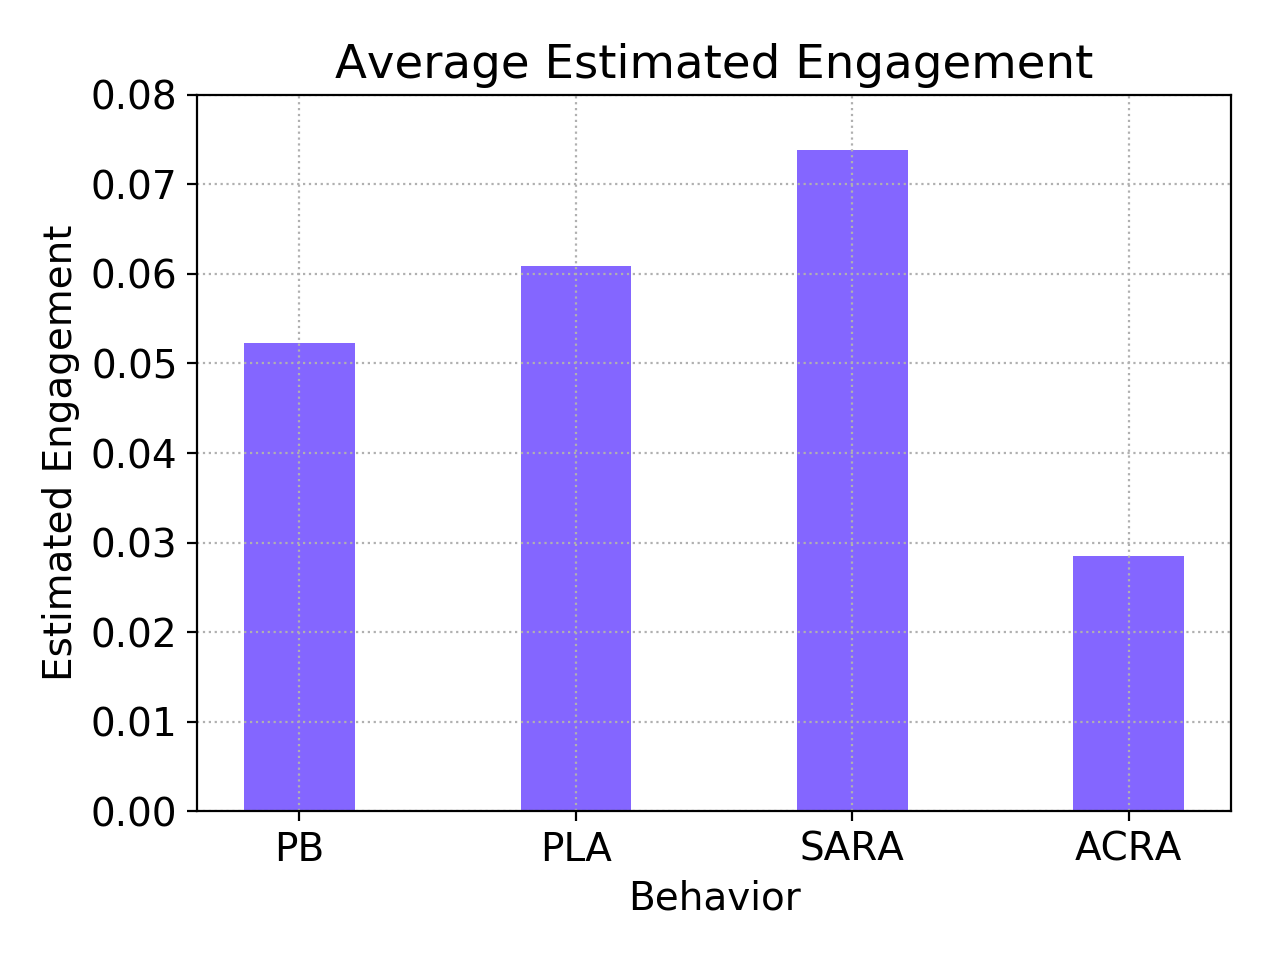

In [144]:
mean_PB = reward_data_pb.mean()
std_PB = reward_data_pb.std()

mean_PLA = reward_data_pla.mean()
std_PLA = reward_data_pla.std()

mean_SARA = reward_data_sara.mean()
std_SARA = reward_data_sara.std()

mean_ACRA = reward_data_acra.mean()
std_ACRA = reward_data_acra.std()

print('mean_PB={0:.4f}\nmean_PLA={1:.4f}\nmean_SARA={2:.4f}\nmean_ACRA={3:.4f}'.format(mean_PB,
                                                                                       mean_PLA,
                                                                                       mean_SARA,
                                                                                       mean_ACRA))
print('std_PB={0:.4f}\nstd_PLA={1:.4f}\nstd_SARA={2:.4f}\nstd_ACRA={3:.4f}'.format(std_PB,
                                                                                   std_PLA,
                                                                                   std_SARA,
                                                                                   std_ACRA))

plt.figure()
plt.bar(np.arange(0,4), [mean_PB,mean_PLA,mean_SARA,mean_ACRA],color=(0.2, 0, 1, 0.6), width=0.4)
plt.ylim(0,0.08)
plt.yticks(np.arange(0, 0.0801, 0.01))
plt.ylabel('Estimated Engagement')
plt.xlabel('Behavior')
plt.xticks(np.arange(0,4),['PB', 'PLA', 'SARA', 'ACRA'])
plt.title('Average Estimated Engagement')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig('./figures/Average_estimated_engagement.png', dpi=300)



Run "Estimated Occupancy: avg and standard deviation", then come back to this cell.

point_avg_PB  : mean=2.959477796836287,   std = 2.3112296786744273
point_avg_PLA : mean=3.070869485638088,   std = 2.6037004284674334
point_avg_SARA: mean=4.809092564994205,   std = 3.284168143885707
point_avg_ACRA: mean=2.2677126212803964,   std = 1.3520883052342922
mean_PB=0.05226468744378405
mean_PLA=0.06083642820737964
mean_SARA=0.07387137315560069
mean_ACRA=0.028523721868279412


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


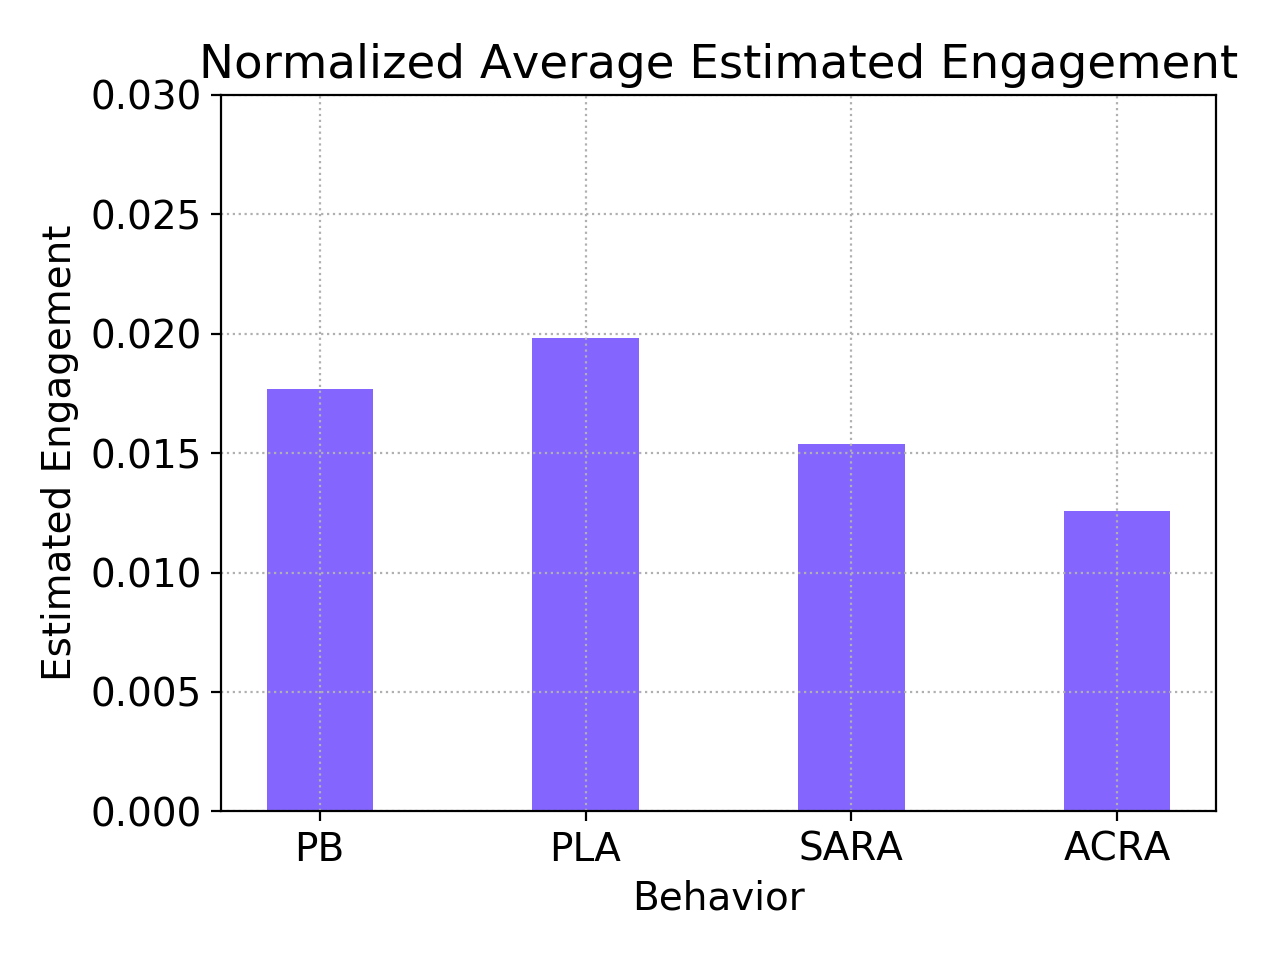

In [131]:
# average occupancy
print("point_avg_PB  : mean={},   std = {}".format(point_avg_PB.mean(),point_avg_PB.std()))
print("point_avg_PLA : mean={},   std = {}".format(point_avg_PLA.mean(),point_avg_PLA.std()))
print("point_avg_SARA: mean={},   std = {}".format(point_avg_SARA.mean(),point_avg_SARA.std()))
print("point_avg_ACRA: mean={},   std = {}".format(point_avg_ACRA.mean(),point_avg_ACRA.std()))
average_occupancy_estimate = [point_avg_PB.mean(), point_avg_PLA.mean(), point_avg_SARA.mean(), point_avg_ACRA.mean()]

mean_PB = reward_data_pb.mean()
mean_PLA = reward_data_pla.mean()
mean_SARA = reward_data_sara.mean()
mean_ACRA = reward_data_acra.mean()
average_estmated_engagement = [mean_PB,mean_PLA,mean_SARA,mean_ACRA]
print('mean_PB={0}\nmean_PLA={1}\nmean_SARA={2}\nmean_ACRA={3}'.format(mean_PB,mean_PLA,mean_SARA,mean_ACRA))

plt.figure()
plt.bar(np.arange(0,4), np.divide(average_estmated_engagement, average_occupancy_estimate),
        color=(0.2, 0, 1, 0.6), width=0.4)
plt.ylabel('Estimated Engagement')
plt.ylim(0, 0.03)
plt.xlabel('Behavior')
plt.xticks(np.arange(0,4),['PB', 'PLA', 'SARA', 'ACRA'])
plt.title('Normalized Average Estimated Engagement')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig('./figures/Normalized_average_engagement.png', dpi=300)



mean_PB=0.0177
mean_PLA=0.0198
mean_SARA=0.0154
mean_ACRA=0.0126
std_PB=0.0332
std_PLA=0.0392
std_SARA=0.0252
std_ACRA=0.0268


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


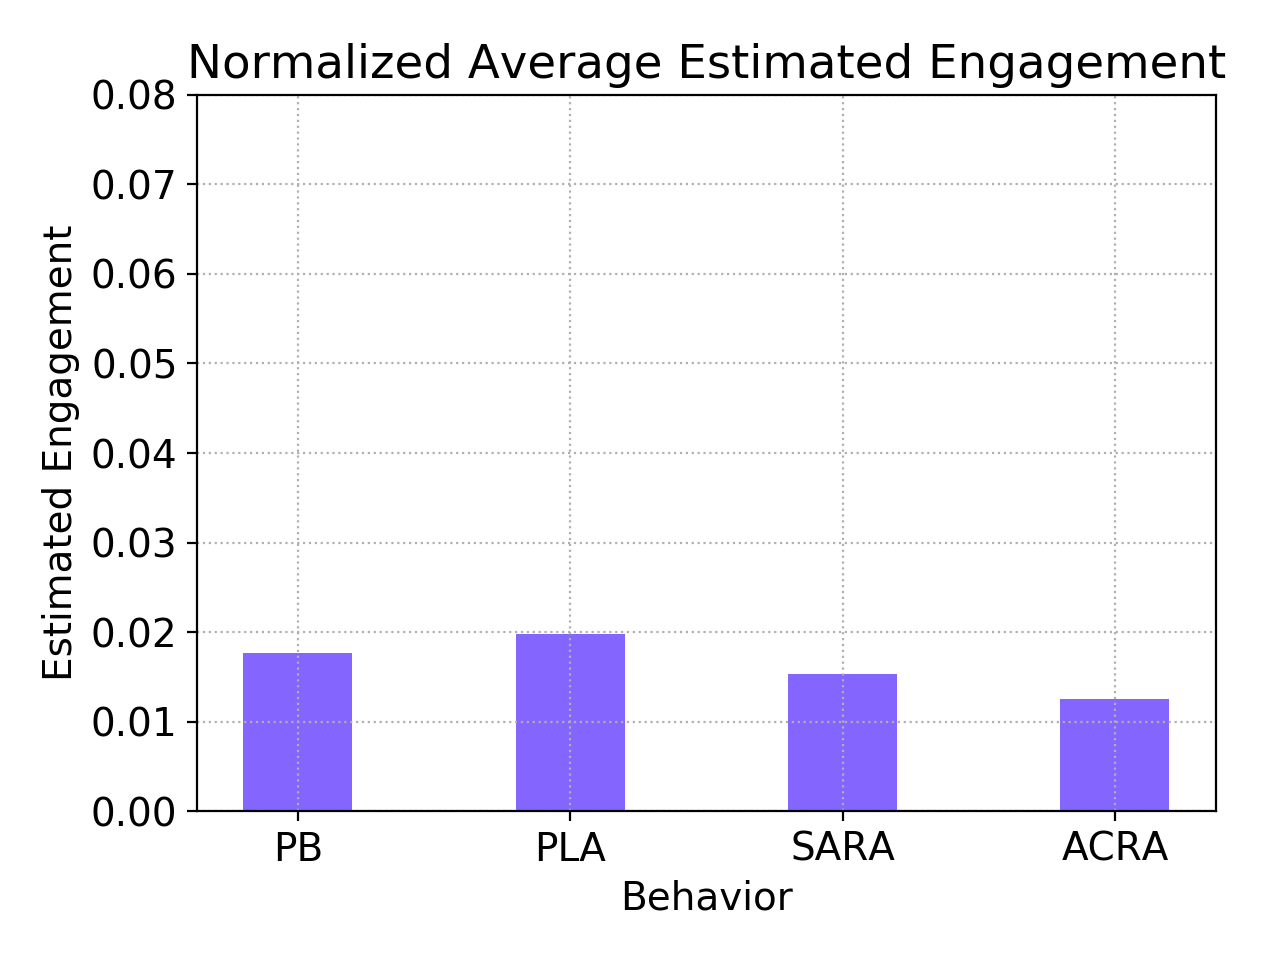

In [133]:
# Normalized reward
norm_reward_pb = reward_data_pb / point_avg_PB.mean()
norm_reward_pla = reward_data_pla / point_avg_PLA.mean()
norm_reward_sara = reward_data_sara / point_avg_SARA.mean()
norm_reward_acra = reward_data_acra / point_avg_ACRA.mean()

mean_PB = norm_reward_pb.mean()
std_PB = norm_reward_pb.std()

mean_PLA = norm_reward_pla.mean()
std_PLA = norm_reward_pla.std()

mean_SARA = norm_reward_sara.mean()
std_SARA = norm_reward_sara.std()

mean_ACRA = norm_reward_acra.mean()
std_ACRA = norm_reward_acra.std()

print('mean_PB={0:.4f}\nmean_PLA={1:.4f}\nmean_SARA={2:.4f}\nmean_ACRA={3:.4f}'.format(mean_PB,
                                                                                       mean_PLA,
                                                                                       mean_SARA,
                                                                                       mean_ACRA))
print('std_PB={0:.4f}\nstd_PLA={1:.4f}\nstd_SARA={2:.4f}\nstd_ACRA={3:.4f}'.format(std_PB,
                                                                                   std_PLA,
                                                                                   std_SARA,
                                                                                   std_ACRA))

plt.figure()
plt.bar(np.arange(0,4), [mean_PB, mean_PLA, mean_SARA, mean_ACRA],
        color=(0.2, 0, 1, 0.6), width=0.4)
plt.ylabel('Estimated Engagement')
plt.ylim(0, 0.08)
plt.xlabel('Behavior')
plt.xticks(np.arange(0,4),['PB', 'PLA', 'SARA', 'ACRA'])
plt.title('Normalized Average Estimated Engagement')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig('./figures/Normalized_average_engagement.png', dpi=300)

In [134]:
norm_engagement_avg_PB = engagement_avg_PB / point_avg_PB.mean()
norm_engagement_avg_PLA = engagement_avg_PLA / point_avg_PLA.mean()
norm_engagement_avg_SARA = engagement_avg_SARA / point_avg_SARA.mean()
norm_engagement_avg_ACRA = engagement_avg_ACRA / point_avg_ACRA.mean()



/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


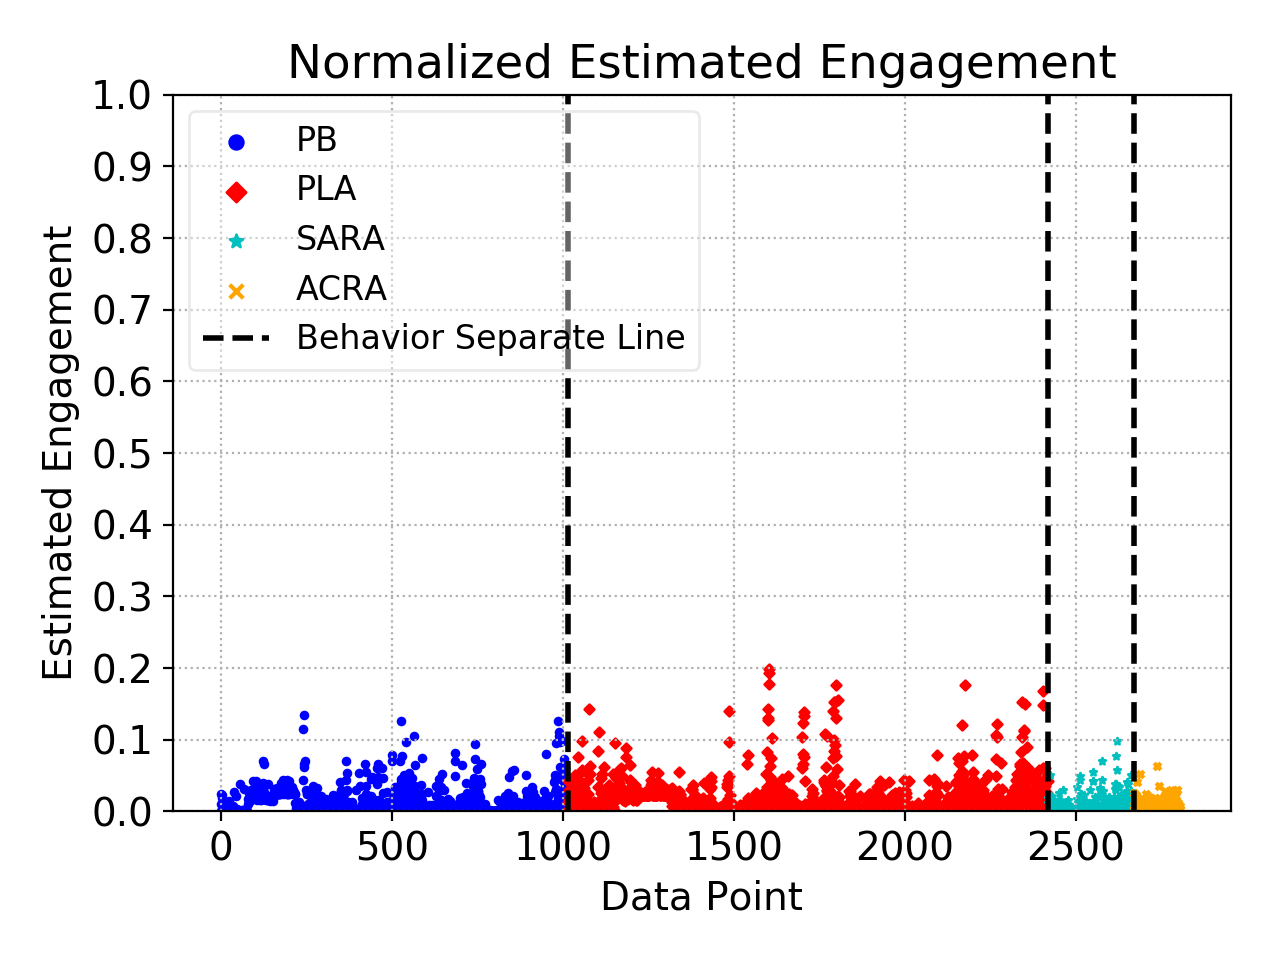

In [135]:
plt.figure()

start_PB = 0
end_PB = len(norm_engagement_avg_PB)
handle_engage_PB = plt.scatter(np.arange(start_PB, end_PB), norm_engagement_avg_PB, c='b', marker='o', s = 6)

start_PLA = end_PB
end_PLA = start_PLA+len(norm_engagement_avg_PLA)
handle_engage_PLA = plt.scatter(np.arange(start_PLA, end_PLA), norm_engagement_avg_PLA, c='r', marker='D', s = 6)

start_SARA = end_PLA
end_SARA = start_SARA+len(norm_engagement_avg_SARA)
handle_engage_SARA = plt.scatter(np.arange(start_SARA, end_SARA), norm_engagement_avg_SARA, c='c', marker='*', s = 6)

start_ACRA = end_SARA
end_ACRA = start_ACRA+len(norm_engagement_avg_ACRA)
handle_engage_ACRA = plt.scatter(np.arange(start_ACRA, end_ACRA), norm_engagement_avg_ACRA, c='orange', marker='x', s = 6)
# plt.ylim(0,0.5)

handle_engage_separate_line = plt.axvline(x=end_PB, linestyle='--', color='black',linewidth=2)
plt.axvline(x=end_PLA, linestyle='--', color='black',linewidth=2)
plt.axvline(x=end_SARA, linestyle='--', color='black',linewidth=2)

plt.ylabel('Estimated Engagement')
plt.xlabel('Data Point')

plt.ylim(0,1)
plt.yticks(np.arange(0,1.001,0.1))
plt.title('Normalized Estimated Engagement')
plt.legend(handles=[handle_engage_PB, handle_engage_PLA, handle_engage_SARA, handle_engage_ACRA, handle_engage_separate_line], 
           labels=['PB', 'PLA', 'SARA', 'ACRA', 'Behavior Separate Line'],fontsize=12, markerscale=2, framealpha=0.4)
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Normalized_Estimated_engagement_comparison_sparsed_data_point.png', dpi=300)



/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


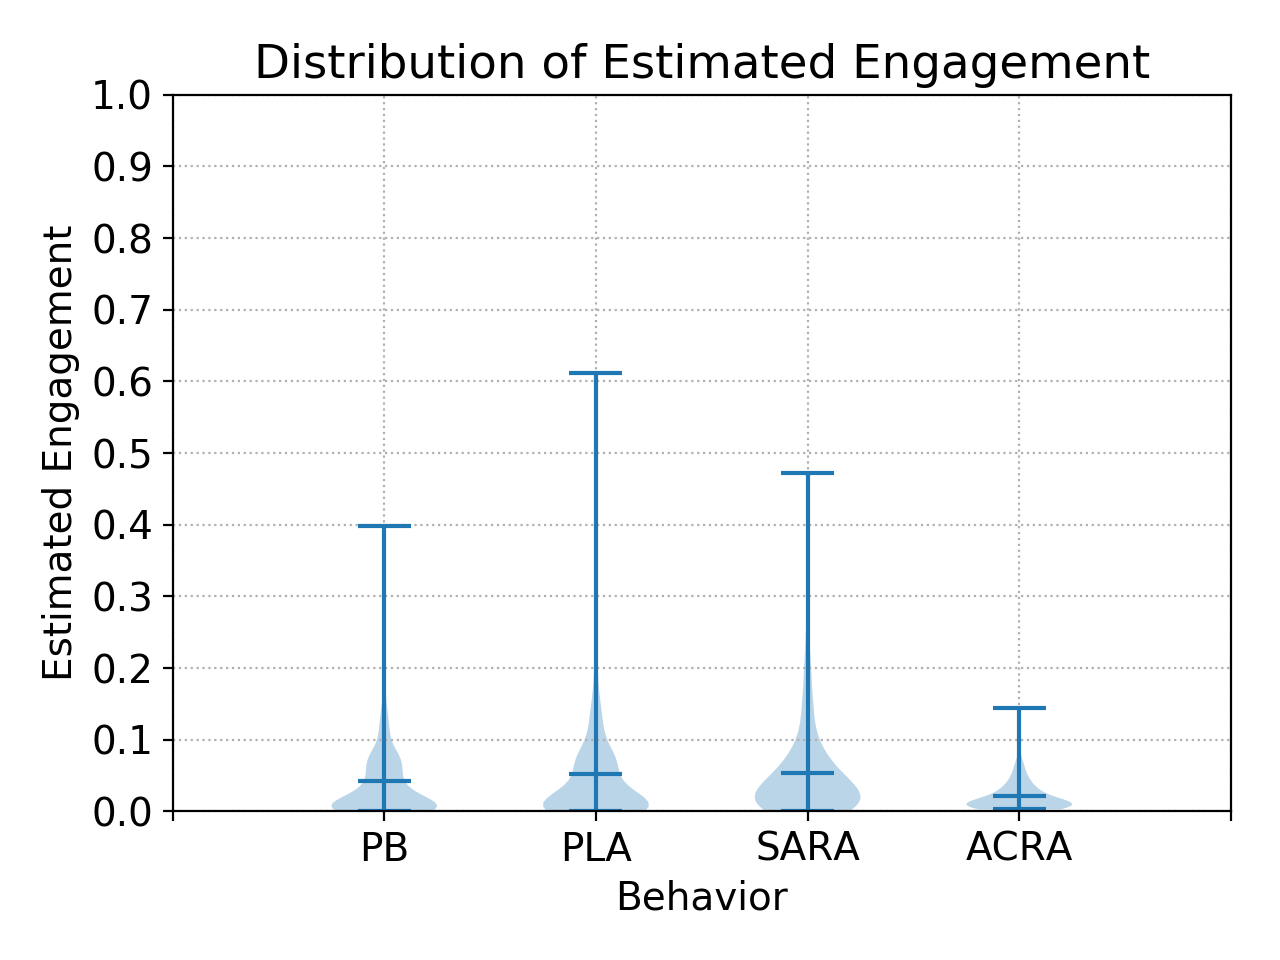

In [136]:
estimated_occupancy = [engagement_avg_PB, engagement_avg_PLA, 
                       engagement_avg_SARA, engagement_avg_ACRA]

plt.figure()
plt.rcParams.update({'font.size': 14})
plt.violinplot(estimated_occupancy, showmeans=True, showmedians=False)
plt.xticks(np.arange(0,6), ['','PB', 'PLA', 'SARA', 'ACRA'])
plt.ylim(0,1)
plt.yticks(np.arange(0,1.001,0.1))
plt.ylabel('Estimated Engagement')
plt.xlabel('Behavior')
plt.title('Distribution of Estimated Engagement')
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Distribution_of_Estimated_Engagement_sparsed_data_point.png', dpi=300)


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


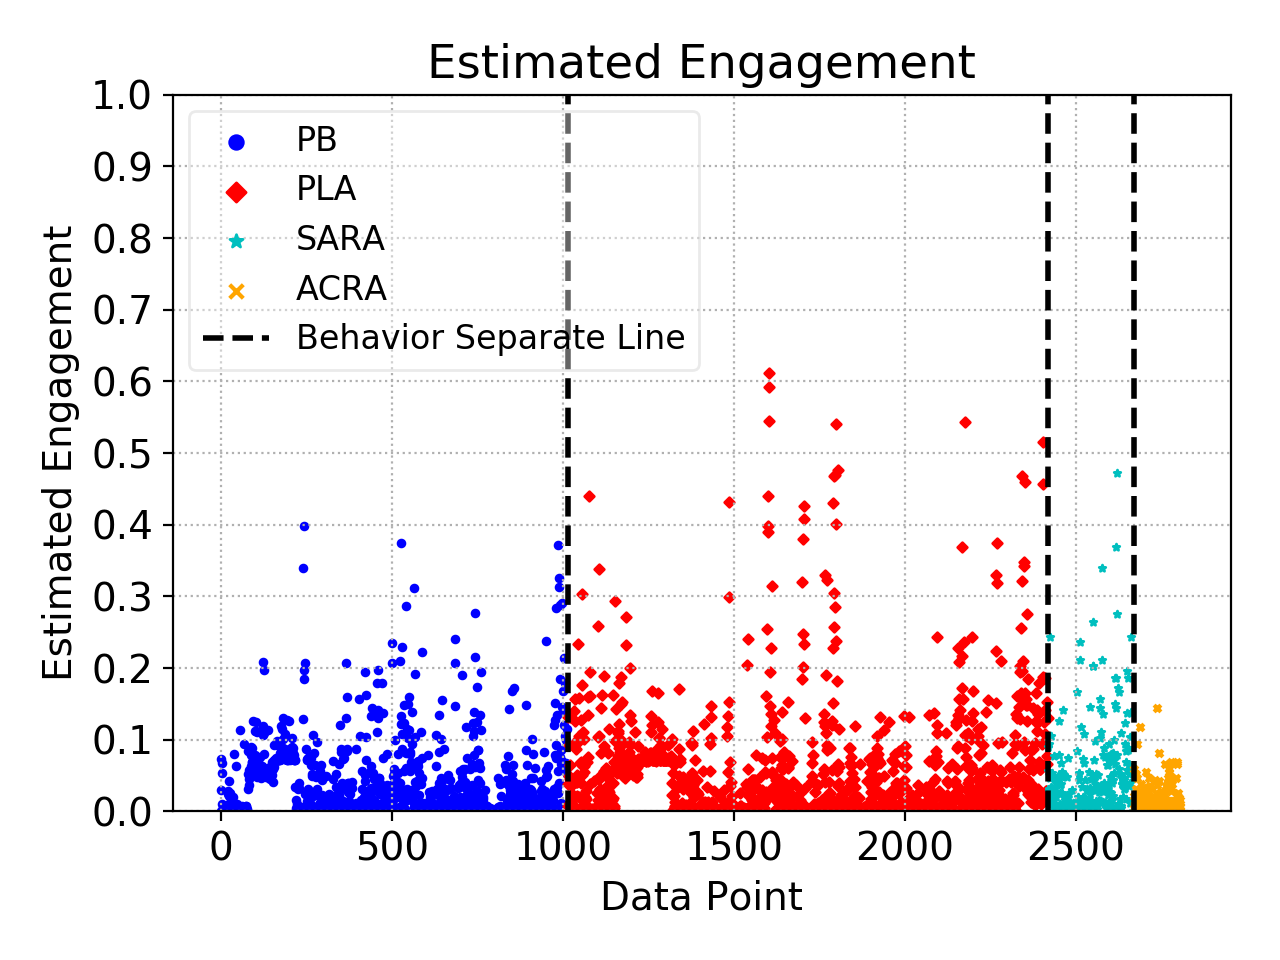

In [137]:
plt.figure()

start_PB = 0
end_PB = len(engagement_avg_PB)
handle_engage_PB = plt.scatter(np.arange(start_PB, end_PB), engagement_avg_PB, c='b', marker='o', s = 6)

start_PLA = end_PB
end_PLA = start_PLA+len(engagement_avg_PLA)
handle_engage_PLA = plt.scatter(np.arange(start_PLA, end_PLA), engagement_avg_PLA, c='r', marker='D', s = 6)

start_SARA = end_PLA
end_SARA = start_SARA+len(engagement_avg_SARA)
handle_engage_SARA = plt.scatter(np.arange(start_SARA, end_SARA), engagement_avg_SARA, c='c', marker='*', s = 6)

start_ACRA = end_SARA
end_ACRA = start_ACRA+len(engagement_avg_ACRA)
handle_engage_ACRA = plt.scatter(np.arange(start_ACRA, end_ACRA), engagement_avg_ACRA, c='orange', marker='x', s = 6)
# plt.ylim(0,0.5)

handle_engage_separate_line = plt.axvline(x=end_PB, linestyle='--', color='black',linewidth=2)
plt.axvline(x=end_PLA, linestyle='--', color='black',linewidth=2)
plt.axvline(x=end_SARA, linestyle='--', color='black',linewidth=2)

plt.ylabel('Estimated Engagement')
plt.xlabel('Data Point')

plt.ylim(0,1)
plt.yticks(np.arange(0,1.001,0.1))
plt.title('Estimated Engagement')
plt.legend(handles=[handle_engage_PB, handle_engage_PLA, handle_engage_SARA, handle_engage_ACRA, handle_engage_separate_line], 
           labels=['PB', 'PLA', 'SARA', 'ACRA', 'Behavior Separate Line'],fontsize=12, markerscale=2, framealpha=0.4)
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Estimated_engagement_comparison_sparsed_data_point.png', dpi=300)


In [24]:
print("point_avg_PB  : mean={:.4f},   std = {:.4f}".format(engagement_avg_PB.mean(),engagement_avg_PB.std()))
print("point_avg_PLA : mean={:.4f},   std = {:.4f}".format(engagement_avg_PLA.mean(),engagement_avg_PLA.std()))
print("point_avg_SARA: mean={:.4f},   std = {:.4f}".format(engagement_avg_SARA.mean(),engagement_avg_SARA.std()))
print("point_avg_ACRA: mean={:.4f},   std = {:.4f}".format(engagement_avg_ACRA.mean(),engagement_avg_ACRA.std()))

point_avg_PB  : mean=0.0419,   std = 0.0554
point_avg_PLA : mean=0.0529,   std = 0.0797
point_avg_SARA: mean=0.0543,   std = 0.0671
point_avg_ACRA: mean=0.0218,   std = 0.0224


#####  t-test
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind

standard independent 2 sample test

In [25]:
from scipy import stats
t_PB_PLA, p_PB_PLA = stats.ttest_ind(engagement_avg_PB, engagement_avg_PLA)
t_PB_SARA, p_PB_SARA = stats.ttest_ind(engagement_avg_PB, engagement_avg_SARA)
t_PB_ACRA, p_PB_ACRA =stats.ttest_ind(engagement_avg_PB, engagement_avg_ACRA)
t_PLA_SARA, p_PLA_SARA =stats.ttest_ind(engagement_avg_PLA, engagement_avg_SARA)
t_PLA_ACRA, p_PLA_ACRA = stats.ttest_ind(engagement_avg_PLA, engagement_avg_ACRA)
t_SARA_ACRA, t_SARA_ACRA =stats.ttest_ind(engagement_avg_SARA, engagement_avg_ACRA)
print('t_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(t_PB_PLA, p_PB_PLA))
print('t_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(t_PB_SARA, p_PB_SARA))
print('t_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(t_PB_ACRA, p_PB_ACRA))
print('t_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(t_PLA_SARA, p_PLA_SARA))
print('t_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(t_PLA_ACRA, p_PLA_ACRA))
print('t_SARA_ACRA={0:.4f}, t_SARA_ACRA={1:.4f}'.format(t_SARA_ACRA, t_SARA_ACRA))


t_PB_PLA=-3.7748, p_PB_PLA=0.0002
t_PB_SARA=-3.0278, p_PB_SARA=0.0025
t_PB_ACRA=4.2014, p_PB_ACRA=0.0000
t_PLA_SARA=-0.2636, p_PLA_SARA=0.7921
t_PLA_ACRA=4.5513, p_PLA_ACRA=0.0000
t_SARA_ACRA=0.0000, t_SARA_ACRA=0.0000


Welch’s t-test, which does not assume equal population variance

In [110]:
from scipy import stats
t_PB_PLA, p_PB_PLA = stats.ttest_ind(engagement_avg_PB, engagement_avg_PLA, equal_var=False)
t_PB_SARA, p_PB_SARA = stats.ttest_ind(engagement_avg_PB, engagement_avg_SARA, equal_var=False)
t_PB_ACRA, p_PB_ACRA =stats.ttest_ind(engagement_avg_PB, engagement_avg_ACRA, equal_var=False)
t_PLA_SARA, p_PLA_SARA =stats.ttest_ind(engagement_avg_PLA, engagement_avg_SARA, equal_var=False)
t_PLA_ACRA, p_PLA_ACRA = stats.ttest_ind(engagement_avg_PLA, engagement_avg_ACRA, equal_var=False)
t_SARA_ACRA, t_SARA_ACRA =stats.ttest_ind(engagement_avg_SARA, engagement_avg_ACRA, equal_var=False)
print('t_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(t_PB_PLA, p_PB_PLA))
print('t_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(t_PB_SARA, p_PB_SARA))
print('t_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(t_PB_ACRA, p_PB_ACRA))
print('t_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(t_PLA_SARA, p_PLA_SARA))
print('t_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(t_PLA_ACRA, p_PLA_ACRA))
print('t_SARA_ACRA={0:.4f}, t_SARA_ACRA={1:.4f}'.format(t_SARA_ACRA, t_SARA_ACRA))



t_PB_PLA=-3.9935, p_PB_PLA=0.0001
t_PB_SARA=-2.6948, p_PB_SARA=0.0074
t_PB_ACRA=7.7501, p_PB_ACRA=0.0000
t_PLA_SARA=-0.2966, p_PLA_SARA=0.7669
t_PLA_ACRA=10.8402, p_PLA_ACRA=0.0000
t_SARA_ACRA=0.0000, t_SARA_ACRA=0.0000


##### KS-test

In [26]:
from scipy import stats
KS_PB_PLA, p_PB_PLA = stats.ks_2samp(engagement_avg_PB, engagement_avg_PLA)
KS_PB_SARA, p_PB_SARA = stats.ks_2samp(engagement_avg_PB, engagement_avg_SARA)
KS_PB_ACRA, p_PB_ACRA =stats.ks_2samp(engagement_avg_PB, engagement_avg_ACRA)
KS_PLA_SARA, p_PLA_SARA =stats.ks_2samp(engagement_avg_PLA, engagement_avg_SARA)
KS_PLA_ACRA, p_PLA_ACRA = stats.ks_2samp(engagement_avg_PLA, engagement_avg_ACRA)
KS_SARA_ACRA, p_SARA_ACRA =stats.ks_2samp(engagement_avg_SARA, engagement_avg_ACRA)
print('KS_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(KS_PB_PLA, p_PB_PLA*2))
print('KS_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(KS_PB_SARA, p_PB_SARA*2))
print('KS_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(KS_PB_ACRA, p_PB_ACRA*2))
print('KS_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(KS_PLA_SARA, p_PLA_SARA*2))
print('KS_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(KS_PLA_ACRA, p_PLA_ACRA*2))
print('KS_SARA_ACRA={0:.4f}, p_SARA_ACRA={1:.4f}'.format(KS_SARA_ACRA, p_SARA_ACRA*2))


KS_PB_PLA=0.0613, p_PB_PLA=0.0461
KS_PB_SARA=0.1851, p_PB_SARA=0.0000
KS_PB_ACRA=0.2329, p_PB_ACRA=0.0000
KS_PLA_SARA=0.1899, p_PLA_SARA=0.0000
KS_PLA_ACRA=0.2687, p_PLA_ACRA=0.0000
KS_SARA_ACRA=0.3129, p_SARA_ACRA=0.0000


### Without average

In [27]:

from scipy import stats
KS_PB_PLA, p_PB_PLA = stats.ttest_ind(reward_data_pb, reward_data_pla)
KS_PB_SARA, p_PB_SARA = stats.ttest_ind(reward_data_pb, reward_data_sara)
KS_PB_ACRA, p_PB_ACRA =stats.ttest_ind(reward_data_pb, reward_data_acra)
KS_PLA_SARA, p_PLA_SARA =stats.ttest_ind(reward_data_pla, reward_data_sara)
KS_PLA_ACRA, p_PLA_ACRA = stats.ttest_ind(reward_data_pla, reward_data_acra)
KS_SARA_ACRA, p_SARA_ACRA =stats.ttest_ind(reward_data_sara, reward_data_acra)
print('KS_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(KS_PB_PLA, p_PB_PLA))
print('KS_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(KS_PB_SARA, p_PB_SARA))
print('KS_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(KS_PB_ACRA, p_PB_ACRA))
print('KS_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(KS_PLA_SARA, p_PLA_SARA))
print('KS_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(KS_PLA_ACRA, p_PLA_ACRA))
print('KS_SARA_ACRA={0:.4f}, p_SARA_ACRA={1:.4f}'.format(KS_SARA_ACRA, p_SARA_ACRA))



KS_PB_PLA=-43.8223, p_PB_PLA=0.0000
KS_PB_SARA=-32.4468, p_PB_SARA=0.0000
KS_PB_ACRA=43.7296, p_PB_ACRA=0.0000
KS_PLA_SARA=-3.4875, p_PLA_SARA=0.0005
KS_PLA_ACRA=54.3641, p_PLA_ACRA=0.0000
KS_SARA_ACRA=56.7010, p_SARA_ACRA=0.0000


In [111]:

from scipy import stats
KS_PB_PLA, p_PB_PLA = stats.ttest_ind(reward_data_pb, reward_data_pla, equal_var=False)
KS_PB_SARA, p_PB_SARA = stats.ttest_ind(reward_data_pb, reward_data_sara, equal_var=False)
KS_PB_ACRA, p_PB_ACRA =stats.ttest_ind(reward_data_pb, reward_data_acra, equal_var=False)
KS_PLA_SARA, p_PLA_SARA =stats.ttest_ind(reward_data_pla, reward_data_sara, equal_var=False)
KS_PLA_ACRA, p_PLA_ACRA = stats.ttest_ind(reward_data_pla, reward_data_acra, equal_var=False)
KS_SARA_ACRA, p_SARA_ACRA =stats.ttest_ind(reward_data_sara, reward_data_acra, equal_var=False)
print('KS_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(KS_PB_PLA, p_PB_PLA))
print('KS_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(KS_PB_SARA, p_PB_SARA))
print('KS_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(KS_PB_ACRA, p_PB_ACRA))
print('KS_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(KS_PLA_SARA, p_PLA_SARA))
print('KS_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(KS_PLA_ACRA, p_PLA_ACRA))
print('KS_SARA_ACRA={0:.4f}, p_SARA_ACRA={1:.4f}'.format(KS_SARA_ACRA, p_SARA_ACRA))




KS_PB_PLA=-30.4319, p_PB_PLA=0.0000
KS_PB_SARA=-39.0507, p_PB_SARA=0.0000
KS_PB_ACRA=60.0670, p_PB_ACRA=0.0000
KS_PLA_SARA=-23.5597, p_PLA_SARA=0.0000
KS_PLA_ACRA=81.7620, p_PLA_ACRA=0.0000
KS_SARA_ACRA=73.2761, p_SARA_ACRA=0.0000


In [28]:
from scipy import stats
KS_PB_PLA, p_PB_PLA = stats.ks_2samp(reward_data_pb, reward_data_pla)
KS_PB_SARA, p_PB_SARA = stats.ks_2samp(reward_data_pb, reward_data_sara)
KS_PB_ACRA, p_PB_ACRA =stats.ks_2samp(reward_data_pb, reward_data_acra)
KS_PLA_SARA, p_PLA_SARA =stats.ks_2samp(reward_data_pla, reward_data_sara)
KS_PLA_ACRA, p_PLA_ACRA = stats.ks_2samp(reward_data_pla, reward_data_acra)
KS_SARA_ACRA, p_SARA_ACRA =stats.ks_2samp(reward_data_sara, reward_data_acra)
print('KS_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(KS_PB_PLA, p_PB_PLA))
print('KS_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(KS_PB_SARA, p_PB_SARA))
print('KS_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(KS_PB_ACRA, p_PB_ACRA))
print('KS_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(KS_PLA_SARA, p_PLA_SARA))
print('KS_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(KS_PLA_ACRA, p_PLA_ACRA))
print('KS_SARA_ACRA={0:.4f}, p_SARA_ACRA={1:.4f}'.format(KS_SARA_ACRA, p_SARA_ACRA))


KS_PB_PLA=0.0668, p_PB_PLA=0.0000
KS_PB_SARA=0.0663, p_PB_SARA=0.0000
KS_PB_ACRA=0.1348, p_PB_ACRA=0.0000
KS_PLA_SARA=0.1320, p_PLA_SARA=0.0000
KS_PLA_ACRA=0.1659, p_PLA_ACRA=0.0000
KS_SARA_ACRA=0.1671, p_SARA_ACRA=0.0000


<IPython.core.display.Javascript object>


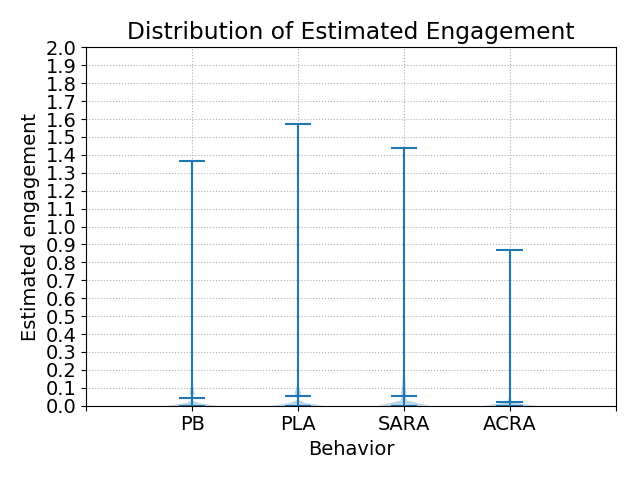

In [29]:
estimated_occupancy = [reward_data_pb, reward_data_pla, 
                       reward_data_sara, reward_data_acra]

plt.figure()
plt.rcParams.update({'font.size': 14})
plt.violinplot(estimated_occupancy, showmeans=True, showmedians=False)
plt.xticks(np.arange(0,6), ['','PB', 'PLA', 'SARA', 'ACRA'])
plt.ylim(0,2)
plt.yticks(np.arange(0,2.001,0.1))
plt.ylabel('Estimated engagement')
plt.xlabel('Behavior')
plt.title('Distribution of Estimated Engagement')
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Distribution_of_Estimated_Engagement.png', dpi=300)


<IPython.core.display.Javascript object>


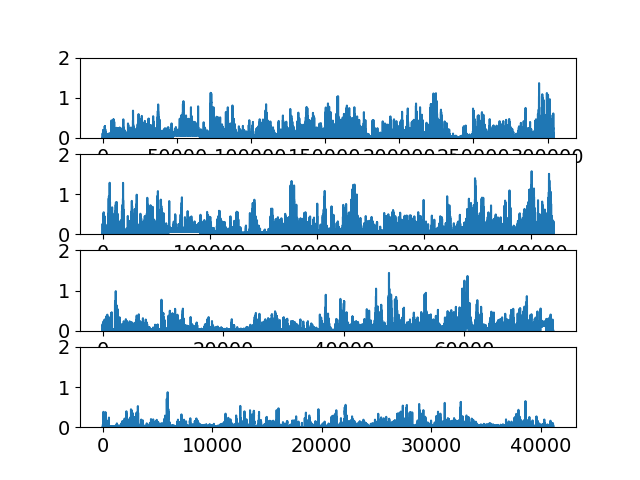

(0, 2)

In [30]:
plt.figure()
plt.subplot(4,1,1)
plt.plot(np.arange(len(reward_data_pb)), reward_data_pb)
plt.ylim(0,2)

plt.subplot(4,1,2)
plt.plot(np.arange(len(reward_data_pla)), reward_data_pla)
plt.ylim(0,2)

plt.subplot(4,1,3)
plt.plot(np.arange(len(reward_data_sara)), reward_data_sara)
plt.ylim(0,2)

plt.subplot(4,1,4)
plt.plot(np.arange(len(reward_data_acra)), reward_data_acra)
plt.ylim(0,2)



/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


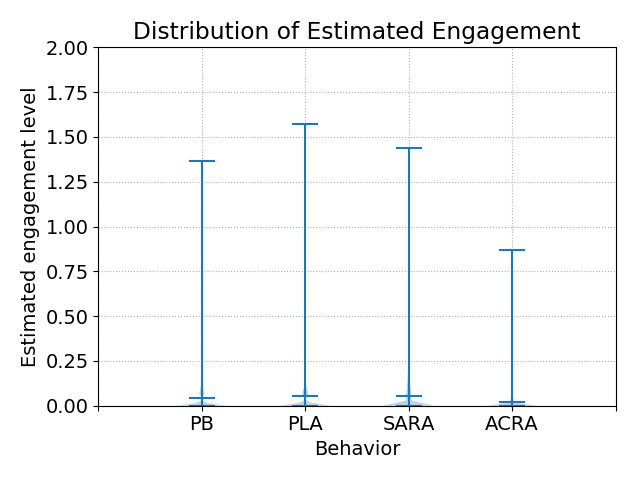

In [31]:
estimated_occupancy = [reward_data_pb, reward_data_pla, 
                       reward_data_sara, reward_data_acra]

plt.figure()
plt.rcParams.update({'font.size': 14})
plt.violinplot(estimated_occupancy, showmeans=True, showmedians=False)
plt.xticks(np.arange(0,6), ['','PB', 'PLA', 'SARA', 'ACRA'])
plt.ylim(0,2)
plt.ylabel('Estimated engagement level')
plt.xlabel('Behavior')
plt.title('Distribution of Estimated Engagement')
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Distribution_of_Estimated_Engagement.png', dpi=300)



# Plot Reward With Zoom In

In [32]:
def plot_reward_in_range(reward_low, reward_up, 
                         prescribed_behavior, para_learning_agent, 
                         behavior_name1, behavior_name2):
    """
    Args:
        reward_low (float): lower bound of reward range
        reward_up (float): upper bound of reward range
        prescribed_behavior :
        para_learning_agent :
        behavior_name1 :
        behavior_name2 :
    """
    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.1
    bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
    binWidth = 0.1

    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100
    
    # Plot all hist
    fig = plt.figure(figsize=(10,6))
    plt.bar(edges_pb[:-1]+binWidth/2, percentage_pb, binWidth, edgecolor='white')
    plt.bar(edges_pla[:-1]+binWidth/2, -percentage_pla, binWidth, edgecolor='white')
    segment_len = 5
    for x, y in zip(edges_pb[0:segment_len], percentage_pb[0:segment_len]):
        plt.text(x+binWidth/2, y + 2.5, '{0:.2f}'.format(y), ha='center', va= 'bottom')

    for x, y in zip(edges_pla[0:segment_len], percentage_pla[0:segment_len]):
        plt.text(x+binWidth/2, -y - 2.5, '{0:.2f}'.format(y), ha='center', va= 'top')
    
    plt.xlim(edges_pb[0]-bin_step*0.99, edges_pb[-1])
    plt.xlabel('reward')
    plt.xticks(edges_pb[:-1], rotation=30)
    plt.ylim(-100, 100)
    plt.yticks(np.arange(-100, 100.1, 10))
    plt.ylabel('percentage')
    plt.gca().set_yticklabels(['{:.0f}%'.format(abs(x)) for x in plt.gca().get_yticks()])

    plt.legend([behavior_name1, behavior_name2], loc=(0.14, 0.01))
    #plt.title('{} vs {} \nreward in range [{:.1f}, {:.1f})'.format(behavior_name1, behavior_name2, edges_pb[0], edges_pb[-1]))
    plt.title('{} vs {}'.format(behavior_name1, behavior_name2))
    plt.grid(True, linestyle=':')
    plt.show()
    
    # annotate Zoom In text and arrow
    zoom_in_arrow = [[0.4, 25, 1, 25], [0.9, -25, 1.5, -25], [1.4, 25, 2, 25]]
    zoom_in_arrow_start = [[0.49, 0, 0.91, 0], [0.99, 0, 1.41, 0], [1.49, 0, 1.91, 0]]
    zoom_in_text = [[0.7, 5], [1.2, -15], [1.7, 5]]
    for i in range(3):
        plt.annotate('',
                     xy=(zoom_in_arrow[i][0], zoom_in_arrow[i][1]), xycoords='data',
                     xytext=(zoom_in_arrow_start[i][0], zoom_in_arrow_start[i][1]), 
                     arrowprops=dict(facecolor='black', shrink=0.025, fill=False, color='r',linestyle=':'),
                     horizontalalignment='right', verticalalignment='top')
        plt.annotate('',
                     xy=(zoom_in_arrow[i][2], zoom_in_arrow[i][3]), xycoords='data',
                     xytext=(zoom_in_arrow_start[i][2], zoom_in_arrow_start[i][3]),
                     arrowprops=dict(facecolor='black', shrink=0.025, fill=False, color='r',linestyle=':'),
                     horizontalalignment='right', verticalalignment='top')
        plt.text(zoom_in_text[i][0], zoom_in_text[i][1], 'zoom in', ha='center', va= 'bottom',fontsize='large')
        
    # Plot Zoom In Part
    segment_num = 4
    segment_len = 5
    ylim = [100, 1, 0.1, 0.01]
    text_shift = [2.5, 0.1, 0.01, 0.001]
    sub_axes = [[0.31, 0.59, .22, .22], [0.495, 0.175, .22, .22], [0.68, 0.59, .22, .22]]
    
    for i in range(1,segment_num):
        # add axes
        a = plt.axes(sub_axes[i-1])
        
        # plot
        plt.bar(edges_pb[i*segment_len:(i+1)*segment_len]+binWidth/2, percentage_pb[i*segment_len:(i+1)*segment_len], binWidth, edgecolor='white')
        plt.bar(edges_pla[i*segment_len:(i+1)*segment_len]+binWidth/2, -percentage_pla[i*segment_len:(i+1)*segment_len], binWidth, edgecolor='white')

        for x, y in zip(edges_pb[i*segment_len:(i+1)*segment_len], percentage_pb[i*segment_len:(i+1)*segment_len]):
            if y>0.0005:
                plt.text(x+binWidth/2, y + text_shift[i], '{0:.3f}'.format(y), ha='center', va= 'bottom', rotation=20)
            else:
                plt.text(x+binWidth/2, y + text_shift[i], '{0:.0f}'.format(y), ha='center', va= 'bottom', rotation=20)

        for x, y in zip(edges_pla[i*segment_len:(i+1)*segment_len], percentage_pla[i*segment_len:(i+1)*segment_len]):
            if y>0.0005:
                plt.text(x+binWidth/2, -y - text_shift[i], '{0:.3f}'.format(y), ha='center', va= 'top', rotation=-20)
            else:
                plt.text(x+binWidth/2, -y - text_shift[i], '{0:.0f}'.format(y), ha='center', va= 'top', rotation=-20)

        plt.xlim(edges_pb[i*segment_len]-bin_step*0.99, edges_pb[(i+1)*segment_len])
        #plt.xlabel('reward')
        plt.xticks(edges_pb[i*segment_len:(i+1)*segment_len])
        plt.ylim(-ylim[i], ylim[i])
        #plt.ylabel('percentage')
        #plt.gca().set_yticklabels(['{:.3f}'.format(abs(x)) for x in plt.gca().get_yticks()])
        plt.gca().set_yticklabels([])
        #plt.gca().get_yaxis().set_visible(False)

        #plt.legend([behavior_name1, behavior_name2], loc='upper right')
        #plt.title('reward in range [{:.1f}, {:.1f})'.format(edges_pb[i*segment_len], edges_pb[(i+1)*segment_len]))
        plt.grid(True, linestyle=':')
        plt.show()
    plt.savefig('./figures/plot_reward_{}_{}_in_range_{}_{}.png'.format(behavior_name1, 
                                                              behavior_name2, 
                                                              str(reward_low).replace('.','_'), 
                                                              str(reward_up).replace('.','_')), 
                dpi=300)
   


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


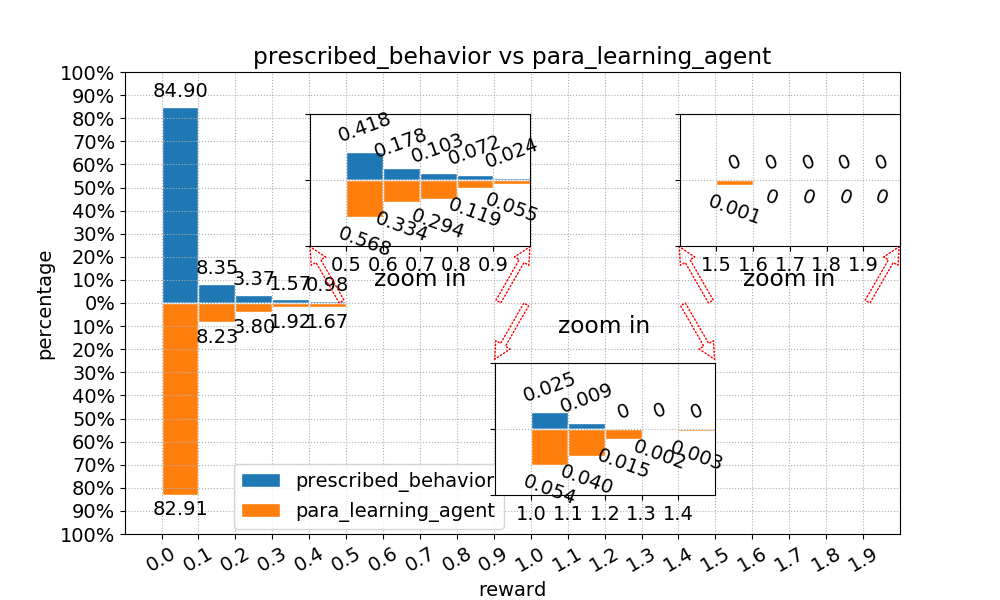

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng

<IPython.core.display.Javascript object>


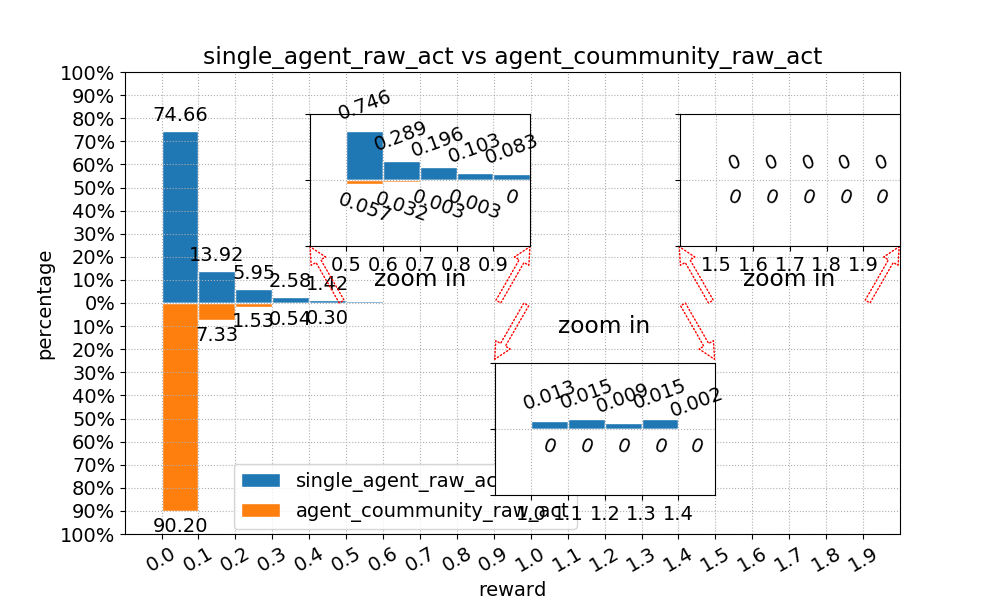

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"
/Users/jack.lingheng

In [33]:
reward_low = 0
reward_up = 2
plot_reward_in_range(reward_low, reward_up, 
                     prescribed_behavior, para_learning_agent, 
                     'prescribed_behavior', 'para_learning_agent')

reward_low = 0
reward_up = 2
plot_reward_in_range(reward_low, reward_up, 
                     single_agent_raw_act, agent_coummunity_raw_act,
                    'single_agent_raw_act', 'agent_coummunity_raw_act')

In [34]:
bin_low = 0.1#0
bin_up = 2
bin_step = 0.1
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.1

# Prescribed Behavior
reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
results_pb, edges_pb = np.histogram(hist_data_pb, bins)


# Parameterized Learning Agent
reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
results_pla, edges_pla = np.histogram(hist_data_pla, bins)


alternative hypothesis: $p_{PB}<p_{PLA}$

In [35]:
from statsmodels.stats.proportion import proportions_ztest
for i in range(len(edges_pb)-1):
    counts = np.array([results_pb[i], results_pla[i]])
    nobs = np.array([sum(results_pb), sum(results_pla)])
    stat, pval = proportions_ztest(counts, nobs, alternative='smaller')
    print('[{}, {})'.format(edges_pb[i], edges_pb[i+1]))
    #print('stat={:.4f}, pval={:.4f}'.format(stat, pval))
    print('pval={}'.format(pval))

[0.1, 0.2)
pval=1.0
[0.2, 0.30000000000000004)
pval=0.6919933341030738
[0.30000000000000004, 0.4)
pval=2.2551251677663073e-05
[0.4, 0.5)
pval=2.6084562616603054e-69
[0.5, 0.6)
pval=6.450343480419495e-07
[0.6, 0.7000000000000001)
pval=1.554067832114498e-20
[0.7000000000000001, 0.8)
pval=1.6768510862032992e-43
[0.8, 0.9)
pval=8.971335029948509e-06
[0.9, 1.0)
pval=5.399281273659409e-07
[1.0, 1.1)
pval=4.229226866875527e-06
[1.1, 1.2000000000000002)
pval=1.634534964798656e-11
[1.2000000000000002, 1.3000000000000003)
pval=6.313191718145751e-09
[1.3000000000000003, 1.4000000000000001)
pval=0.07523881422551452
[1.4000000000000001, 1.5000000000000002)
pval=0.0039336981126949925
[1.5000000000000002, 1.6)
pval=0.09195798209111145
[1.6, 1.7000000000000002)
pval=nan
[1.7000000000000002, 1.8000000000000003)
pval=nan
[1.8000000000000003, 1.9000000000000001)
pval=nan
[1.9000000000000001, 2.0)
pval=nan


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


In [36]:
bin_low = 0.1#0
bin_up = 2
bin_step = 0.1
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.1

# Prescribed Behavior
reward_data_SARA = single_agent_raw_act['data']['reward_IR_distance'].astype(float).values
reward_data_SARA = reward_data_SARA[reward_data_SARA!=0] # remove 0
hist_data_SARA = reward_data_SARA[reward_data_SARA>=bin_low]
hist_data_SARA = hist_data_SARA[hist_data_SARA<bin_up]
results_SARA, edges_SARA = np.histogram(hist_data_SARA, bins)


# Parameterized Learning Agent
reward_data_ACRA = agent_coummunity_raw_act['data']['reward_IR_distance'].astype(float).values
reward_data_ACRA = reward_data_ACRA[reward_data_ACRA!=0] # remove 0
hist_data_ACRA = reward_data_ACRA[reward_data_ACRA>=bin_low]
hist_data_ACRA = hist_data_ACRA[hist_data_ACRA<bin_up]
results_ACRA, edges_ACRA = np.histogram(hist_data_ACRA, bins)



alternative hypothesis: $p_{SARA}>p_{ACRA}$

In [37]:
from statsmodels.stats.proportion import proportions_ztest
for i in range(len(edges_SARA)-1):
    counts = np.array([results_SARA[i], results_ACRA[i]])
    nobs = np.array([sum(results_SARA), sum(results_ACRA)])
    stat, pval = proportions_ztest(counts, nobs, alternative='larger')
    print('[{}, {})'.format(edges_pb[i], edges_pb[i+1]))
    #print('stat={:.4f}, pval={:.4f}'.format(stat, pval))
    print('pval={}'.format(pval))

[0.1, 0.2)
pval=1.0
[0.2, 0.30000000000000004)
pval=8.171151026381727e-22
[0.30000000000000004, 0.4)
pval=2.6830557665084347e-16
[0.4, 0.5)
pval=3.1919761211019506e-09
[0.5, 0.6)
pval=1.4079671493337095e-14
[0.6, 0.7000000000000001)
pval=1.6320298867703815e-05
[0.7000000000000001, 0.8)
pval=1.3788567672823076e-06
[0.8, 0.9)
pval=0.0005668233647743483
[0.9, 1.0)
pval=0.0006837483166289724
[1.0, 1.1)
pval=0.10611986758928232
[1.1, 1.2000000000000002)
pval=0.09116777655636193
[1.2000000000000002, 1.3000000000000003)
pval=0.1458935567260769
[1.3000000000000003, 1.4000000000000001)
pval=0.09116777655636193
[1.4000000000000001, 1.5000000000000002)
pval=0.31867704002091635
[1.5000000000000002, 1.6)
pval=nan
[1.6, 1.7000000000000002)
pval=nan
[1.7000000000000002, 1.8000000000000003)
pval=nan
[1.8000000000000003, 1.9000000000000001)
pval=nan
[1.9000000000000001, 2.0)
pval=nan


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


In [38]:
PB_PLA = {}
PB_PLA_Data = pd.concat([prescribed_behavior['data'], para_learning_agent['data']])
PB_PLA['data'] = PB_PLA_Data

SARA_ACRA = {}
SARA_ACRA_Data = pd.concat([single_agent_raw_act['data'], agent_coummunity_raw_act['data']])
SARA_ACRA['data'] = SARA_ACRA_Data



In [39]:
bin_low = 0.1#0
bin_up = 2
bin_step = 0.1
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.1

# Prescribed Behavior
reward_data_PB_PLA = PB_PLA['data']['reward_IR_distance'].astype(float).values
reward_data_PB_PLA = reward_data_PB_PLA[reward_data_PB_PLA!=0] # remove 0
hist_data_PB_PLA = reward_data_PB_PLA[reward_data_PB_PLA>=bin_low]
hist_data_PB_PLA = hist_data_PB_PLA[hist_data_PB_PLA<bin_up]
results_PB_PLA, edges_PB_PLA = np.histogram(hist_data_PB_PLA, bins)


# Parameterized Learning Agent
reward_data_SARA_ACRA = SARA_ACRA['data']['reward_IR_distance'].astype(float).values
reward_data_SARA_ACRA = reward_data_SARA_ACRA[reward_data_SARA_ACRA!=0] # remove 0
hist_data_SARA_ACRA = reward_data_SARA_ACRA[reward_data_SARA_ACRA>=bin_low]
hist_data_SARA_ACRA = hist_data_SARA_ACRA[hist_data_SARA_ACRA<bin_up]
results_SARA_ACRA, edges_SARA_ACRA = np.histogram(hist_data_SARA_ACRA, bins)



In [40]:
from statsmodels.stats.proportion import proportions_ztest
for i in range(len(edges_PB_PLA)-1):
    counts = np.array([results_PB_PLA[i], results_SARA_ACRA[i]])
    nobs = np.array([sum(results_PB_PLA), sum(results_SARA_ACRA)])
    stat, pval = proportions_ztest(counts, nobs, alternative='larger')
    print('[{}, {})'.format(edges_PB_PLA[i], edges_PB_PLA[i+1]))
    #print('stat={:.4f}, pval={:.4f}'.format(stat, pval))
    print('pval={}'.format(pval))

[0.1, 0.2)
pval=1.0
[0.2, 0.30000000000000004)
pval=0.27301713490314206
[0.30000000000000004, 0.4)
pval=5.047000294860605e-10
[0.4, 0.5)
pval=7.615798477523451e-52
[0.5, 0.6)
pval=1.1098684398288758e-05
[0.6, 0.7000000000000001)
pval=2.91974715090662e-11
[0.7000000000000001, 0.8)
pval=1.5441036696071982e-14
[0.8, 0.9)
pval=5.951291936098442e-06
[0.9, 1.0)
pval=0.5546564327297957
[1.0, 1.1)
pval=1.1875118807372732e-08
[1.1, 1.2000000000000002)
pval=6.765763575511678e-05
[1.2000000000000002, 1.3000000000000003)
pval=0.08293738655816496
[1.3000000000000003, 1.4000000000000001)
pval=0.9999679459295091
[1.4000000000000001, 1.5000000000000002)
pval=0.23879843238403003
[1.5000000000000002, 1.6)
pval=0.23642675521302597
[1.6, 1.7000000000000002)
pval=nan
[1.7000000000000002, 1.8000000000000003)
pval=nan
[1.8000000000000003, 1.9000000000000001)
pval=nan
[1.9000000000000001, 2.0)
pval=nan


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:670: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff


# Fitting Estimated Engagement Level distribution

In [41]:
bin_low = 0.1#0.1#0
bin_up = 2
bin_step = 0.01
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.1

# Prescribed Behavior
reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
results_pb, edges_pb = np.histogram(hist_data_pb, bins)
percentage_pb = (results_pb / sum(results_pb)) * 100


# Parameterized Learning Agent
reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
results_pla, edges_pla = np.histogram(hist_data_pla, bins)
percentage_pla = (results_pla / sum(results_pla)) * 100

In [42]:
len(results_pb)

190

In [43]:
len(edges_pb)

191

In [44]:
edges_pla[:]

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ,
       0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31,
       0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42,
       0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53,
       0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64,
       0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75,
       0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86,
       0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97,
       0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08,
       1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19,
       1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 ,
       1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41,
       1.42, 1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.51, 1.52,
       1.53, 1.54, 1.55, 1.56, 1.57, 1.58, 1.59, 1.

In [45]:
percentage_pla

array([5.32687264e+00, 6.16164524e+00, 6.53105610e+00, 6.03690910e+00,
       4.85351500e+00, 5.33167018e+00, 4.16426789e+00, 3.51659950e+00,
       3.03524595e+00, 3.18556899e+00, 2.92650163e+00, 3.36787565e+00,
       2.43395382e+00, 1.89502974e+00, 2.23405616e+00, 2.07733640e+00,
       2.11731593e+00, 1.92701337e+00, 1.67274356e+00, 1.55440415e+00,
       1.66954519e+00, 1.25215889e+00, 1.19618755e+00, 1.20098510e+00,
       1.32412205e+00, 9.14731657e-01, 9.53112007e-01, 8.42768503e-01,
       8.01189791e-01, 1.06025715e+00, 1.17699738e+00, 1.23296872e+00,
       1.57839186e+00, 1.58318941e+00, 1.12902194e+00, 8.77950489e-01,
       6.01292138e-01, 5.64510970e-01, 4.92547816e-01, 5.10138809e-01,
       4.30179748e-01, 4.58965010e-01, 4.76556003e-01, 3.16637881e-01,
       2.36678820e-01, 2.63864901e-01, 2.94249344e-01, 3.13439519e-01,
       3.07042794e-01, 2.23885371e-01, 2.81455895e-01, 2.27083733e-01,
       2.15889465e-01, 1.82306659e-01, 2.09492740e-01, 1.91901746e-01,
      

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


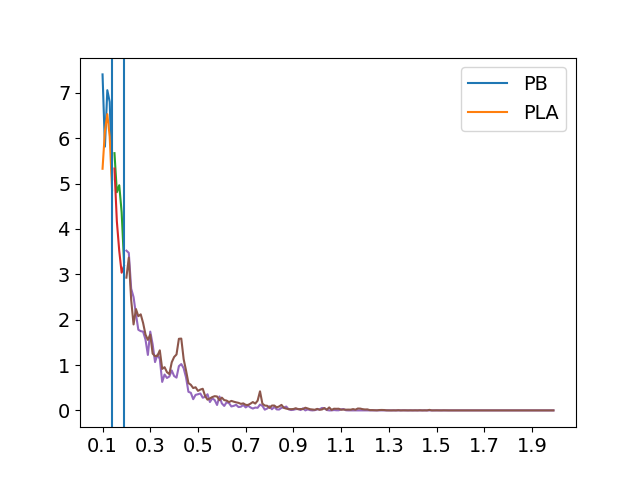

In [46]:
plt.figure()
end_index_0 = 5
end_index_1 = 5

plt.plot(edges_pb[:end_index_0],percentage_pb[:end_index_0])
plt.plot(edges_pla[:end_index_0],percentage_pla[:end_index_0])

plt.axvline(edges_pb[end_index_0-1])

plt.plot(edges_pb[end_index_0:end_index_0+end_index_1],percentage_pb[end_index_0:end_index_0+end_index_1])
plt.plot(edges_pla[end_index_0:end_index_0+end_index_1],percentage_pla[end_index_0:end_index_0+end_index_1])

plt.axvline(edges_pb[end_index_0+end_index_1-1])

plt.plot(edges_pb[end_index_0+end_index_1:-1],percentage_pb[end_index_0+end_index_1:])
plt.plot(edges_pla[end_index_0+end_index_1:-1],percentage_pla[end_index_0+end_index_1:])

plt.xticks(np.arange(bin_low, bin_up, 0.2))
plt.legend(['PB', 'PLA'])


X_pb_0 = np.column_stack((edges_pb[:end_index_0],percentage_pb[:end_index_0]))
X_pla_0 = np.column_stack((edges_pla[:end_index_0],percentage_pla[:end_index_0]))

X_pb_1 = np.column_stack((edges_pb[end_index_0:end_index_0+end_index_1],percentage_pb[end_index_0:end_index_0+end_index_1]))
X_pla_1 = np.column_stack((edges_pla[end_index_0:end_index_0+end_index_1],percentage_pla[end_index_0:end_index_0+end_index_1]))

X_pb_2 = np.column_stack((edges_pb[end_index_0+end_index_1:-1],percentage_pb[end_index_0+end_index_1:]))
X_pla_2 = np.column_stack((edges_pla[end_index_0+end_index_1:-1],percentage_pla[end_index_0+end_index_1:]))




Automatically created module for IPython interactive environment


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


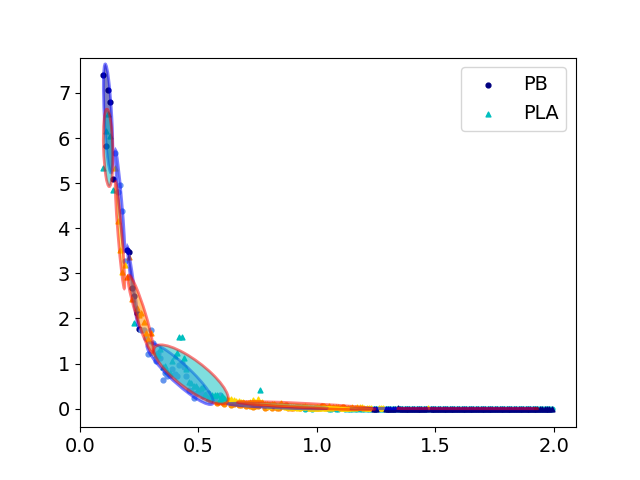

In [47]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

color_iter_PB = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                                 'darkorange'])
color_iter_PLA = color_iter_PB


def plot_results(splot, X, Y, means, covariances, index, title,color_iter,marker,linestyle,Ellipse_color):
#     splot = plt.subplot(5, 1, 1 + index)
    
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        splot.scatter(X[Y == i, 0], X[Y == i, 1], s=12, color=color, marker=marker)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, 
                                  facecolor=color,
                                  edgecolor=Ellipse_color,
                                  linestyle=linestyle,
                                  linewidth=2)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    #splot.xlim(-6., 4. * np.pi - 6.)
    #splot.set_ylim(0, 20)
    #splot.set_title(title)
    splot.legend(['PB','PLA'])
    #plt.title(title)
    #plt.xticks(())
    #plt.yticks(())

plt.figure()
splot = plt.subplot(1, 1, 1)
X = X_pb_0
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PB,'o','-','b')

X = X_pla_0
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PLA,'^','-','r')

# plt.figure()
# splot = plt.subplot(1, 1, 1)
X = X_pb_1
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PB,'o','-','b')

X = X_pla_1
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PLA,'^','-','r')

# plt.figure()
# splot = plt.subplot(1, 1, 1)
X = X_pb_2
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full',
                              max_iter=200).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PB,'o','-','b')

X = X_pla_2
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full',
                              max_iter=200).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PLA,'^','-','r')



plt.show()

In [48]:
bin_low = 0.1#0.1#0
bin_up = 2
bin_step = 0.01
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.1

# Prescribed Behavior
reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
results_pb, edges_pb = np.histogram(hist_data_pb, bins)
percentage_pb = (results_pb / sum(results_pb)) * 100


# Parameterized Learning Agent
reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
results_pla, edges_pla = np.histogram(hist_data_pla, bins)
percentage_pla = (results_pla / sum(results_pla)) * 100

In [49]:
edges_pla[end_index_0]

0.14999999999999997

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


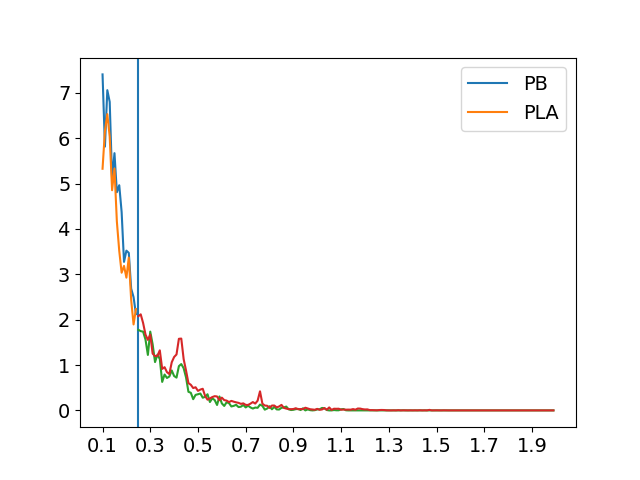

In [50]:
plt.figure()
end_index_0 = 15


plt.plot(edges_pb[:end_index_0],percentage_pb[:end_index_0])
plt.plot(edges_pla[:end_index_0],percentage_pla[:end_index_0])

plt.axvline(edges_pb[end_index_0])

plt.plot(edges_pb[end_index_0:-1],percentage_pb[end_index_0:])
plt.plot(edges_pla[end_index_0:-1],percentage_pla[end_index_0:])

plt.xticks(np.arange(bin_low, bin_up, 0.2))
plt.legend(['PB', 'PLA'])


X_pb_0 = np.column_stack((edges_pb[:end_index_0],percentage_pb[:end_index_0]))
X_pla_0 = np.column_stack((edges_pla[:end_index_0],percentage_pla[:end_index_0]))

X_pb_2 = np.column_stack((edges_pb[end_index_0:-1],percentage_pb[end_index_0:]))
X_pla_2 = np.column_stack((edges_pla[end_index_0:-1],percentage_pla[end_index_0:]))


Automatically created module for IPython interactive environment


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


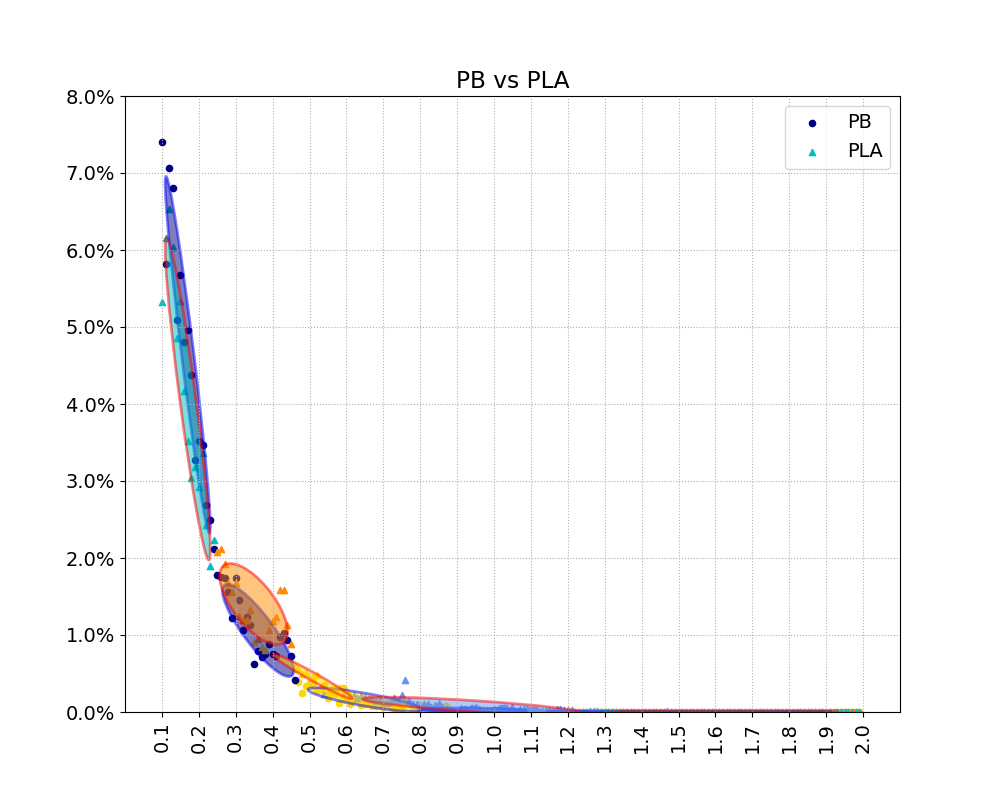

In [51]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

print(__doc__)

color_iter_PB = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                                 'darkorange'])
color_iter_PLA = color_iter_PB


def plot_results(splot, X, Y, means, covariances, index, title,color_iter,marker,linestyle,Ellipse_color):
#     splot = plt.subplot(5, 1, 1 + index)
    
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        splot.scatter(X[Y == i, 0], X[Y == i, 1], s=20, color=color, marker=marker)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, 
                                  facecolor=color,
                                  edgecolor=Ellipse_color,
                                  linestyle=linestyle,
                                  linewidth=2)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    

plt.figure(figsize=(10,8))
splot = plt.subplot(1, 1, 1)
########################################################################
X = X_pb_0
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PB,'o','-','b')

X = X_pla_0
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PLA,'^','-','r')


# plt.figure()
# splot = plt.subplot(1, 1, 1)
X = X_pb_2
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full',
                              max_iter=400).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PB,'o','-','b')

X = X_pla_2
# Fit a Gaussian mixture with EM using ten components
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full',
                              max_iter=400).fit(X)
plot_results(splot, X, gmm.predict(X), gmm.means_, gmm.covariances_, 0,
             'PB vs PLA',color_iter_PLA,'^','-','r')
########################################################################

plt.xlim(bin_low-0.1, bin_up+0.1)

plt.ylim(0, 8)
#splot.set_title(title)
plt.legend(['PB','PLA'])
plt.title('PB vs PLA')
plt.grid(True, linestyle=':')
plt.xticks(np.arange(bin_low, bin_up+0.001, 0.1), rotation=90)
ax = plt.gca()
ax.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax.get_yticks()])
#plt.yticks(())

plt.show()

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


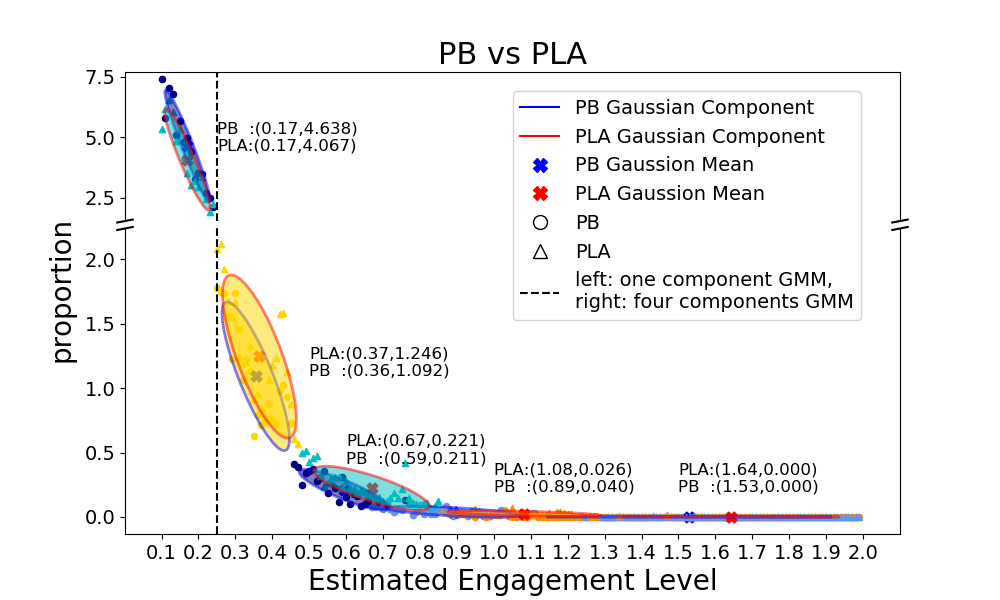

[0.17       4.63766541]
[0.17       4.06671784]
[0.8894509  0.04040433]
[0.35510642 1.09165619]
[1.52878848e+00 8.90492034e-05]
[0.59418689 0.21105783]
[0.66870842 0.22119813]
[1.64225505e+00 3.33286500e-04]
[0.36510394 1.2456663 ]
[1.08139686 0.02599565]


In [52]:
import matplotlib.gridspec as gridspec
def plot_results(splot, X, Y, means, covariances, index, title,color_iter,marker,linestyle,Ellipse_color,behavior):
#     splot = plt.subplot(5, 1, 1 + index)
    
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        splot.scatter(X[Y == i, 0], X[Y == i, 1], s=20, color=color, marker=marker)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, 
                                  facecolor=color,
                                  edgecolor=Ellipse_color,
                                  linestyle=linestyle,
                                  linewidth=2)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        # Plot means
        splot.scatter(mean[0], mean[1], s=60, color=Ellipse_color, marker='X',linewidths=1)
        print(mean)

from matplotlib.lines import Line2D
from matplotlib.patches import Circle
# Plot figure with subplots of different sizes
fig = plt.figure(figsize=(10,6))
# set up subplot grid
gs = gridspec.GridSpec(3,1,hspace=0.05)
ax= plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1:,:])
ax.axvline(edges_pb[end_index_0],linestyle='--',color='k')
ax2.axvline(edges_pb[end_index_0],linestyle='--',color='k')

# Up plot
X = X_pb_0
# Fit a Gaussian mixture with EM using ten components
gmm_pb_0 = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(ax, X, gmm_pb_0.predict(X), gmm_pb_0.means_, gmm_pb_0.covariances_, 0,
             'PB vs PLA',color_iter_PB,'o','-','b','PB')

X = X_pla_0
# Fit a Gaussian mixture with EM using ten components
gmm_pla_0 = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(ax, X, gmm_pla_0.predict(X), gmm_pla_0.means_, gmm_pla_0.covariances_, 0,
             'PB vs PLA',color_iter_PLA,'^','-','r','PLA')

text_x = [0.25]
text_y = [5]
for i in range(len(gmm_pb_0.means_)):
    ax.text(text_x[i], text_y[i], 
            '{:4s}:({:.2f},{:.3f})\n{:3s}:({:.2f},{:.3f})'.format('PB', 
                                                                  gmm_pb_0.means_[i][0], 
                                                                  gmm_pb_0.means_[i][1],
                                                                  'PLA',
                                                                  gmm_pla_0.means_[i][0],
                                                                  gmm_pla_0.means_[i][1]),
            rotation=0, fontsize=12,horizontalalignment='left',verticalalignment='center')
# Down plot
X = X_pb_2
# Fit a Gaussian mixture with EM using ten components
gmm_pb_2 = mixture.GaussianMixture(n_components=4, covariance_type='full',
                              max_iter=400).fit(X)
plot_results(ax2, X, gmm_pb_2.predict(X), gmm_pb_2.means_, gmm_pb_2.covariances_, 0,
             'PB vs PLA',color_iter_PB,'o','-','b','PB')

X = X_pla_2
# Fit a Gaussian mixture with EM using ten components
gmm_pla_2 = mixture.GaussianMixture(n_components=4, covariance_type='full',
                              max_iter=400).fit(X)
plot_results(ax2, X, gmm_pla_2.predict(X), gmm_pla_2.means_, gmm_pla_2.covariances_, 0,
             'PB vs PLA',color_iter_PLA,'^','-','r','PLA')

gmm_pb_2.means_ = gmm_pb_2.means_[gmm_pb_2.means_[:,0].argsort()]
gmm_pla_2.means_ = gmm_pla_2.means_[gmm_pla_2.means_[:,0].argsort()]
text_x = [0.5, 0.6, 1.0, 1.5]
text_y = [1.2, 0.52, 0.3, 0.3]
for i in range(len(gmm_pb_2.means_)):
    ax2.text(text_x[i], text_y[i],
            '{:3s}:({:.2f},{:.3f})\n{:4s}:({:.2f},{:.3f})'.format('PLA',
                                                                  gmm_pla_2.means_[i][0],
                                                                  gmm_pla_2.means_[i][1],
                                                                  'PB', 
                                                                  gmm_pb_2.means_[i][0], 
                                                                  gmm_pb_2.means_[i][1]),
            rotation=0, fontsize=12,horizontalalignment='left',verticalalignment='center')

# set x-axis
ax.set_xlim(bin_low-0.099, bin_up+0.1)
ax2.set_xlim(bin_low-0.099, bin_up+0.1)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

d = .01
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-right diagonal

ax.get_xaxis().set_visible(False)
ax2.set_xticks(np.arange(bin_low, bin_up+0.001, 0.1))

legend_elements = [Line2D([0], [0], color='b', label='PB Gaussian Component'),
                   Line2D([0], [0], color='r', label='PLA Gaussian Component'), 
                   Line2D([0], [0], marker='X', color='b', label='PB Gaussion Mean',linestyle = 'None',
                          markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='X', color='r', label='PLA Gaussion Mean',linestyle = 'None',
                          markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='black', label='PB',
                          markerfacecolor='w', markersize=10,linestyle = 'None'),
                   Line2D([0], [0], marker='^', color='black', label='PLA',linestyle = 'None',
                          markerfacecolor='w', markersize=10),
                   Line2D([0], [0], color='black', label='left: one component GMM, \nright: four components GMM',
                          linestyle = '--', markerfacecolor='w', markersize=10)]
ax2.legend(handles=legend_elements, loc=(0.5,0.7))
ax.set_title('PB vs PLA', fontsize=22)
ax2.set_xlabel('Estimated Engagement Level', fontsize=20)
ax2.set_ylabel('proportion', verticalalignment='top', fontsize=20)
ax2.yaxis.set_label_coords(-0.1,0.8)
plt.savefig('./figures/plot_gaussian_mixture_regression_on_estimated_engagement_level_distribution_in_range_0_1_2_{}_{}.png'.format('PB','PLA'), dpi=300)


In [53]:
gmm_pb_2.means_[gmm_pb_2.means_[:,0].argsort()]

array([[3.55106421e-01, 1.09165619e+00],
       [5.94186890e-01, 2.11057832e-01],
       [8.89450899e-01, 4.04043263e-02],
       [1.52878848e+00, 8.90492034e-05]])

In [54]:
gmm_pla_2.means_[gmm_pla_2.means_[:,0].argsort()]

array([[3.65103940e-01, 1.24566630e+00],
       [6.68708416e-01, 2.21198131e-01],
       [1.08139686e+00, 2.59956452e-02],
       [1.64225505e+00, 3.33286500e-04]])

## SARA and ACRA 

In [55]:
bin_low = 0.1#0.1#0
bin_up = 2
bin_step = 0.01
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.1

# Prescribed Behavior
reward_data_sara = single_agent_raw_act['data']['reward_IR_distance'].astype(float).values
reward_data_sara = reward_data_sara[reward_data_sara!=0] # remove 0
hist_data_sara = reward_data_sara[reward_data_sara>=bin_low]
hist_data_sara = hist_data_sara[hist_data_sara<bin_up]
results_sara, edges_sara = np.histogram(hist_data_sara, bins)
percentage_sara = (results_sara / sum(results_sara)) * 100


# Parameterized Learning Agent
reward_data_acra = agent_coummunity_raw_act['data']['reward_IR_distance'].astype(float).values
reward_data_acra = reward_data_acra[reward_data_acra!=0] # remove 0
hist_data_acra = reward_data_acra[reward_data_acra>=bin_low]
hist_data_acra = hist_data_acra[hist_data_acra<bin_up]
results_acra, edges_acra = np.histogram(hist_data_acra, bins)
percentage_acra = (results_acra / sum(results_acra)) * 100

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


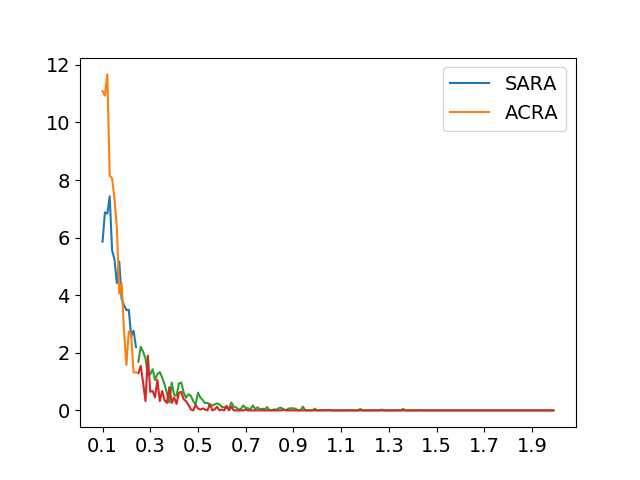

In [56]:
plt.figure()
end_index_0 = 15


plt.plot(edges_sara[:end_index_0],percentage_sara[:end_index_0])
plt.plot(edges_acra[:end_index_0],percentage_acra[:end_index_0])

plt.plot(edges_sara[end_index_0:-1],percentage_sara[end_index_0:])
plt.plot(edges_acra[end_index_0:-1],percentage_acra[end_index_0:])

plt.xticks(np.arange(bin_low, bin_up, 0.2))
plt.legend(['SARA', 'ACRA'])


X_sara_0 = np.column_stack((edges_sara[:end_index_0],percentage_sara[:end_index_0]))
X_acra_0 = np.column_stack((edges_acra[:end_index_0],percentage_acra[:end_index_0]))

X_sara_2 = np.column_stack((edges_sara[end_index_0:-1],percentage_sara[end_index_0:]))
X_acra_2 = np.column_stack((edges_acra[end_index_0:-1],percentage_acra[end_index_0:]))



/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


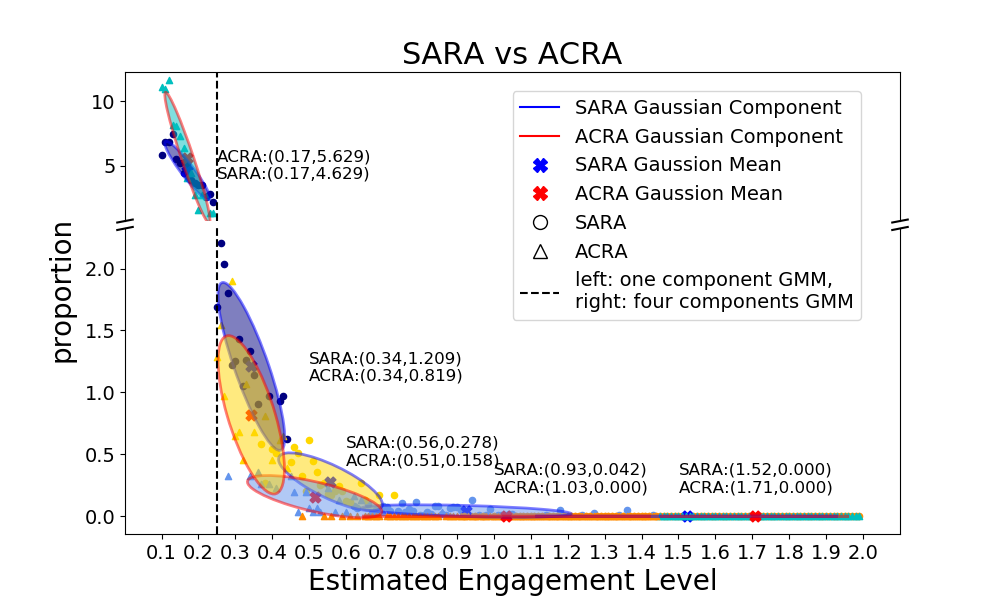

[0.17       4.62941738]
[0.17       5.62862669]
[0.92578327 0.04225819]
[0.55747154 0.27789038]
[1.52203915e+00 9.50058876e-13]
[0.34324961 1.20941903]
[1.70633666e+000 2.05905846e-230]
[0.51449484 0.15842264]
[0.34288489 0.81892791]
[1.03374318e+000 8.61417867e-226]


In [57]:
def plot_results(splot, X, Y, means, covariances, index, title,color_iter,marker,linestyle,Ellipse_color,behavior):
#     splot = plt.subplot(5, 1, 1 + index)
    
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        splot.scatter(X[Y == i, 0], X[Y == i, 1], s=20, color=color, marker=marker)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, 
                                  facecolor=color,
                                  edgecolor=Ellipse_color,
                                  linestyle=linestyle,
                                  linewidth=2)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        # Plot means
        splot.scatter(mean[0], mean[1], s=60, color=Ellipse_color, marker='X',linewidths=1)
        print(mean)

from matplotlib.lines import Line2D
from matplotlib.patches import Circle
# Plot figure with subplots of different sizes
fig = plt.figure(figsize=(10,6))
# set up subplot grid
gs = gridspec.GridSpec(3,1,hspace=0.05)
ax= plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1:,:])
ax.axvline(edges_sara[end_index_0],linestyle='--',color='k')
ax2.axvline(edges_sara[end_index_0],linestyle='--',color='k')

# Up plot
X = X_sara_0
# Fit a Gaussian mixture with EM using ten components
gmm_sara_0 = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(ax, X, gmm_sara_0.predict(X), gmm_sara_0.means_, gmm_sara_0.covariances_, 0,
             'SARA vs ACRA',color_iter_PB,'o','-','b','SARA')

X = X_acra_0
# Fit a Gaussian mixture with EM using ten components
gmm_acra_0 = mixture.GaussianMixture(n_components=1, covariance_type='full',
                              max_iter=100).fit(X)
plot_results(ax, X, gmm_acra_0.predict(X), gmm_acra_0.means_, gmm_acra_0.covariances_, 0,
             'SARA vs ACRA',color_iter_PLA,'^','-','r','ACRA')

text_x = [0.25]
text_y = [5]
for i in range(len(gmm_acra_0.means_)):
    ax.text(text_x[i], text_y[i], 
            '{:4s}:({:.2f},{:.3f})\n{:3s}:({:.2f},{:.3f})'.format('ACRA',
                                                                  gmm_acra_0.means_[i][0],
                                                                  gmm_acra_0.means_[i][1],
                                                                  'SARA', 
                                                                  gmm_sara_0.means_[i][0], 
                                                                  gmm_sara_0.means_[i][1]),
            rotation=0, fontsize=12,horizontalalignment='left',verticalalignment='center')
# Down plot
X = X_sara_2
# Fit a Gaussian mixture with EM using ten components
gmm_sara_2 = mixture.GaussianMixture(n_components=4, covariance_type='full',
                              max_iter=400).fit(X)
plot_results(ax2, X, gmm_sara_2.predict(X), gmm_sara_2.means_, gmm_sara_2.covariances_, 0,
             'SARA vs ACRA',color_iter_PB,'o','-','b','SARA')

X = X_acra_2
# Fit a Gaussian mixture with EM using ten components
gmm_acra_2 = mixture.GaussianMixture(n_components=4, covariance_type='full',
                              max_iter=400).fit(X)
plot_results(ax2, X, gmm_acra_2.predict(X), gmm_acra_2.means_, gmm_acra_2.covariances_, 0,
             'SARA vs ACRA',color_iter_PLA,'^','-','r','ACRA')

gmm_sara_2.means_ = gmm_sara_2.means_[gmm_sara_2.means_[:,0].argsort()]
gmm_acra_2.means_ = gmm_acra_2.means_[gmm_acra_2.means_[:,0].argsort()]
text_x = [0.5, 0.6, 1.0, 1.5]
text_y = [1.2, 0.52, 0.3, 0.3]
for i in range(len(gmm_sara_2.means_)):
    ax2.text(text_x[i], text_y[i],
            '{:3s}:({:.2f},{:.3f})\n{:4s}:({:.2f},{:.3f})'.format('SARA', 
                                                                  gmm_sara_2.means_[i][0], 
                                                                  gmm_sara_2.means_[i][1],
                                                                  'ACRA',
                                                                  gmm_acra_2.means_[i][0],
                                                                  gmm_acra_2.means_[i][1]),
            rotation=0, fontsize=12,horizontalalignment='left',verticalalignment='center')

# set x-axis
ax.set_xlim(bin_low-0.099, bin_up+0.1)
ax2.set_xlim(bin_low-0.099, bin_up+0.1)
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

d = .01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

d = .01
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-right diagonal

ax.get_xaxis().set_visible(False)
ax2.set_xticks(np.arange(bin_low, bin_up+0.001, 0.1))

legend_elements = [Line2D([0], [0], color='b', label='SARA Gaussian Component'),
                   Line2D([0], [0], color='r', label='ACRA Gaussian Component'), 
                   Line2D([0], [0], marker='X', color='b', label='SARA Gaussion Mean',linestyle = 'None',
                          markerfacecolor='b', markersize=10),
                   Line2D([0], [0], marker='X', color='r', label='ACRA Gaussion Mean',linestyle = 'None',
                          markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='black', label='SARA',
                          markerfacecolor='w', markersize=10,linestyle = 'None'),
                   Line2D([0], [0], marker='^', color='black', label='ACRA',linestyle = 'None',
                          markerfacecolor='w', markersize=10),
                   Line2D([0], [0], color='black', label='left: one component GMM, \nright: four components GMM',
                          linestyle = '--', markerfacecolor='w', markersize=10)]
ax2.legend(handles=legend_elements, loc=(0.5,0.7))
ax.set_title('SARA vs ACRA', fontsize=22)
ax2.set_xlabel('Estimated Engagement Level', fontsize=20)
ax2.set_ylabel('proportion', verticalalignment='top', fontsize=20)
ax2.yaxis.set_label_coords(-0.1,0.8)
plt.savefig('./figures/plot_gaussian_mixture_regression_on_estimated_engagement_level_distribution_in_range_0_1_2_{}_{}.png'.format('SARA','ACRA'), dpi=300)



# Plot Reward distribution with broken axis

In [112]:
bin_low = 0
bin_up = 1.6
bin_step = 0.02
bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
binWidth = 0.04

# Prescribed Behavior
reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
results_pb, edges_pb = np.histogram(hist_data_pb, bins)
percentage_pb = (results_pb / sum(results_pb)) * 100

# Parameterized Learning Agent
reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
results_pla, edges_pla = np.histogram(hist_data_pla, bins)
percentage_pla = (results_pla / sum(results_pla)) * 100

# Calculate KS-test
from scipy import stats
KS_percentage_PB_PLA, p_percentage_PB_PLA = stats.ks_2samp(percentage_pb, percentage_pla)
KS_decimal_PB_PLA, p_decimal_PB_PLA = stats.ks_2samp(results_pb, results_pla)
print('KS_percentage_{0}_{1}={2:.4f}, p_percentage_{0}_{1}={3:.4f}'.format('PB', 
                                                                           'PLA', 
                                                                           KS_percentage_PB_PLA, 
                                                                           p_percentage_PB_PLA))
print('KS_decimal_{0}_{1}={2:.4f}, p_decimal_{0}_{1}={3:.4f}'.format('PB', 
                                                                     'PLA', 
                                                                     KS_decimal_PB_PLA, 
                                                                     p_decimal_PB_PLA))

# Calculate t-test
KS_percentage_PB_PLA, p_percentage_PB_PLA = stats.ttest_ind(percentage_pb, percentage_pla)
KS_decimal_PB_PLA, p_decimal_PB_PLA = stats.ttest_ind(results_pb, results_pla)
print('KS_percentage_{0}_{1}={2:.4f}, p_percentage_{0}_{1}={3:.4f}'.format('PB', 
                                                                           'PLA', 
                                                                           KS_percentage_PB_PLA, 
                                                                           p_percentage_PB_PLA))
print('KS_decimal_{0}_{1}={2:.4f}, p_decimal_{0}_{1}={3:.4f}'.format('PB', 
                                                                     'PLA', 
                                                                     KS_decimal_PB_PLA, 
                                                                     p_decimal_PB_PLA))

#
# Calculate t-test
KS_percentage_PB_PLA, p_percentage_PB_PLA = stats.ttest_ind(percentage_pb, percentage_pla, equal_var=False)
KS_decimal_PB_PLA, p_decimal_PB_PLA = stats.ttest_ind(results_pb, results_pla, equal_var=False)
print('KS_percentage_{0}_{1}={2:.4f}, p_percentage_{0}_{1}={3:.4f}'.format('PB', 
                                                                           'PLA', 
                                                                           KS_percentage_PB_PLA, 
                                                                           p_percentage_PB_PLA))
print('KS_decimal_{0}_{1}={2:.4f}, p_decimal_{0}_{1}={3:.4f}'.format('PB', 
                                                                     'PLA', 
                                                                     KS_decimal_PB_PLA, 
                                                                     p_decimal_PB_PLA))


KS_percentage_PB_PLA=0.2375, p_percentage_PB_PLA=0.0180
KS_decimal_PB_PLA=0.2375, p_decimal_PB_PLA=0.0180
KS_percentage_PB_PLA=0.0000, p_percentage_PB_PLA=1.0000
KS_decimal_PB_PLA=-0.4403, p_decimal_PB_PLA=0.6603
KS_percentage_PB_PLA=0.0000, p_percentage_PB_PLA=1.0000
KS_decimal_PB_PLA=-0.4403, p_decimal_PB_PLA=0.6604


KS_percentage_PB_PLA=0.2375, p_percentage_PB_PLA=0.0180
KS_decimal_PB_PLA=0.2375, p_decimal_PB_PLA=0.0180


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


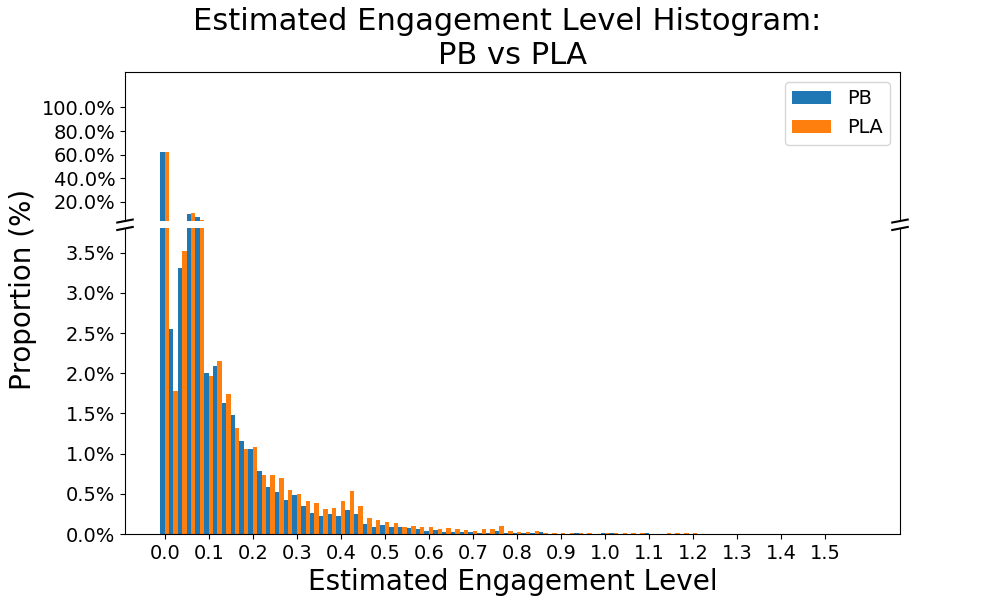

KS_percentage_SARA_ACRA=0.3125, p_percentage_SARA_ACRA=0.0006
KS_decimal_SARA_ACRA=0.3125, p_decimal_SARA_ACRA=0.0006


<IPython.core.display.Javascript object>


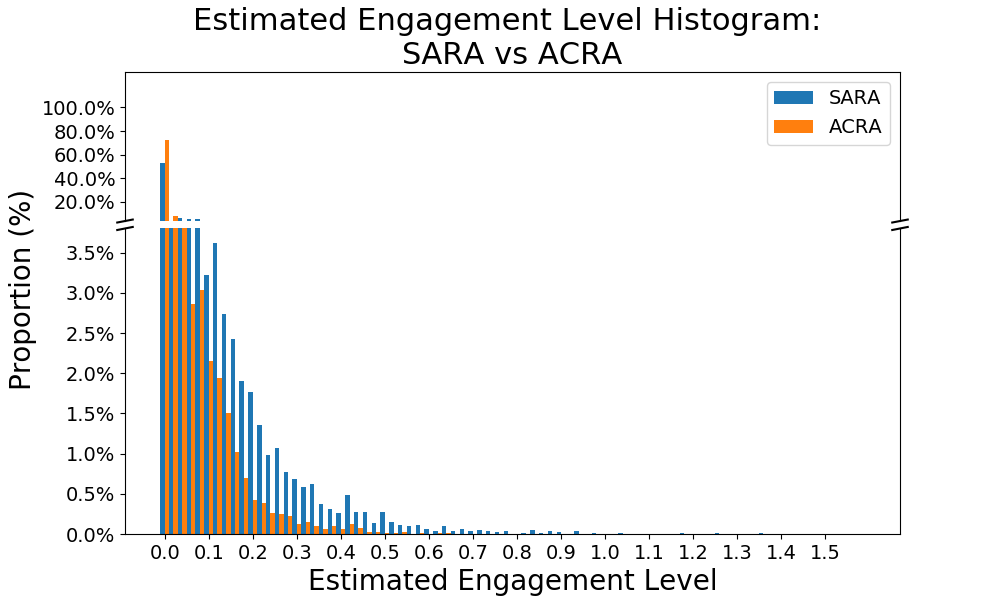

In [59]:
import matplotlib.gridspec as gridspec

def plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                             behavior_name1='PB',behavior_name2='PLA',
                             reward_low = 0, reward_up = 2):

    
    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.02
    bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
    binWidth = 0.01

    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100
    
    # Calculate KS-test
    from scipy import stats
    KS_percentage_PB_PLA, p_percentage_PB_PLA = stats.ks_2samp(percentage_pb, percentage_pla)
    KS_decimal_PB_PLA, p_decimal_PB_PLA = stats.ks_2samp(results_pb, results_pla)
    print('KS_percentage_{0}_{1}={2:.4f}, p_percentage_{0}_{1}={3:.4f}'.format(behavior_name1, 
                                                                               behavior_name2, 
                                                                               KS_percentage_PB_PLA, 
                                                                               p_percentage_PB_PLA))
    print('KS_decimal_{0}_{1}={2:.4f}, p_decimal_{0}_{1}={3:.4f}'.format(behavior_name1, 
                                                                         behavior_name2, 
                                                                         KS_decimal_PB_PLA, 
                                                                         p_decimal_PB_PLA))


    # Plot figure with subplots of different sizes
    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gs = gridspec.GridSpec(3,1,hspace=0.05)
    ax= plt.subplot(gs[0,:])
    ax2 = plt.subplot(gs[1:,:])

    ax.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth)
    ax.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth)
    ax.legend([behavior_name1, behavior_name2])
    
    ax2.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth)
    ax2.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth)
    
    # set y-axis
    if behavior_name1=='PB':
        ax_y_min = 3.8
    else:
        ax_y_min = 3.8
    ax.set_ylim(ax_y_min, 130)  # outliers only
    ax2.set_ylim(0, ax_y_min)  # most of the data

    ax.set_yticks(np.arange(20, 105, 20))
    ax2.set_yticks(np.arange(0, ax_y_min, 0.5))
    
    ax.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax.get_yticks()])
    ax2.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax2.get_yticks()])
    
    # set x-axis
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    d = .01  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    d = .01
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-right diagonal

    ax.get_xaxis().set_visible(False)
    ax2.set_xticks(np.arange(reward_low, reward_up,0.1))
                                   

    ax.set_title('Estimated Engagement Level Histogram: \n{} vs {}'.format(behavior_name1, behavior_name2), fontsize=22)
    ax2.set_xlabel('Estimated Engagement Level', fontsize=20)
    ax2.set_ylabel('Proportion (%)', verticalalignment='top', fontsize=20)
    ax2.yaxis.set_label_coords(-0.15,0.8)
    plt.savefig('./figures/plot_estimated_engagement_level_distribution_in_range_0_1_6_{}_{}.png'.format(behavior_name1,behavior_name2), dpi=300)

    
plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                         behavior_name1='PB',behavior_name2='PLA',
                         reward_low = 0, reward_up = 1.6)

plot_reward_distribution(single_agent_raw_act, agent_coummunity_raw_act, 
                         behavior_name1='SARA',behavior_name2='ACRA',
                         reward_low = 0, reward_up = 1.6)

# plot_reward_distribution(PB_PLA, SARA_ACRA, 
#                          behavior_name1='PB&PLA',behavior_name2='SARA&ACRA',
#                          reward_low = 0, reward_up = 2)


https://matplotlib.org/examples/pylab_examples/broken_axis.html

KS_percentage_PB_PLA=0.2000, p_percentage_PB_PLA=1.5419
KS_decimal_PB_PLA=0.2000, p_decimal_PB_PLA=1.5419


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


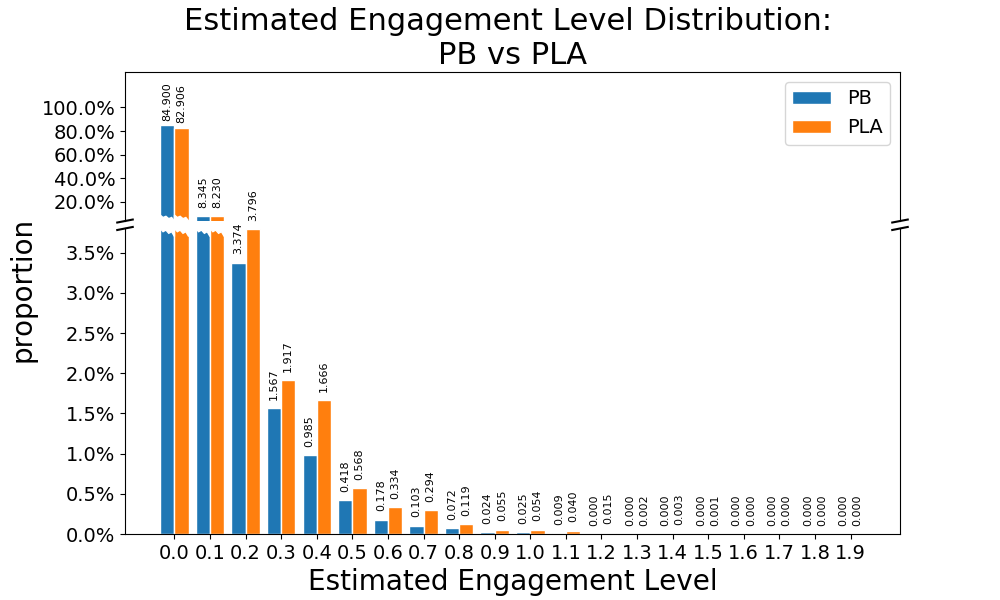

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


KS_percentage_SARA_ACRA=0.3500, p_percentage_SARA_ACRA=0.2699
KS_decimal_SARA_ACRA=0.3500, p_decimal_SARA_ACRA=0.2699


<IPython.core.display.Javascript object>


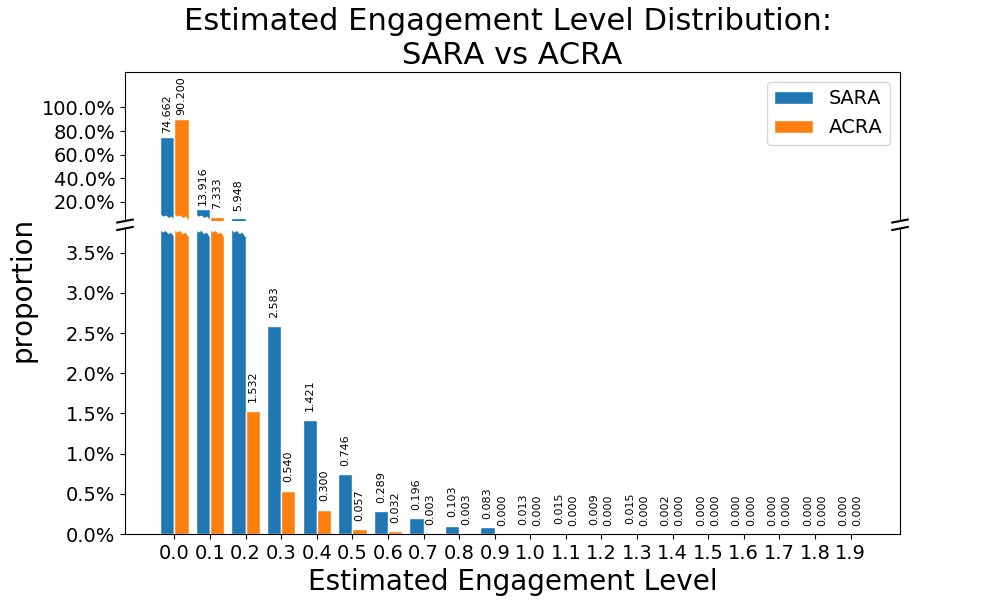

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [60]:
import matplotlib.gridspec as gridspec

def plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                             behavior_name1='PB',behavior_name2='PLA',
                             reward_low = 0, reward_up = 2):

    
    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.1
    bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
    binWidth = 0.04

    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100
    
    # Calculate KS-test
    from scipy import stats
    KS_percentage_PB_PLA, p_percentage_PB_PLA = stats.ks_2samp(percentage_pb, percentage_pla)
    KS_decimal_PB_PLA, p_decimal_PB_PLA = stats.ks_2samp(results_pb, results_pla)
    print('KS_percentage_{0}_{1}={2:.4f}, p_percentage_{0}_{1}={3:.4f}'.format(behavior_name1, 
                                                                               behavior_name2, 
                                                                               KS_percentage_PB_PLA, 
                                                                               p_percentage_PB_PLA*2))
    print('KS_decimal_{0}_{1}={2:.4f}, p_decimal_{0}_{1}={3:.4f}'.format(behavior_name1, 
                                                                         behavior_name2, 
                                                                         KS_decimal_PB_PLA, 
                                                                         p_decimal_PB_PLA*2))


    # Plot figure with subplots of different sizes
    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gs = gridspec.GridSpec(3,1,hspace=0.05)
    ax= plt.subplot(gs[0,:])
    ax2 = plt.subplot(gs[1:,:])

    ax.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    ax.legend([behavior_name1, behavior_name2])
    
    ax2.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax2.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    
    # set y-axis
    if behavior_name1=='PB':
        ax_y_min = 3.8
    else:
        ax_y_min = 3.8
    ax.set_ylim(ax_y_min, 130)  # outliers only
    ax2.set_ylim(0, ax_y_min)  # most of the data

    ax.set_yticks(np.arange(20, 105, 20))
    ax2.set_yticks(np.arange(0, ax_y_min, 0.5))
    
    ax.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax.get_yticks()])
    ax2.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax2.get_yticks()])
    
    # set x-axis
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    d = .01  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    d = .01
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-right diagonal

    ax.get_xaxis().set_visible(False)
    ax2.set_xticks(np.arange(reward_low, reward_up,0.1))

    

    # add proportion text
    rotation = 90
    fontsize=8
    if reward_low ==0:
        text_x_ax = [0, 0.1]
    else:
        text_x_ax = []
    for i in range(len(text_x_ax)):
        ax.text(text_x_ax[i]-binWidth/2, percentage_pb[i]+20, '{0:.3f}'.format(percentage_pb[i]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        ax.text(text_x_ax[i]+binWidth/2, percentage_pla[i]+20, '{0:.3f}'.format(percentage_pla[i]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
    
    if behavior_name1=='PB':
        shift = 0.3
    else:
        shift = 0.3
    text_x_ax2 = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
    for i in range(len(text_x_ax2)):
        if behavior_name1!='PB' and i==0:
            tmp_shift = 20
            ax.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+tmp_shift, 
                    '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
                    rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        else:
            ax2.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+shift, 
                    '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
                    rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')

        ax2.text(text_x_ax2[i]+binWidth/2, percentage_pla[i+len(text_x_ax)]+shift, 
                '{0:.3f}'.format(percentage_pla[i+len(text_x_ax)]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')

    # add broken wave to ax
    ax_bins=[0, 0.1]
    wave_high = 5
    wave_start = i-binWidth
    wave_end = i+binWidth
    for i in ax_bins:
        if i == 0.1 and behavior_name1!='PB':
            tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                       [i-binWidth,ax_y_min+wave_high],
                                       [i-binWidth+binWidth*1/5, ax_y_min+wave_high*3/5], 
                                       [i-binWidth+binWidth*2/5, ax_y_min+wave_high*4/5],
                                       [i-binWidth+binWidth*3/5, ax_y_min+wave_high*2/5],
                                       [i-binWidth+binWidth*4/5, ax_y_min+wave_high*3/5],
                                       [i,ax_y_min]], 
                                      color='white')
            ax.add_patch(tmp_polygon)
        else:
            if i==0.1:
                break
            tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                       [i-binWidth,ax_y_min+wave_high],
                                       [i-binWidth+binWidth*1/5, ax_y_min+wave_high*3/5], 
                                       [i-binWidth+binWidth*2/5, ax_y_min+wave_high*4/5],
                                       [i-binWidth+binWidth*3/5, ax_y_min+wave_high*2/5],
                                       [i-binWidth+binWidth*4/5, ax_y_min+wave_high*3/5],
                                       [i,ax_y_min]], 
                                      color='white')
            ax.add_patch(tmp_polygon)
            tmp_polygon = plt.Polygon([[i,ax_y_min],
                                       [i,ax_y_min+wave_high],
                                       [i+binWidth*1/5, ax_y_min+wave_high*3/5],
                                       [i+binWidth*2/5, ax_y_min+wave_high*4/5],
                                       [i+binWidth*3/5, ax_y_min+wave_high*2/5],
                                       [i+binWidth*4/5, ax_y_min+wave_high*3/5],
                                       [i+binWidth,ax_y_min]], 
                                      color='white')
            ax.add_patch(tmp_polygon)    
    
    # add broken wave to ax2
    ax2_bins=[0, 0.1, 0.2]
    wave_high = 0.1
    wave_start = i-binWidth
    wave_end = i+binWidth
    for i in ax2_bins:
        if behavior_name1!='PB' and i==0.2:
            tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                       [i-binWidth+binWidth*1/5, ax_y_min-wave_high*2/5], 
                                       [i-binWidth+binWidth*2/5, ax_y_min-wave_high*1/5],
                                       [i-binWidth+binWidth*3/5, ax_y_min-wave_high*3/5],
                                       [i-binWidth+binWidth*4/5, ax_y_min-wave_high*2/5],
                                       [i,ax_y_min-wave_high],
                                       [i,ax_y_min]], 
                                      color='white')
            ax2.add_patch(tmp_polygon)
        else:
            if i==0.2:
                break
            tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                       [i-binWidth+binWidth*1/5, ax_y_min-wave_high*2/5], 
                                       [i-binWidth+binWidth*2/5, ax_y_min-wave_high*1/5],
                                       [i-binWidth+binWidth*3/5, ax_y_min-wave_high*3/5],
                                       [i-binWidth+binWidth*4/5, ax_y_min-wave_high*2/5],
                                       [i,ax_y_min-wave_high],
                                       [i,ax_y_min]], 
                                      color='white')
            ax2.add_patch(tmp_polygon)
            tmp_polygon = plt.Polygon([[i,ax_y_min],
                                       [i+binWidth*1/5, ax_y_min-wave_high*2/5],
                                       [i+binWidth*2/5, ax_y_min-wave_high*1/5],
                                       [i+binWidth*3/5, ax_y_min-wave_high*3/5],
                                       [i+binWidth*4/5, ax_y_min-wave_high*2/5],
                                       [i+binWidth,ax_y_min-wave_high],
                                       [i+binWidth,ax_y_min]], 
                                      color='white')
            ax2.add_patch(tmp_polygon)
                                   

    ax.set_title('Estimated Engagement Level Distribution: \n{} vs {}'.format(behavior_name1, behavior_name2), fontsize=22)
    ax2.set_xlabel('Estimated Engagement Level', fontsize=20)
    ax2.set_ylabel('proportion', verticalalignment='top', fontsize=20)
    ax2.yaxis.set_label_coords(-0.15,0.8)
    fig.tight_layout()
    plt.savefig('./figures/plot_estimated_engagement_level_distribution_in_range_0_2_{}_{}.png'.format(behavior_name1,behavior_name2), dpi=300)

    
plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                         behavior_name1='PB',behavior_name2='PLA',
                         reward_low = 0, reward_up = 2)

plot_reward_distribution(single_agent_raw_act, agent_coummunity_raw_act, 
                         behavior_name1='SARA',behavior_name2='ACRA',
                         reward_low = 0, reward_up = 2)

# plot_reward_distribution(PB_PLA, SARA_ACRA, 
#                          behavior_name1='PB&PLA',behavior_name2='SARA&ACRA',
#                          reward_low = 0, reward_up = 2)
    

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


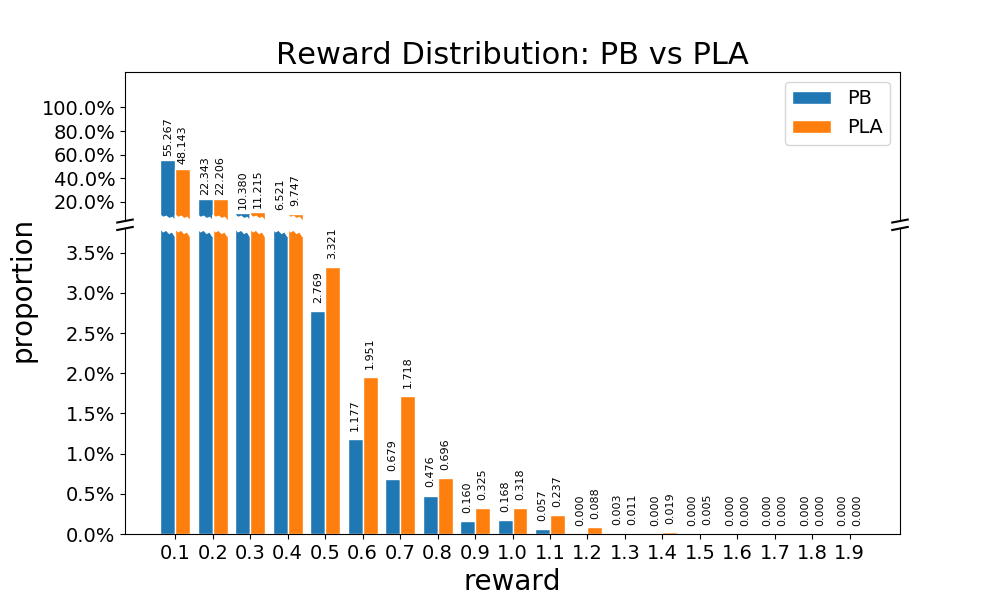

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


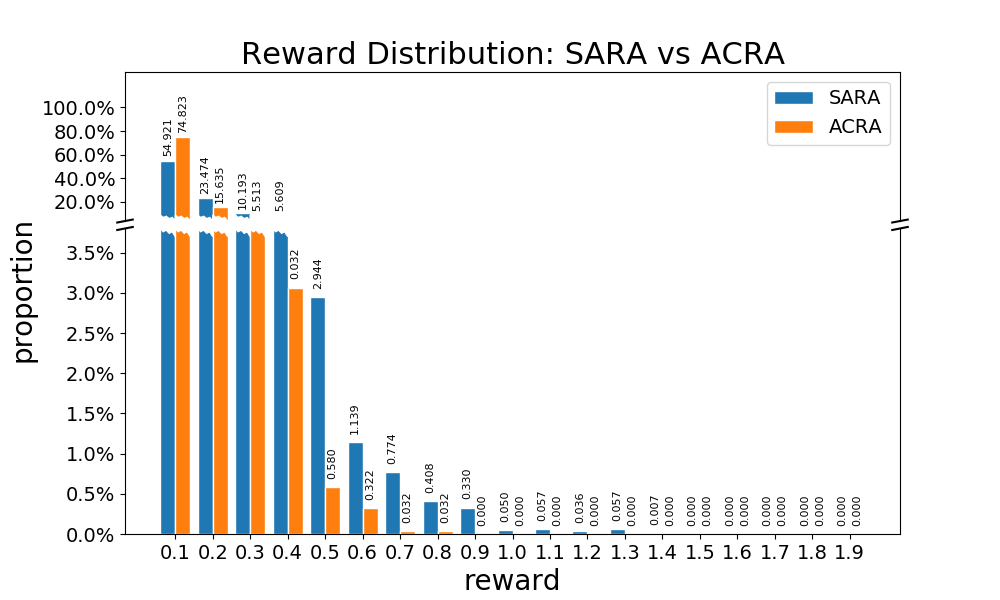

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


<IPython.core.display.Javascript object>


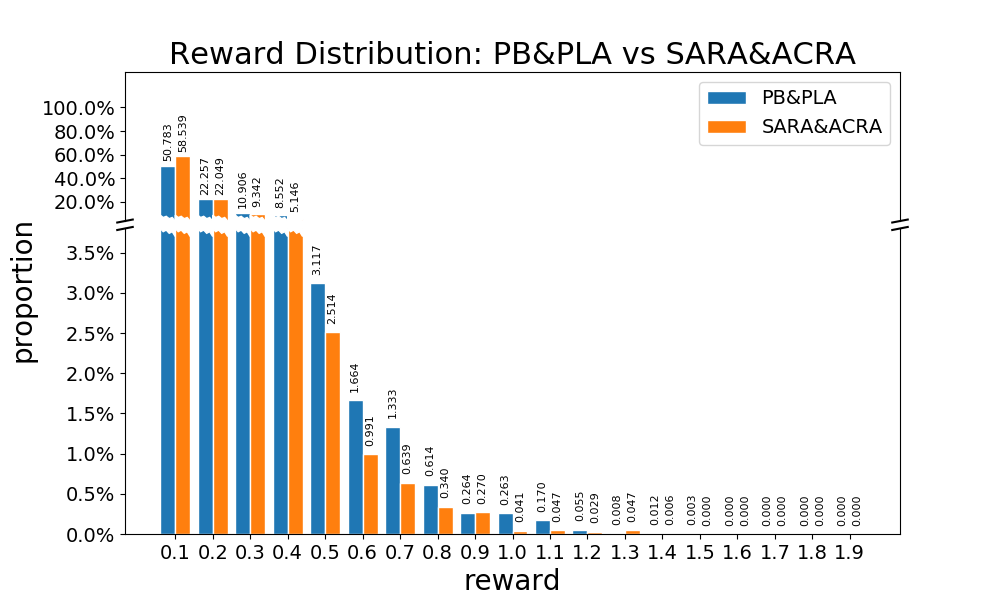

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [61]:
def plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                             behavior_name1='PB',behavior_name2='PLA',
                             reward_low = 0, reward_up = 2):

    
    bin_low = reward_low
    bin_up = reward_up
    bin_step = 0.1
    bins = np.arange(bin_low, bin_up+0.1*bin_step, bin_step)
    binWidth = 0.04

    # Prescribed Behavior
    reward_data_pb = prescribed_behavior['data']['reward_IR_distance'].astype(float).values
    reward_data_pb = reward_data_pb[reward_data_pb!=0] # remove 0
    hist_data_pb = reward_data_pb[reward_data_pb>=bin_low]
    hist_data_pb = hist_data_pb[hist_data_pb<bin_up]
    results_pb, edges_pb = np.histogram(hist_data_pb, bins)
    percentage_pb = (results_pb / sum(results_pb)) * 100

    # Parameterized Learning Agent
    reward_data_pla = para_learning_agent['data']['reward_IR_distance'].astype(float).values
    reward_data_pla = reward_data_pla[reward_data_pla!=0] # remove 0
    hist_data_pla = reward_data_pla[reward_data_pla>=bin_low]
    hist_data_pla = hist_data_pla[hist_data_pla<bin_up]
    results_pla, edges_pla = np.histogram(hist_data_pla, bins)
    percentage_pla = (results_pla / sum(results_pla)) * 100

    # Plot figure with subplots of different sizes
    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gs = gridspec.GridSpec(3,1,hspace=0.05)
    ax= plt.subplot(gs[0,:])
    ax2 = plt.subplot(gs[1:,:])

    ax.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    ax.legend([behavior_name1, behavior_name2])
    
    ax2.bar(edges_pb[:-1]-binWidth/2, percentage_pb, binWidth, edgecolor='white')
    ax2.bar(edges_pla[:-1]+binWidth/2, percentage_pla, binWidth, edgecolor='white')
    
    # set y-axis
    if behavior_name1=='PB':
        ax_y_min = 3.8
    else:
        ax_y_min = 3.8
    ax.set_ylim(ax_y_min, 130)  # outliers only
    ax2.set_ylim(0, ax_y_min)  # most of the data

    ax.set_yticks(np.arange(20, 105, 20))
    ax2.set_yticks(np.arange(0, ax_y_min, 0.5))
    
    ax.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax.get_yticks()])
    ax2.set_yticklabels(['{:.1f}%'.format(abs(x)) for x in ax2.get_yticks()])
    
    # set x-axis
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    d = .01  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    d = .01
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d/2, 1 + d/2), **kwargs)  # bottom-right diagonal

    ax.get_xaxis().set_visible(False)
    ax2.set_xticks(np.arange(reward_low, reward_up,0.1))

    

    # add proportion text
    rotation = 90
    fontsize=8
    if reward_low ==0:
        text_x_ax = [0, 0.1]
    else:
        text_x_ax = [0.1, 0.2, 0.3, 0.4]
    for i in range(len(text_x_ax)):
        ax.text(text_x_ax[i]-binWidth/2, percentage_pb[i]+20, '{0:.3f}'.format(percentage_pb[i]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        if behavior_name1=='SARA' and i==3:
            ax2.text(text_x_ax[i]+binWidth/2, percentage_pla[i]+0.3, 
                '{0:.3f}'.format(percentage_pla[i+len(text_x_ax)]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        else:
            ax.text(text_x_ax[i]+binWidth/2, percentage_pla[i]+20, '{0:.3f}'.format(percentage_pla[i]), 
                    rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
    
    if behavior_name1=='PB':
        shift = 0.3
    else:
        shift = 0.3
    text_x_ax2 = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
    
    for i in range(len(text_x_ax2)):
#         if behavior_name1=='SARA' and i==3:
#             tmp_shift = 20
#             ax.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+tmp_shift, 
#                     '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
#                     rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
#         else:
        ax2.text(text_x_ax2[i]-binWidth/2, percentage_pb[i+len(text_x_ax)]+shift, 
                '{0:.3f}'.format(percentage_pb[i+len(text_x_ax)]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')
        
        ax2.text(text_x_ax2[i]+binWidth/2, percentage_pla[i+len(text_x_ax)]+shift, 
                '{0:.3f}'.format(percentage_pla[i+len(text_x_ax)]), 
                rotation=rotation,fontsize=fontsize,horizontalalignment='center',verticalalignment='center')

    # add broken wave to ax
    ax_bins=[0.1, 0.2, 0.3, 0.4]
    wave_high = 5
    wave_start = i-binWidth
    wave_end = i+binWidth
    for i in ax_bins:
        tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                   [i-binWidth,ax_y_min+wave_high],
                                   [i-binWidth+binWidth*1/5, ax_y_min+wave_high*3/5], 
                                   [i-binWidth+binWidth*2/5, ax_y_min+wave_high*4/5],
                                   [i-binWidth+binWidth*3/5, ax_y_min+wave_high*2/5],
                                   [i-binWidth+binWidth*4/5, ax_y_min+wave_high*3/5],
                                   [i,ax_y_min]], 
                                  color='white')
        ax.add_patch(tmp_polygon)
        tmp_polygon = plt.Polygon([[i,ax_y_min],
                                   [i,ax_y_min+wave_high],
                                   [i+binWidth*1/5, ax_y_min+wave_high*3/5],
                                   [i+binWidth*2/5, ax_y_min+wave_high*4/5],
                                   [i+binWidth*3/5, ax_y_min+wave_high*2/5],
                                   [i+binWidth*4/5, ax_y_min+wave_high*3/5],
                                   [i+binWidth,ax_y_min]], 
                                  color='white')
        ax.add_patch(tmp_polygon)    
    
    # add broken wave to ax2
    ax2_bins=[0.1, 0.2, 0.3, 0.4]
    wave_high = 0.1
    wave_start = i-binWidth
    wave_end = i+binWidth
    for i in ax2_bins:
        tmp_polygon = plt.Polygon([[i-binWidth,ax_y_min],
                                   [i-binWidth+binWidth*1/5, ax_y_min-wave_high*2/5], 
                                   [i-binWidth+binWidth*2/5, ax_y_min-wave_high*1/5],
                                   [i-binWidth+binWidth*3/5, ax_y_min-wave_high*3/5],
                                   [i-binWidth+binWidth*4/5, ax_y_min-wave_high*2/5],
                                   [i,ax_y_min-wave_high],
                                   [i,ax_y_min]], 
                                  color='white')
        ax2.add_patch(tmp_polygon)
        tmp_polygon = plt.Polygon([[i,ax_y_min],
                                   [i+binWidth*1/5, ax_y_min-wave_high*2/5],
                                   [i+binWidth*2/5, ax_y_min-wave_high*1/5],
                                   [i+binWidth*3/5, ax_y_min-wave_high*3/5],
                                   [i+binWidth*4/5, ax_y_min-wave_high*2/5],
                                   [i+binWidth,ax_y_min-wave_high],
                                   [i+binWidth,ax_y_min]], 
                                  color='white')
        ax2.add_patch(tmp_polygon)
                                   

    ax.set_title('Reward Distribution: {} vs {}'.format(behavior_name1, behavior_name2), fontsize=22)
    ax2.set_xlabel('reward', fontsize=20)
    ax2.set_ylabel('proportion', verticalalignment='top', fontsize=20)
    ax2.yaxis.set_label_coords(-0.15,0.8)
    fig.tight_layout()
    plt.savefig('./figures/plot_reward_distribution_in_range_0_1_2_{}_{}.png'.format(behavior_name1,behavior_name2), dpi=300)


plot_reward_distribution(prescribed_behavior,para_learning_agent, 
                         behavior_name1='PB',behavior_name2='PLA',
                         reward_low = 0.1, reward_up = 2)

plot_reward_distribution(single_agent_raw_act, agent_coummunity_raw_act, 
                         behavior_name1='SARA',behavior_name2='ACRA',
                         reward_low = 0.1, reward_up = 2)

plot_reward_distribution(PB_PLA, SARA_ACRA, 
                         behavior_name1='PB&PLA',behavior_name2='SARA&ACRA',
                         reward_low = 0.1, reward_up = 2)

# Pisson Regression
**Assumption:**
1. we assume that the dependent variable is not over-dispersed and does not have an excessive number of zeros

**Response Variable:**
1. \# of activation interaction within a time window with size of 5 minutes

**Explanatory Variable:**
1. Behavior Mode:
   * 0: PB (Priscript Behavior (or Prescribed Behavior))
   * 1: PLA (Parameterized Learning Agent)
   * 2: SARA (Single Agent Raw Act)
   * 3: ACRA (Agent Community Raw Act)
2. Day:
   * 5: Fri. Sep. 14
   * 1: Mon. Sep. 17
   * 2: Tue. Sep. 18
   * 3: Wed. Sep. 19
   * 4: Thu. Sep. 20
   * 5: Fri. Sep. 21
   * 1: Mon. Sep. 24
   * 2: Tue. Sep. 25
   * 3: Wed. Sep. 26
   * 4: Thu. Sep. 27
   * 5: Fri. Sep. 28
   * 2: Tue. Oct. 02
   * 3: Wed. Oct. 03
   * 5: Fri. Oct. 05
3. Time:(There are days run one hour and a half)
   * 1: 13:00:00-13:30:00
   * 2: 13:30:01-14:00:00
   * 3: 14:00:00-14:29:59
   * 4: 14:30:00-14:59:59
   * 5: 15:00:00-15:29:59
   * 6: 15:30:00-15:59:59
  
**Reference:**
1. https://stats.idre.ucla.edu/stata/output/poisson-regression/
2. http://www.statsmodels.org/dev/glm.html#
3. https://medium.com/tencent-thailand/intro-to-poisson-regression-22fb33918839


In [62]:
prescribed_behavior
para_learning_agent
single_agent_raw_act
agent_coummunity_raw_act.keys()

dict_keys(['data', 'separate_line', 'date'])

In [63]:
prescribed_behavior['data'].columns[1:25]

Index(['IR1-1', 'IR1-2', 'IR2-1', 'IR2-2', 'IR3-1', 'IR3-2', 'IR4-1', 'IR4-2',
       'IR5-1', 'IR5-2', 'IR6-1', 'IR6-2', 'IR7-1', 'IR7-2', 'IR8-1', 'IR8-2',
       'IR9-1', 'IR9-2', 'IR10-1', 'IR10-2', 'IR11-1', 'IR11-2', 'IR12-1',
       'IR12-2'],
      dtype='object')

Should we test IR reading rather than reward for active interaction?

In [190]:
def add_explanatory_variable_columns(data, 
                                     behavior_mode='PB', 
                                     time_window=5,
                                     IR_reading_based_counting = False,
                                     active_interaction_reward_threshold=0.5,
                                     active_interaction_IR_threshold=0.1):
    """
    Add date code, time code, behavior code for each row.
    
    Args:
        data (dict):
            data['data']:
            data['separate_line']:
            data['date']:
        behavior_mode (str):
            1. 'PB'
            2. 'PLA'
            3. 'SARA'
            4. 'ACRA'
        time_window (int): minutes
        IR_reading_based_counting (bool): default = False
            if True, based on IR reading; Otherwise, based on reward.
        active_interaction_reward_threshold (float): default=0.5,
        active_interaction_IR_threshold  (float): default=0.1
    """
    date_code = {'2018-09-14':5,
                 '2018-09-17':1, '2018-09-18':2, '2018-09-19':3, '2018-09-20':4, '2018-09-21':5,
                 '2018-09-24':1, '2018-09-25':2, '2018-09-26':3, '2018-09-27':4, '2018-09-28':5,
                 '2018-10-02':2, '2018-10-03':3, '2018-10-05':5}
#     date_code = {'2018-09-14':0,
#                  '2018-09-17':1, '2018-09-18':2, '2018-09-19':3, '2018-09-20':4, '2018-09-21':5,
#                  '2018-09-24':6, '2018-09-25':7, '2018-09-26':8, '2018-09-27':9, '2018-09-28':10,
#                  '2018-10-02':11, '2018-10-03':12, '2018-10-05':13}
    time_code = {'1': ['13:00:00', '13:29:59'],
                 '2': ['13:30:00', '13:59:59'],
                 '3': ['14:00:00', '14:29:59'],
                 '4': ['14:30:00', '14:59:59'],
                 '5': ['15:00:00', '15:29:59'], 
                 '6': ['15:30:00', '15:59:59']}
    behavior_code = {'PB': 0, 'PLA': 1, 'SARA': 2, 'ACRA': 3}
    
    explanatory_vars = {'behavior_code':[], 
                        'date_code':[], 
                        'time_code':[], 
                        'active_interaction_count':[],
                        'total_interaction_count':[],
                        'date':[]}
    # datetime format
    datetime_format = '%Y-%m-%d %H:%M:%S.%f'
    
    day_separate_line = list(data['separate_line'])
    day_separate_line.insert(0, 0)
    day_num = len(day_separate_line)-1
    print('Behavior: {}, total_days={}'.format(behavior_mode, day_num))
    
    for day_i in range(day_num):
        # get start and end index of a day
        day_start_index = day_separate_line[day_i]
        day_end_index = day_separate_line[day_i+1]-1
        #print('day {}: day_start_index={}, day_end_index={}'.format(day_i+1, day_start_index, day_end_index))
        
        # get start and end time of a day
        day_start_time = datetime.strptime(data['data'].iloc[day_start_index]['timestamp'], datetime_format)
        day_end_time = datetime.strptime(data['data'].iloc[day_end_index]['timestamp'], datetime_format)
        print('day {}: day_start_time={}, day_end_time={}'.format(day_i+1, day_start_time, day_end_time))
        
        # get time window
        stop_time_series = []
        for i in range(day_start_index, day_end_index):
            sensor_reading = data['data'].iloc[i]
            time = datetime.strptime(sensor_reading['timestamp'], datetime_format)
            if i == day_start_index:
                stop_time = time+timedelta(minutes=time_window-1, seconds=59)
                #print('stop_time={}'.format(stop_time.strftime("%Y-%m-%d %H:%M:%S.%f")))
                stop_time_series.append(stop_time)
            elif time >= stop_time_series[len(stop_time_series)-1]:
                stop_time = time+timedelta(minutes=time_window)
                if stop_time>day_end_time:
                    stop_time = day_end_time
                #print('stop_time={}'.format(stop_time.strftime("%Y-%m-%d %H:%M:%S.%f")))
                stop_time_series.append(stop_time)
        
        # count within a time window
        active_interaction_count = 0
        total_interaction_count = 0
        time_window_count = 0
        for i in range(day_start_index, day_end_index+1):
            
            sensor_reading = data['data'].iloc[i]
            time = datetime.strptime(sensor_reading['timestamp'], datetime_format) 
#             import pdb
#             pdb.set_trace()
            
            if time <= stop_time_series[time_window_count]:
                if IR_reading_based_counting == True:
                    for IR in sensor_reading.index[1:25]:
                        if sensor_reading[IR] >= active_interaction_IR_threshold:
                            active_interaction_count += 1
                    total_interaction_count += 1
                else:
                    if sensor_reading['reward_IR_distance'] >= active_interaction_reward_threshold:
                        active_interaction_count += 1
                    total_interaction_count += 1
            
            if time > stop_time_series[time_window_count] or time == day_end_time:
                #i = i-1
                sensor_reading = data['data'].iloc[i-1]
                time = datetime.strptime(sensor_reading['timestamp'], datetime_format)
                #print('stop_time_series[time_window_count]={}, time={}'.format(stop_time_series[time_window_count], time))
                
                bc_tmp = behavior_code[behavior_mode]
                dc_tmp = date_code[time.strftime("%Y-%m-%d")]
                tc_tmp = -1
                for k in time_code.keys():
                    if time_code[k][0]<=time.strftime("%H:%M:%S") and time.strftime("%H:%M:%S")<=time_code[k][1]:
                        tc_tmp = int(k)
                if tc_tmp == -1:
                    print('No time code for {}'.format(time))
                
                explanatory_vars['behavior_code'].append(bc_tmp)
                explanatory_vars['date_code'].append(dc_tmp)
                explanatory_vars['time_code'].append(tc_tmp)
                explanatory_vars['date'].append(time.strftime("%Y-%m-%d"))

                explanatory_vars['active_interaction_count'].append(active_interaction_count)
                explanatory_vars['total_interaction_count'].append(total_interaction_count)
                
                # reset
                time_window_count = time_window_count+1
                active_interaction_count = 0
                total_interaction_count = 0
    
    return pd.DataFrame(explanatory_vars)


time_window=1#5 # minutes
IR_reading_based_counting = True#True#False
active_interaction_reward_threshold=0.5
# IR range [10cm, 80cm] is converted into [1, 0]
#     0.25 corresponds to about closer than 62.5cm.
#     0.5 corresponds to about colser than 55 cm.
#     0.75 corresponds to about closer than 27.5cm.
active_interaction_IR_threshold = 0.5#0.25#0.2

add_explanatory_variables_PB = add_explanatory_variable_columns(prescribed_behavior, 
                                                                'PB', 
                                                                time_window, 
                                                                IR_reading_based_counting,
                                                                active_interaction_reward_threshold,
                                                                active_interaction_IR_threshold)
add_explanatory_variables_PLA = add_explanatory_variable_columns(para_learning_agent,
                                                                 'PLA', 
                                                                 time_window, 
                                                                 IR_reading_based_counting,
                                                                 active_interaction_reward_threshold,
                                                                 active_interaction_IR_threshold)

add_explanatory_variables_SARA = add_explanatory_variable_columns(single_agent_raw_act,
                                                                 'SARA', 
                                                                 time_window, 
                                                                 IR_reading_based_counting,
                                                                 active_interaction_reward_threshold,
                                                                 active_interaction_IR_threshold)

add_explanatory_variables_ACRA = add_explanatory_variable_columns(agent_coummunity_raw_act,
                                                                 'ACRA', 
                                                                 time_window, 
                                                                 IR_reading_based_counting,
                                                                 active_interaction_reward_threshold,
                                                                 active_interaction_IR_threshold)



Behavior: PB, total_days=14
day 1: day_start_time=2018-09-14 14:30:00.071998, day_end_time=2018-09-14 15:59:59.899390
day 2: day_start_time=2018-09-17 15:00:00.072148, day_end_time=2018-09-17 15:59:59.867383
day 3: day_start_time=2018-09-18 14:30:00.047061, day_end_time=2018-09-18 15:59:59.982582
day 4: day_start_time=2018-09-19 14:30:00.013349, day_end_time=2018-09-19 15:59:59.932554
day 5: day_start_time=2018-09-20 13:02:22.916799, day_end_time=2018-09-20 13:59:59.794765
day 6: day_start_time=2018-09-21 14:00:00.074933, day_end_time=2018-09-21 14:59:59.969794
day 7: day_start_time=2018-09-24 14:00:02.075400, day_end_time=2018-09-24 14:59:59.777977
day 8: day_start_time=2018-09-25 13:00:00.008425, day_end_time=2018-09-25 13:59:59.850318
day 9: day_start_time=2018-09-26 14:00:00.082711, day_end_time=2018-09-26 14:59:59.854474
day 10: day_start_time=2018-09-27 13:00:00.046482, day_end_time=2018-09-27 13:59:59.954526
day 11: day_start_time=2018-09-28 13:00:00.038597, day_end_time=2018-09

In [224]:


import pickle

a = {'hello': 'world'}

with open('./cleaned_active_interaction_data/PB_active_interaction.pickle', 'wb') as handle:
    pickle.dump(prescribed_behavior, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./cleaned_active_interaction_data/PLA_active_interaction.pickle', 'wb') as handle:
    pickle.dump(para_learning_agent, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('./cleaned_active_interaction_data/SARA_active_interaction.pickle', 'wb') as handle:
    pickle.dump(single_agent_raw_act, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('./cleaned_active_interaction_data/ACRA_active_interaction.pickle', 'wb') as handle:
    pickle.dump(agent_coummunity_raw_act, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('./cleaned_active_interaction_data/PB_active_interaction.pickle', 'rb') as handle:
#     b = pickle.load(handle)

# print a == b

In [223]:
b.keys()

dict_keys(['data', 'separate_line', 'date'])

In [167]:
len(add_explanatory_variables_PB)

186

In [168]:
len(add_explanatory_variables_PLA)

179

## Plot active interaction count: PB vs PLA and SARA vs ACRA

In [191]:
def combine_active_interaction_count(add_explanatory_variables_PB, add_explanatory_variables_PLA):
    dates = ['2018-09-14',
             '2018-09-17','2018-09-18','2018-09-19','2018-09-20','2018-09-21',
             '2018-09-24','2018-09-25','2018-09-26','2018-09-27','2018-09-28',
             '2018-10-02','2018-10-03','2018-10-05']
    combined_count = pd.DataFrame()
    combined_count_separate_line_day = [0]
    combined_count_separate_line_behavior = [0]
    combined_count_dates = ['']
    
    for date in dates:
        #print('Combining data on {}'.format(date))
        PB = add_explanatory_variables_PB.loc[add_explanatory_variables_PB['date'] == date]
        PB.reset_index(drop=True,inplace=True)
        PLA = add_explanatory_variables_PLA.loc[add_explanatory_variables_PLA['date'] == date]
        PLA.reset_index(drop=True,inplace=True)

        if len(PB)!=0 and len(PLA)!=0:
            if PB['time_code'][0]<PLA['time_code'][0]:
                combined_count = pd.concat([combined_count, PB])
                combined_count_separate_line_behavior.append(len(combined_count))
                combined_count = pd.concat([combined_count, PLA])
                combined_count_separate_line_behavior.append(len(combined_count))
            else:
                combined_count = pd.concat([combined_count, PLA])
                combined_count_separate_line_behavior.append(len(combined_count))
                combined_count = pd.concat([combined_count, PB])
                combined_count_separate_line_behavior.append(len(combined_count))
        elif len(PB)==0:
            combined_count = pd.concat([combined_count, PLA])
            combined_count_separate_line_behavior.append(len(combined_count))
        elif len(PLA)==0:
            combined_count = pd.concat([combined_count, PB])
            combined_count_separate_line_behavior.append(len(combined_count))
        else:
            pass
        
        if not (len(PB)==0 and len(PLA)==0):
            combined_count_separate_line_day.append(len(combined_count))
            combined_count_dates.append(date)
        
    return combined_count, combined_count_separate_line_day, combined_count_separate_line_behavior, combined_count_dates

PB_PLA_combined_count,\
PB_PLA_combined_count_separate_line_day,\
PB_PLA_combined_count_separate_line_behavior,\
PB_PLA_combined_count_dates = combine_active_interaction_count(add_explanatory_variables_PB, add_explanatory_variables_PLA)

SARA_ACRA_combined_count,\
SARA_ACRA_combined_count_separate_line_day,\
SARA_ACRA_combined_count_separate_line_behavior,\
SARA_ACRA_combined_count_dates = combine_active_interaction_count(add_explanatory_variables_SARA, add_explanatory_variables_ACRA)


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


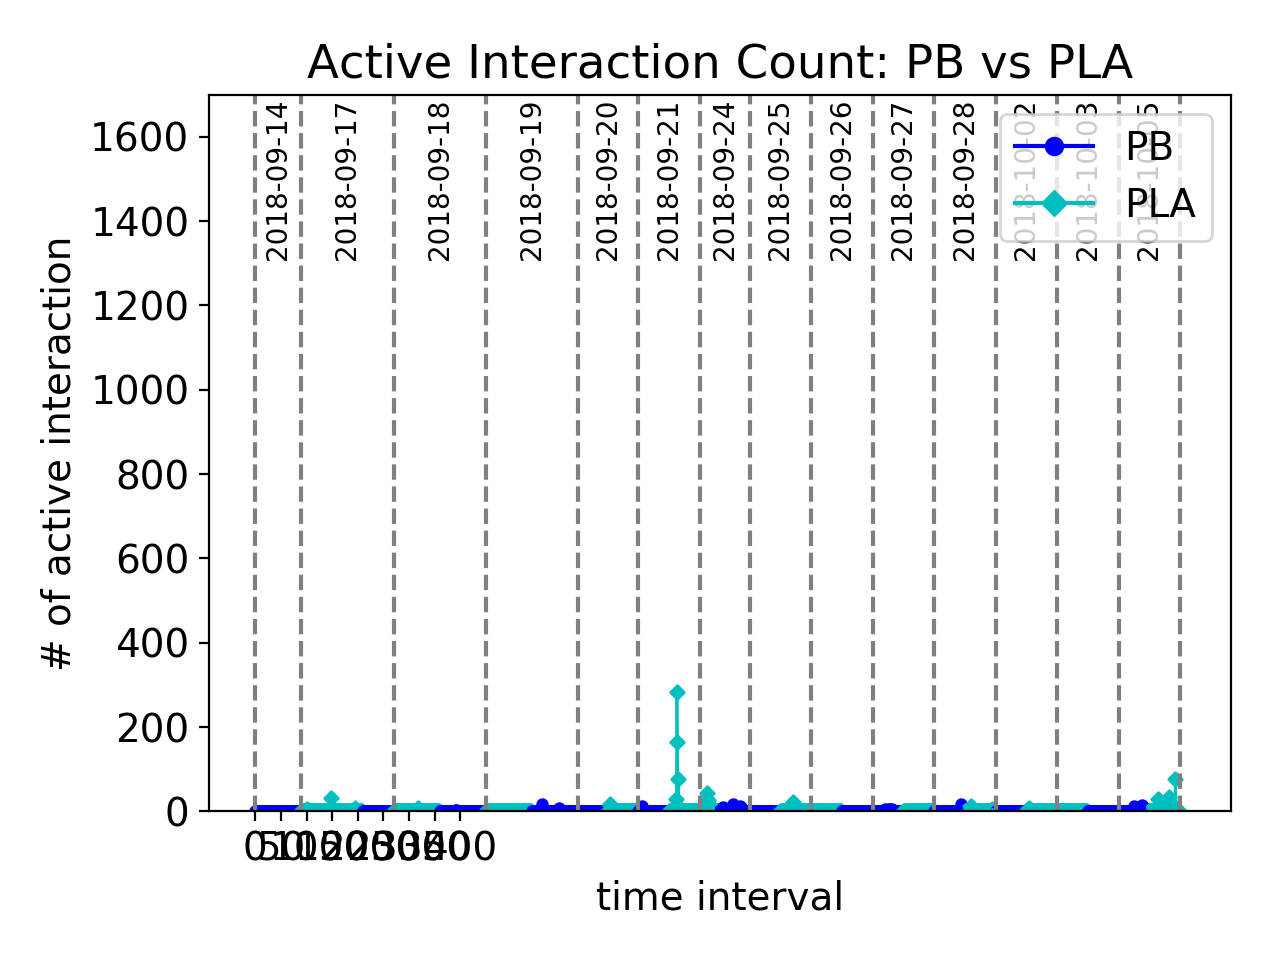

<IPython.core.display.Javascript object>


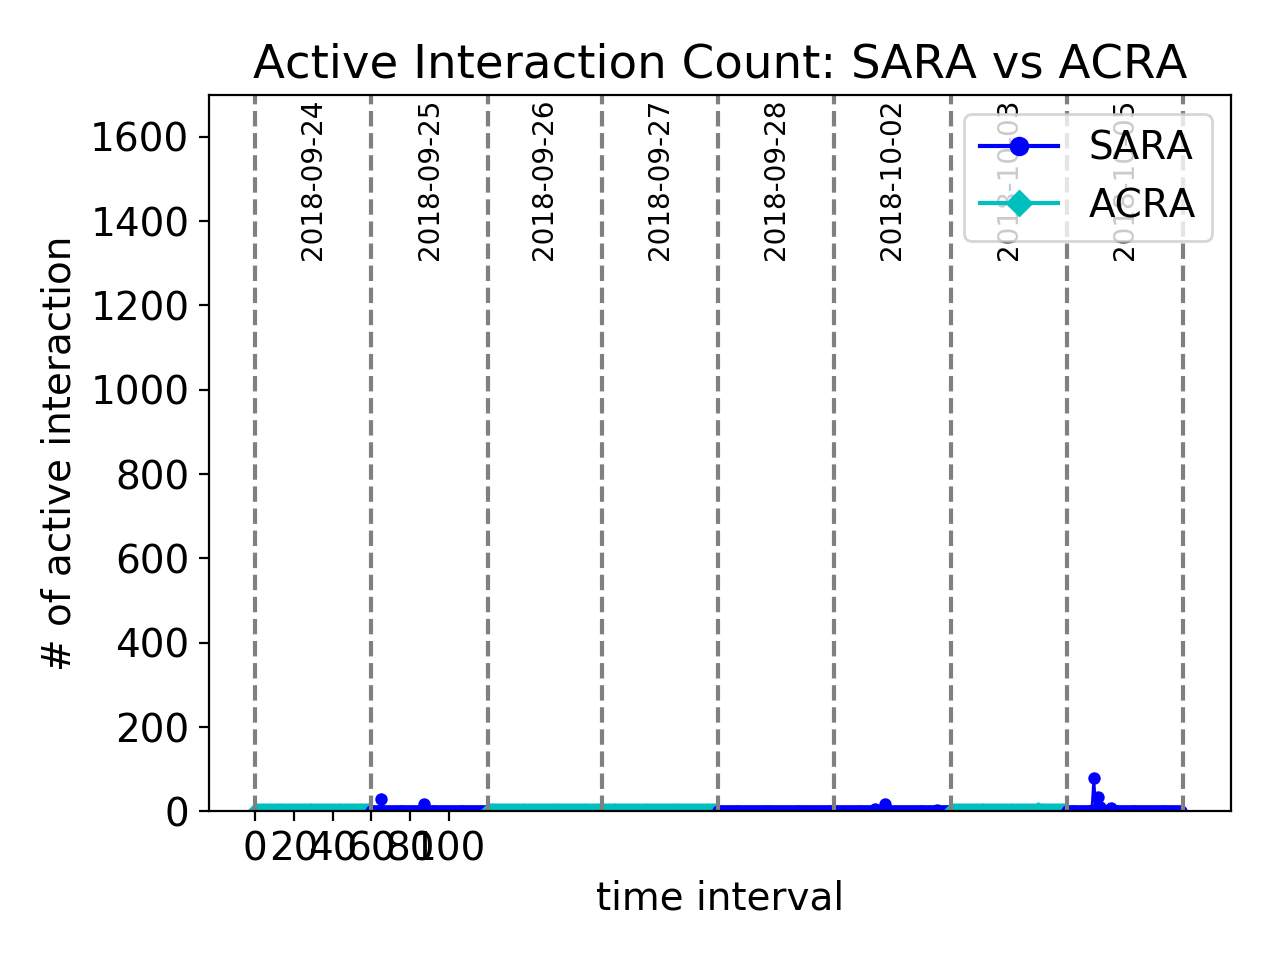

In [192]:
from matplotlib.lines import Line2D

def plot_active_interactionn_count(combined_count, 
                                   combined_count_separate_line_day, 
                                   combined_count_separate_line_behavior,
                                   combined_count_dates,
                                   behavior1 = 'PB',
                                   behavior2 = 'PLA'):

    combined_count.reset_index(drop=True,inplace=True)
    plt.figure()
    colors = ['b', 'c', 'b', 'c']
    marker_style = ['o','D', 'o','D']
    
    # plot active_count scatter
    for i in range(len(combined_count)):
        plt.scatter(i, combined_count['active_interaction_count'][i], 
                    color=colors[combined_count['behavior_code'][i]],
                    marker=marker_style[combined_count['behavior_code'][i]],
                    s = 12)
    
    # add vertical line separate each day
    for i, x in enumerate(combined_count_separate_line_day): 
#         if x == 0:
#             continue
        plt.axvline(x=x, linestyle='--', color='grey')
        
        plt.text(x=np.floor((x+combined_count_separate_line_day[i-1])/2), y=1500, 
                 s=combined_count_dates[i], fontsize='10',
                 rotation=90,
                 verticalalignment='center',horizontalalignment='center')
    
    # plot line for each behavior
    for i, x in enumerate(combined_count_separate_line_behavior):
        if x == 0:
            continue
        plt.plot(combined_count['active_interaction_count'][combined_count_separate_line_behavior[i-1]:x],
                 color=colors[combined_count['behavior_code'][x-1]],
                 linestyle='-', linewidth=1)
        
    plt.ylim(0,1700)
    plt.xlabel('time interval')
    plt.ylabel('# of active interaction')
    if behavior1 == 'PB':
        plt.xticks(np.arange(0, 401, 50))
    else:
        plt.xticks(np.arange(0, 101, 20))
        
    plt.title('Active Interaction Count: {} vs {}'.format(behavior1, behavior2))
    legend_elements = [Line2D([0], [0], marker='o', color='b', label=behavior1, markersize=6),
                       Line2D([0], [0], marker='D', color='c', label=behavior2, markersize=6)]
    plt.legend(handles=legend_elements)
    plt.tight_layout()
    plt.savefig('./figures/active_interaction_count_based_on_IR_{}_{}.png'.format(behavior1, behavior2), dpi=300)
    
plot_active_interactionn_count(PB_PLA_combined_count, 
                               PB_PLA_combined_count_separate_line_day, 
                               PB_PLA_combined_count_separate_line_behavior,
                               PB_PLA_combined_count_dates, 
                               'PB', 'PLA')

plot_active_interactionn_count(SARA_ACRA_combined_count, 
                               SARA_ACRA_combined_count_separate_line_day, 
                               SARA_ACRA_combined_count_separate_line_behavior,
                               SARA_ACRA_combined_count_dates, 
                               'SARA', 'ACRA')


## Pisson Regression: PB and PLA

In [193]:
def generate_explanatory_variables(add_explanatory_variables_PB, add_explanatory_variables_PLA):
    separate_line_PB_PLA = len(add_explanatory_variables_PB)
    explanatory_var_PB_PLA = pd.concat([add_explanatory_variables_PB, add_explanatory_variables_PLA])
    explanatory_var_PB_PLA.columns

    date_code_dummies = pd.get_dummies(explanatory_var_PB_PLA['date_code']).rename(columns=lambda x: 'Date_Code_' + str(x))
    time_code_dummies = pd.get_dummies(explanatory_var_PB_PLA['time_code']).rename(columns=lambda x: 'Time_Code_' + str(x))

    #X_With_Dummies = pd.concat([explanatory_var_PB_PLA['behavior_code'], date_code_dummies, time_code_dummies], axis=1)
    X_With_Dummies = pd.concat([explanatory_var_PB_PLA['behavior_code']], axis=1)
    X_With_Dummies.applymap(np.int)
    print('Explanatory Variable: {}'.format(X_With_Dummies.columns))
    X = X_With_Dummies.values
    X = sm.add_constant(X, prepend=False) # add constant

    # Y = np.divide(explanatory_var_PB_PLA['active_interaction_count'].values, 
    #               explanatory_var_PB_PLA['total_interaction_count'].values)
    Y = explanatory_var_PB_PLA['active_interaction_count'].values
    
    print('X.shape=({}, {})'.format(X.shape[0],X.shape[1]))
    print('Y.shape=({}, {})'.format(Y.shape[0], ''))

    Offset = explanatory_var_PB_PLA['date_code'].values
    #Offset = explanatory_var_PB_PLA['time_code'].values
    return X, Y, Offset

X_PB_PLA, Y_PB_PLA, Offset_PB_PLA = generate_explanatory_variables(add_explanatory_variables_PB, 
                                                                   add_explanatory_variables_PLA)

X_SARA_ACRA, Y_SARA_ACRA, Offset_SARA_ACRA = generate_explanatory_variables(add_explanatory_variables_SARA, 
                                                                            add_explanatory_variables_ACRA)


Explanatory Variable: Index(['behavior_code'], dtype='object')
X.shape=(1805, 2)
Y.shape=(1805, )
Explanatory Variable: Index(['behavior_code'], dtype='object')
X.shape=(479, 2)
Y.shape=(479, )


In [194]:
# combine PB and PLA
add_explanatory_variables_PB_tmp = add_explanatory_variables_PB.copy()
add_explanatory_variables_PB_tmp['behavior_code'] = 0
add_explanatory_variables_PLA_tmp = add_explanatory_variables_PLA.copy()
add_explanatory_variables_PLA_tmp['behavior_code'] = 0
add_explanatory_variables_PB_PLA = pd.concat([add_explanatory_variables_PB_tmp, add_explanatory_variables_PLA_tmp])
add_explanatory_variables_PB_PLA.reset_index(drop=True,inplace=True)

# combine SARA and ACRA
add_explanatory_variables_SARA_tmp = add_explanatory_variables_SARA.copy()
add_explanatory_variables_SARA_tmp['behavior_code'] = 1
add_explanatory_variables_ACRA_tmp = add_explanatory_variables_ACRA.copy()
add_explanatory_variables_ACRA_tmp['behavior_code'] = 1
add_explanatory_variables_SARA_ACRA = pd.concat([add_explanatory_variables_SARA_tmp, add_explanatory_variables_ACRA_tmp])
add_explanatory_variables_SARA_ACRA.reset_index(drop=True,inplace=True)

X_PB_PLA_SARA_ACRA, Y_PB_PLA_SARA_ACRA, Offset_PB_PLA_SARA_ACRA = generate_explanatory_variables(add_explanatory_variables_PB_PLA,
                                                                                                 add_explanatory_variables_SARA_ACRA)


Explanatory Variable: Index(['behavior_code'], dtype='object')
X.shape=(2284, 2)
Y.shape=(2284, )


### Delete 0 Count

In [195]:
def delete_zeros_in_explanatory_vars(X, Y, Offset, add_explanatory_variables_PB):
    zero_num = np.count_nonzero(Y==0)
    print('zeros: {}, total: {}'.format(zero_num, len(Y)))
    
    separate_line_PB_PLA = len(add_explanatory_variables_PB) - len(np.where( np.where(Y == 0)[0]< len(add_explanatory_variables_PB))[0])
    print('add_explanatory_variables_PB={}'.format(len(add_explanatory_variables_PB)))
    print('separate_line_PB_PLA={}'.format(separate_line_PB_PLA))
    
    X = np.delete(X, np.where(Y == 0), axis=0)
    Offset = np.delete(Offset, np.where(Y == 0))
    Y = np.delete(Y, np.where(Y == 0))
    
    return X, Y, separate_line_PB_PLA
    
X_PB_PLA, Y_PB_PLA, separate_line_PB_PLA = delete_zeros_in_explanatory_vars(X_PB_PLA, 
                                                                            Y_PB_PLA, 
                                                                            Offset_PB_PLA, 
                                                                            add_explanatory_variables_PB)

X_SARA_ACRA, Y_SARA_ACRA, separate_line_SARA_ACRA = delete_zeros_in_explanatory_vars(X_SARA_ACRA, 
                                                                                     Y_SARA_ACRA, 
                                                                                     Offset_SARA_ACRA, 
                                                                                     add_explanatory_variables_SARA)

X_PB_PLA_SARA_ACRA, Y_PB_PLA_SARA_ACRA, separate_line_PB_PLA_SARA_ACRA = delete_zeros_in_explanatory_vars(X_PB_PLA_SARA_ACRA, 
                                                                                                          Y_PB_PLA_SARA_ACRA, 
                                                                                                          Offset_PB_PLA_SARA_ACRA, 
                                                                                                          add_explanatory_variables_PB_PLA)
    

zeros: 1726, total: 1805
add_explanatory_variables_PB=928
separate_line_PB_PLA=38
zeros: 464, total: 479
add_explanatory_variables_PB=240
separate_line_PB_PLA=12
zeros: 2190, total: 2284
add_explanatory_variables_PB=1805
separate_line_PB_PLA=79


#### Poisson Regression: 
For interpret the results, please refer to https://stats.idre.ucla.edu/stata/output/poisson-regression/.

In [196]:
import statsmodels.api as sm
# building the model
def Poisson_Regression(X, Y):
    poisson_mod = sm.Poisson(Y, X)
    poisson_res = poisson_mod.fit(method="newton")
    print(poisson_res.summary2())
    

    # testing the model
    predVals = poisson_res.predict(X)
    print('Parameters: ', poisson_res.params)
    print('T-values: ', poisson_res.tvalues)
    print('poisson_res.scale={}'.format(poisson_res.scale))
    return predVals

print('Poisson Regression: PB and PLA')
predVals_PB_PLA = Poisson_Regression(X_PB_PLA, Y_PB_PLA)

print('**********************************************************************')

print('Poisson Regression: SARA and ACRA')
predVals_SARA_ACRA = Poisson_Regression(X_SARA_ACRA, Y_SARA_ACRA)

print('**********************************************************************')

print('Poisson Regression: SARA and ACRA')
predVals_PB_PLA_SARA_ACRA = Poisson_Regression(X_PB_PLA_SARA_ACRA, Y_PB_PLA_SARA_ACRA)


Poisson Regression: PB and PLA
Optimization terminated successfully.
         Current function value: 16.321003
         Iterations 6
                         Results: Poisson
Model:              Poisson          Pseudo R-squared: 0.153      
Dependent Variable: y                AIC:              2582.7185  
Date:               2019-03-08 14:47 BIC:              2587.4574  
No. Observations:   79               Log-Likelihood:   -1289.4    
Df Model:           1                LL-Null:          -1521.6    
Df Residuals:       77               LLR p-value:      5.3090e-103
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
---------------------------------------------------------------------
          Coef.     Std.Err.       z       P>|z|     [0.025    0.975]
---------------------------------------------------------------------
x1        1.4042      0.0737    19.0528    0.0000    1.2598    1.5487
const   

the variance of a Poisson distribution is equal to its mean, hence the scale parameter should be approximately equal 1 if the data follow a Poisson regression model. http://nbviewer.jupyter.org/urls/umich.box.com/shared/static/ir0bnkup9rywmqd54zvm.ipynb

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


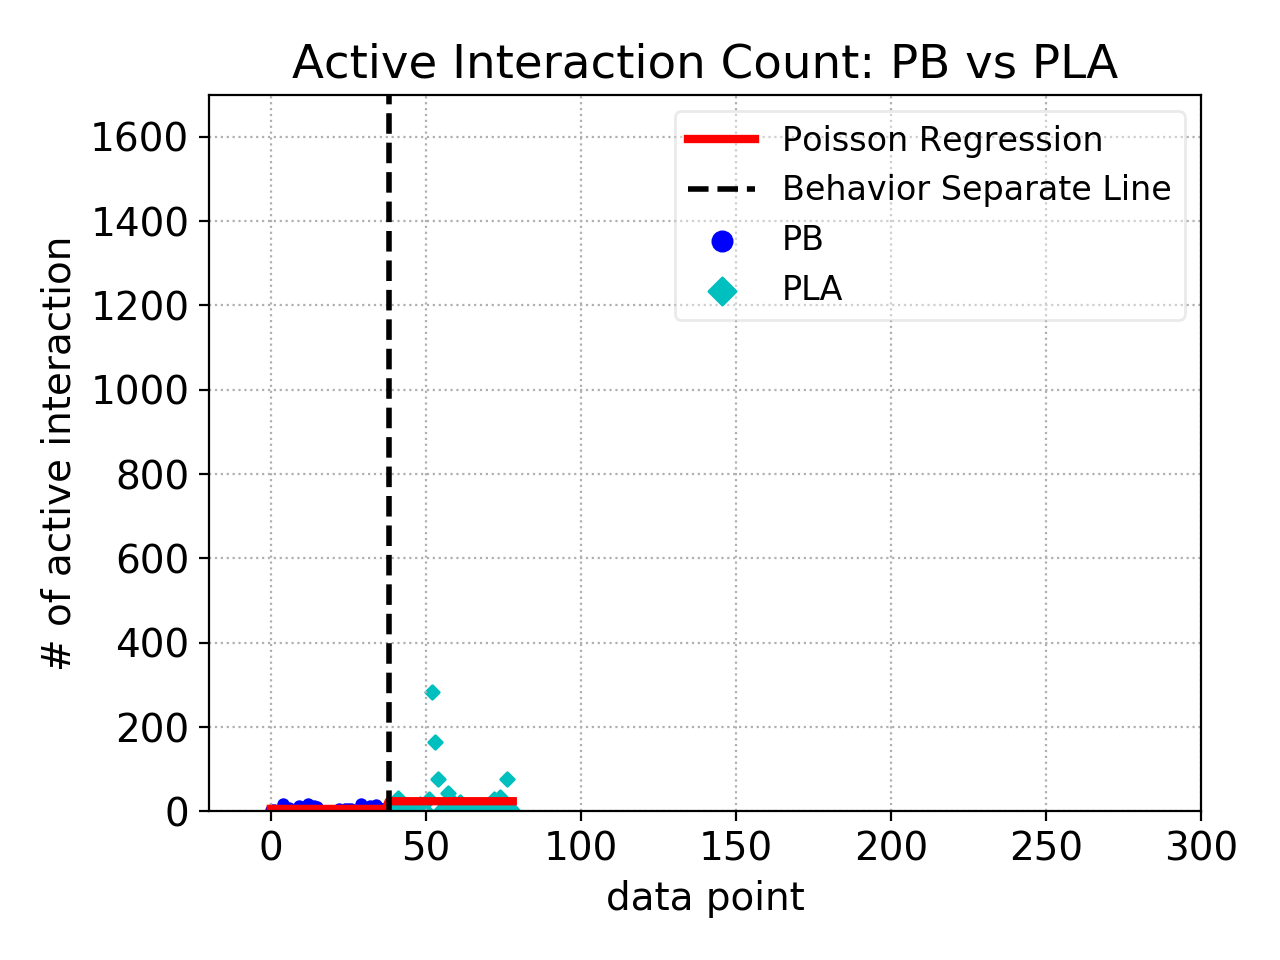

<IPython.core.display.Javascript object>


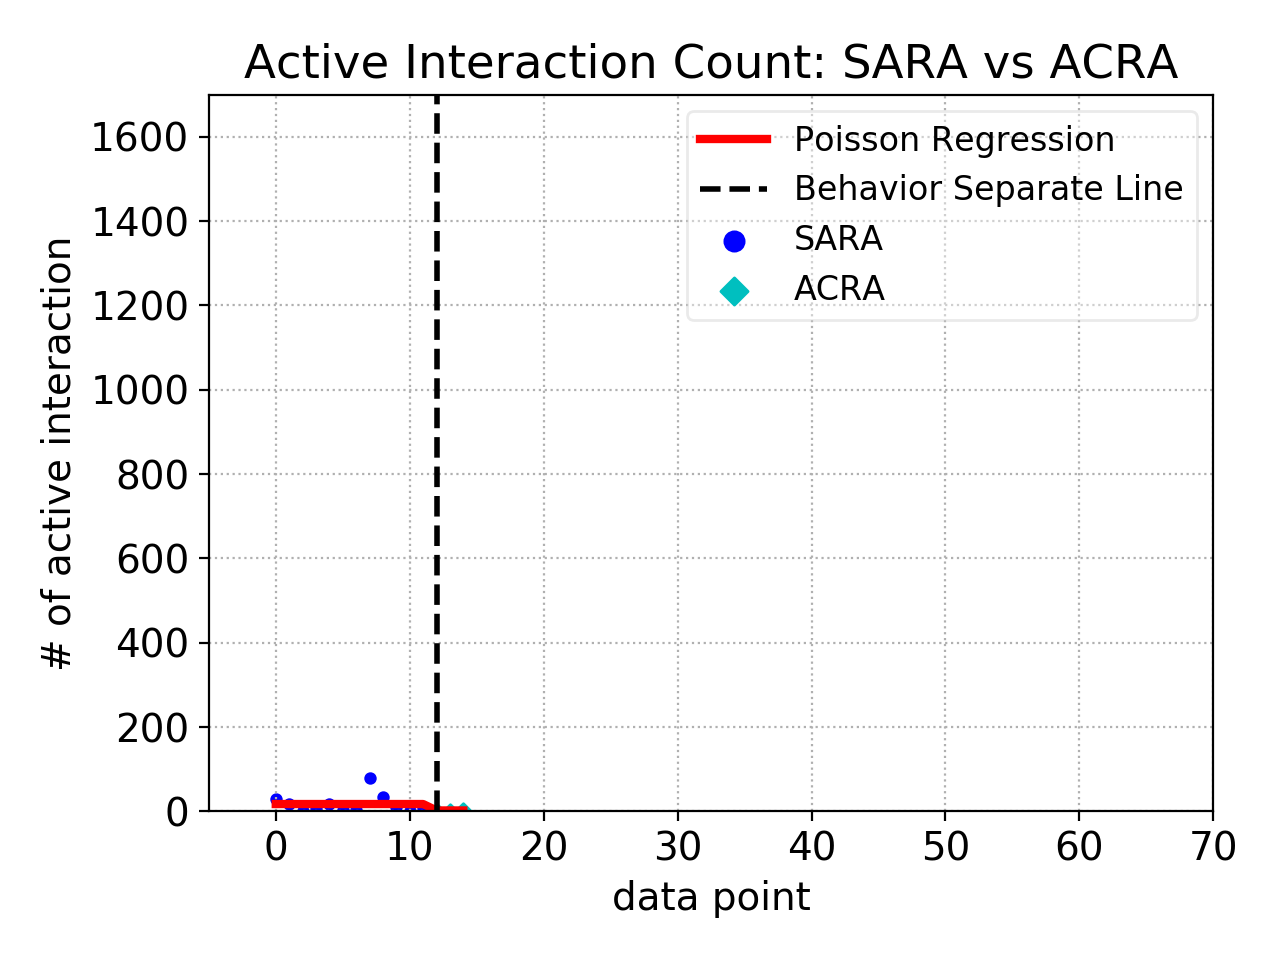

<IPython.core.display.Javascript object>


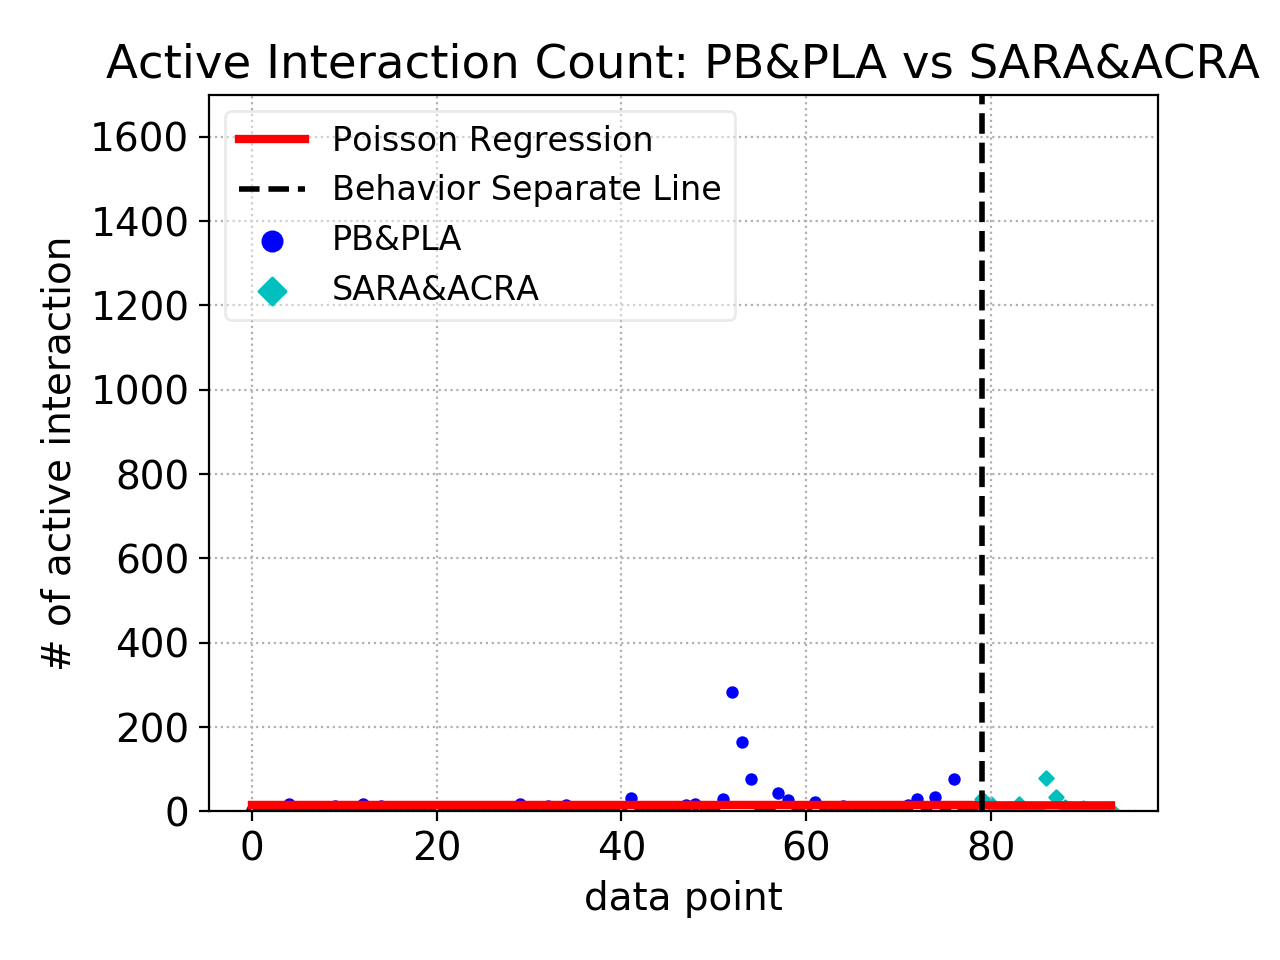

In [197]:
def plot_Poisson_Regression(Y, predVals, separate_line_PB_PLA, behavior1='PB', behavior2='PLA'):
    plt.figure()

    plt.scatter(range(separate_line_PB_PLA), Y[:separate_line_PB_PLA], c='b', marker='o', s = 12)
    plt.scatter(range(separate_line_PB_PLA,len(Y)), Y[separate_line_PB_PLA:], c='c', marker='D', s = 12)
    
    plt.plot(range(len(Y)), predVals, 'r-', linewidth=3)

    plt.axvline(x=separate_line_PB_PLA, linestyle='--', color='black',linewidth=2)

    plt.ylabel('# of active interaction')
    plt.xlabel('data point')
    if behavior1=='PB':
        plt.xlim(-20,300)
    elif behavior1=='SARA':
        plt.xlim(-5,70)
    else:
        pass
    plt.ylim(0,1700)
    plt.title('Active Interaction Count: {} vs {}'.format(behavior1, behavior2))
    plt.legend(['Poisson Regression', 'Behavior Separate Line', behavior1, behavior2],fontsize=12, markerscale=2, framealpha=0.4)
    plt.tight_layout()
    plt.grid(True, linestyle=':')
    plt.show()
    plt.savefig('./figures/Poisson_Regression_active_interaction_{}_{}.png'.format(behavior1, behavior2), dpi=300)

plot_Poisson_Regression(Y_PB_PLA, predVals_PB_PLA, separate_line_PB_PLA, 'PB', 'PLA')

plot_Poisson_Regression(Y_SARA_ACRA, predVals_SARA_ACRA, separate_line_SARA_ACRA, 'SARA', 'ACRA')

plot_Poisson_Regression(Y_PB_PLA_SARA_ACRA, predVals_PB_PLA_SARA_ACRA, separate_line_PB_PLA_SARA_ACRA, 'PB&PLA', 'SARA&ACRA')
    

In [198]:
predVals_PB_PLA[-1] - predVals_PB_PLA[0]

18.27214377406932

In [199]:
predVals_SARA_ACRA[-1] - predVals_SARA_ACRA[0]

-15.250000000000007

In [200]:
predVals_PB_PLA_SARA_ACRA[-1] - predVals_PB_PLA_SARA_ACRA[0]

-0.8970464135021139

In [201]:
print('PB:{}, PLA:{}'.format(predVals_PB_PLA[0], predVals_PB_PLA[-1]))

PB:5.947368421052632, PLA:24.219512195121954


In [202]:
print('SARA:{}, ACRA:{}'.format(predVals_SARA_ACRA[0], predVals_SARA_ACRA[-1]))

SARA:17.583333333333343, ACRA:2.333333333333335


In [203]:
print('PB&PLA:{}, SARA&ACRA:{}'.format(predVals_PB_PLA_SARA_ACRA[0], predVals_PB_PLA_SARA_ACRA[-1]))

PB&PLA:15.430379746835445, SARA&ACRA:14.533333333333331


In [204]:
separate_line_PB_PLA

38

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


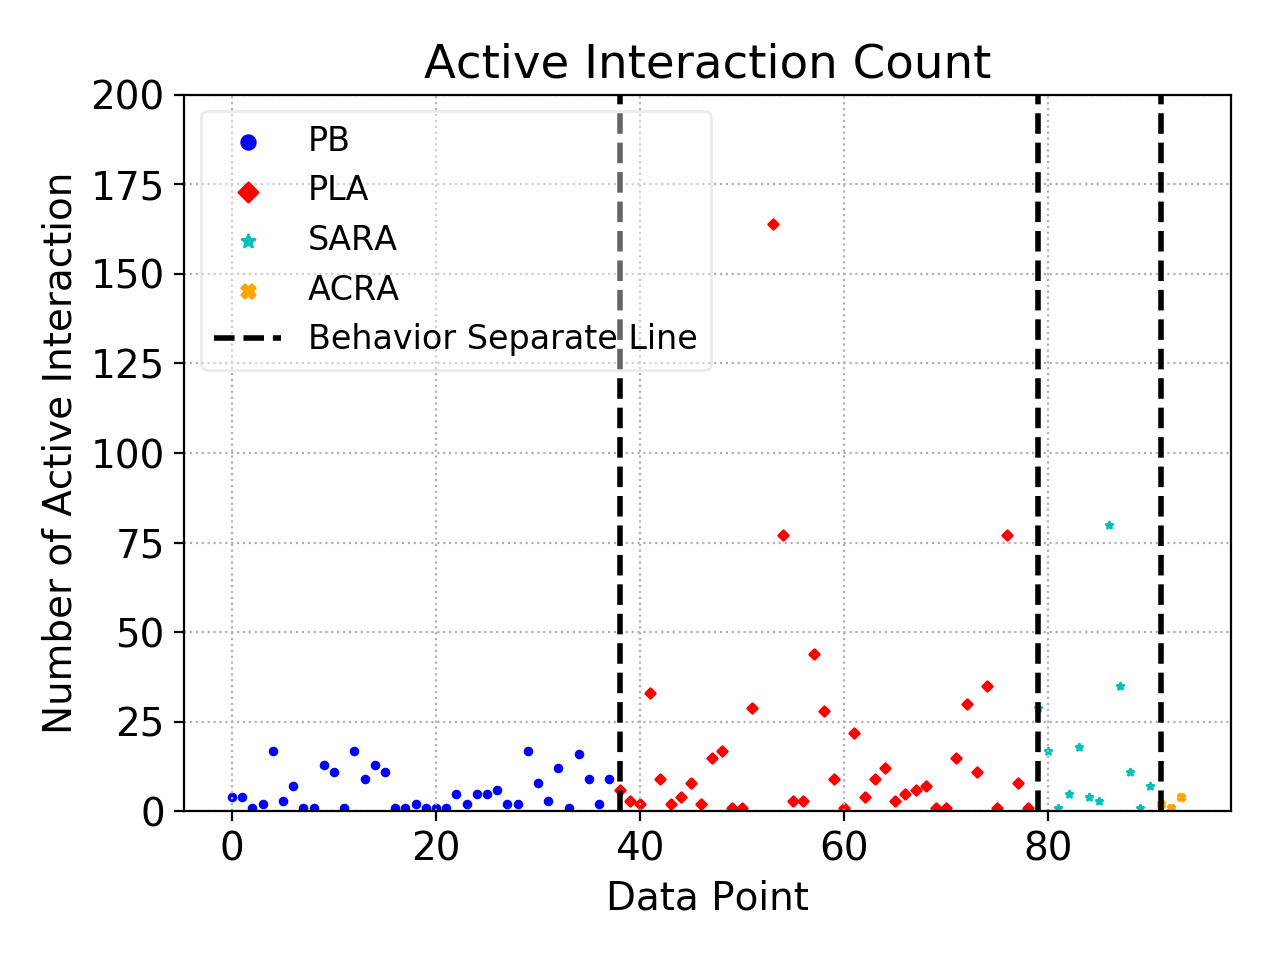

In [205]:
# Y_PB_PLA
# separate_line_PB_PLA
# Y_SARA_ACRA
# separate_line_SARA_ACRA

plt.figure()

handle_PB = plt.scatter(range(separate_line_PB_PLA), Y_PB_PLA[:separate_line_PB_PLA], c='b', marker='o', s = 6)
handle_PLA = plt.scatter(range(separate_line_PB_PLA,len(Y_PB_PLA)), Y_PB_PLA[separate_line_PB_PLA:], c='r', marker='D', s = 6)
handle_SARA = plt.scatter(range(len(Y_PB_PLA),len(Y_PB_PLA)+separate_line_SARA_ACRA), Y_SARA_ACRA[:separate_line_SARA_ACRA], c='c', marker='*', s = 6)
handle_ACRA = plt.scatter(range(len(Y_PB_PLA)+separate_line_SARA_ACRA,len(Y_PB_PLA)+len(Y_SARA_ACRA)), Y_SARA_ACRA[separate_line_SARA_ACRA:], c='orange', marker='X', s = 6)

# plt.plot(range(len(Y)), predVals, 'r-', linewidth=3)

handle_separate_line = plt.axvline(x=separate_line_PB_PLA, linestyle='--', color='black',linewidth=2)
plt.axvline(x=len(Y_PB_PLA), linestyle='--', color='black',linewidth=2)
plt.axvline(x=len(Y_PB_PLA)+separate_line_SARA_ACRA, linestyle='--', color='black',linewidth=2)

plt.ylabel('Number of Active Interaction')
plt.xlabel('Data Point')

# plt.ylim(0,1700)
plt.ylim(0,200)
plt.title('Active Interaction Count')
plt.legend(handles=[handle_PB, handle_PLA, handle_SARA, handle_ACRA, handle_separate_line], 
           labels=['PB', 'PLA', 'SARA', 'ACRA', 'Behavior Separate Line'],fontsize=12, markerscale=2, framealpha=0.4)
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Active_Interaction_Count.png', dpi=300)


Run after getting occupancy

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


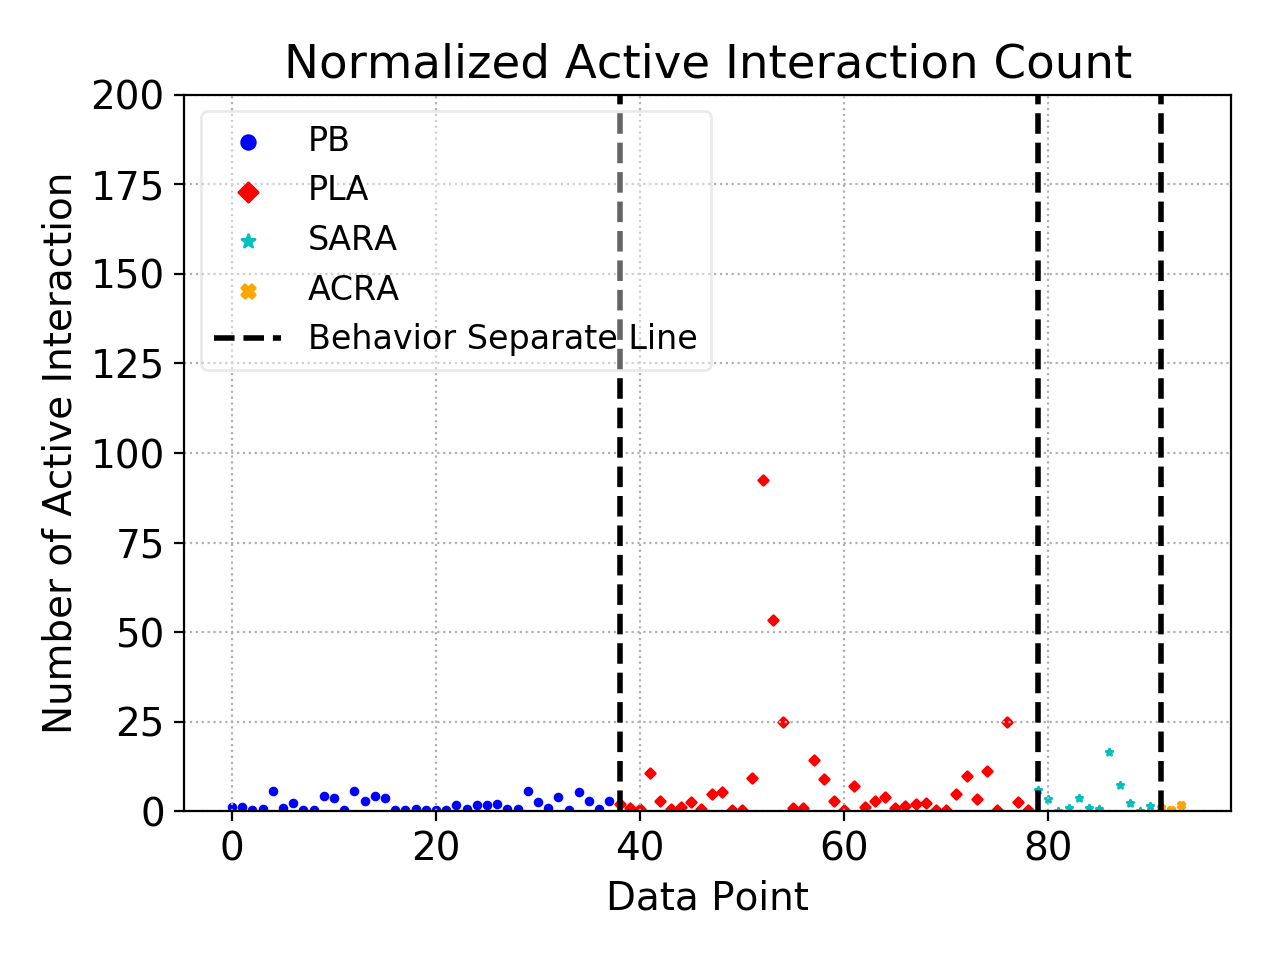

In [207]:
# Y_PB_PLA
# separate_line_PB_PLA
# Y_SARA_ACRA
# separate_line_SARA_ACRA


plt.figure()

handle_PB = plt.scatter(range(separate_line_PB_PLA), 
                        Y_PB_PLA[:separate_line_PB_PLA] / point_avg_PB.mean(), 
                        c='b', marker='o', s = 6)
handle_PLA = plt.scatter(range(separate_line_PB_PLA,len(Y_PB_PLA)), 
                         Y_PB_PLA[separate_line_PB_PLA:] / point_avg_PLA.mean(), 
                         c='r', marker='D', s = 6)
handle_SARA = plt.scatter(range(len(Y_PB_PLA),len(Y_PB_PLA)+separate_line_SARA_ACRA), 
                          Y_SARA_ACRA[:separate_line_SARA_ACRA] / point_avg_SARA.mean(), 
                          c='c', marker='*', s = 6)
handle_ACRA = plt.scatter(range(len(Y_PB_PLA)+separate_line_SARA_ACRA,len(Y_PB_PLA)+len(Y_SARA_ACRA)), 
                          Y_SARA_ACRA[separate_line_SARA_ACRA:] / point_avg_ACRA.mean(), 
                          c='orange', marker='X', s = 6)

# plt.plot(range(len(Y)), predVals, 'r-', linewidth=3)

handle_separate_line = plt.axvline(x=separate_line_PB_PLA, linestyle='--', color='black',linewidth=2)
plt.axvline(x=len(Y_PB_PLA), linestyle='--', color='black',linewidth=2)
plt.axvline(x=len(Y_PB_PLA)+separate_line_SARA_ACRA, linestyle='--', color='black',linewidth=2)

plt.ylabel('Number of Active Interaction')
plt.xlabel('Data Point')

#plt.ylim(0,1700)
plt.ylim(0,200)
plt.title('Normalized Active Interaction Count')
plt.legend(handles=[handle_PB, handle_PLA, handle_SARA, handle_ACRA, handle_separate_line], 
           labels=['PB', 'PLA', 'SARA', 'ACRA', 'Behavior Separate Line'],fontsize=12, markerscale=2, framealpha=0.4)
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Normalized_Active_Interaction_Count.png', dpi=300)



In [208]:
from scipy import stats
active_interaction_PB = Y_PB_PLA[:separate_line_PB_PLA]
active_interaction_PLA = Y_PB_PLA[separate_line_PB_PLA:]
active_interaction_SARA = Y_SARA_ACRA[:separate_line_SARA_ACRA]
active_interaction_ACRA= Y_SARA_ACRA[separate_line_SARA_ACRA:]

t_PB_PLA, p_PB_PLA = stats.ttest_ind(active_interaction_PB, active_interaction_PLA)
t_PB_SARA, p_PB_SARA = stats.ttest_ind(active_interaction_PB, active_interaction_SARA)
t_PB_ACRA, p_PB_ACRA =stats.ttest_ind(active_interaction_PB, active_interaction_ACRA)
t_PLA_SARA, p_PLA_SARA =stats.ttest_ind(active_interaction_PLA, active_interaction_SARA)
t_PLA_ACRA, p_PLA_ACRA = stats.ttest_ind(active_interaction_PLA, active_interaction_ACRA)
t_SARA_ACRA, t_SARA_ACRA =stats.ttest_ind(active_interaction_SARA, active_interaction_ACRA)
print('t_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(t_PB_PLA, p_PB_PLA))
print('t_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(t_PB_SARA, p_PB_SARA))
print('t_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(t_PB_ACRA, p_PB_ACRA))
print('t_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(t_PLA_SARA, p_PLA_SARA))
print('t_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(t_PLA_ACRA, p_PLA_ACRA))
print('t_SARA_ACRA={0:.4f}, t_SARA_ACRA={1:.4f}'.format(t_SARA_ACRA, t_SARA_ACRA))


t_PB_PLA=-2.1945, p_PB_PLA=0.0312
t_PB_SARA=-2.9866, p_PB_SARA=0.0044
t_PB_ACRA=1.1567, p_PB_ACRA=0.2544
t_PLA_SARA=0.4357, p_PLA_SARA=0.6649
t_PLA_ACRA=0.7345, p_PLA_ACRA=0.4667
t_SARA_ACRA=0.2754, t_SARA_ACRA=0.2754


In [209]:
from scipy import stats
active_interaction_PB = Y_PB_PLA[:separate_line_PB_PLA]
active_interaction_PLA = Y_PB_PLA[separate_line_PB_PLA:]
active_interaction_SARA = Y_SARA_ACRA[:separate_line_SARA_ACRA]
active_interaction_ACRA= Y_SARA_ACRA[separate_line_SARA_ACRA:]

t_PB_PLA, p_PB_PLA = stats.ttest_ind(active_interaction_PB, active_interaction_PLA, equal_var=False)
t_PB_SARA, p_PB_SARA = stats.ttest_ind(active_interaction_PB, active_interaction_SARA, equal_var=False)
t_PB_ACRA, p_PB_ACRA =stats.ttest_ind(active_interaction_PB, active_interaction_ACRA, equal_var=False)
t_PLA_SARA, p_PLA_SARA =stats.ttest_ind(active_interaction_PLA, active_interaction_SARA, equal_var=False)
t_PLA_ACRA, p_PLA_ACRA = stats.ttest_ind(active_interaction_PLA, active_interaction_ACRA, equal_var=False)
t_SARA_ACRA, t_SARA_ACRA =stats.ttest_ind(active_interaction_SARA, active_interaction_ACRA, equal_var=False)
print('t_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(t_PB_PLA, p_PB_PLA))
print('t_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(t_PB_SARA, p_PB_SARA))
print('t_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(t_PB_ACRA, p_PB_ACRA))
print('t_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(t_PLA_SARA, p_PLA_SARA))
print('t_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(t_PLA_ACRA, p_PLA_ACRA))
print('t_SARA_ACRA={0:.4f}, t_SARA_ACRA={1:.4f}'.format(t_SARA_ACRA, t_SARA_ACRA))



t_PB_PLA=-2.2786, p_PB_PLA=0.0280
t_PB_SARA=-1.7723, p_PB_SARA=0.1031
t_PB_ACRA=2.9243, p_PB_ACRA=0.0210
t_PLA_SARA=0.6448, p_PLA_SARA=0.5225
t_PLA_ACRA=2.7287, p_PLA_ACRA=0.0093
t_SARA_ACRA=0.0397, t_SARA_ACRA=0.0397


In [210]:

t_PB_PLA, p_PB_PLA = stats.ks_2samp(active_interaction_PB, active_interaction_PLA)
t_PB_SARA, p_PB_SARA = stats.ks_2samp(active_interaction_PB, active_interaction_SARA)
t_PB_ACRA, p_PB_ACRA =stats.ks_2samp(active_interaction_PB, active_interaction_ACRA)
t_PLA_SARA, p_PLA_SARA =stats.ks_2samp(active_interaction_PLA, active_interaction_SARA)
t_PLA_ACRA, p_PLA_ACRA = stats.ks_2samp(active_interaction_PLA, active_interaction_ACRA)
t_SARA_ACRA, t_SARA_ACRA =stats.ks_2samp(active_interaction_SARA, active_interaction_ACRA)
print('KS_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(t_PB_PLA, p_PB_PLA))
print('KS_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(t_PB_SARA, p_PB_SARA))
print('KS_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(t_PB_ACRA, p_PB_ACRA))
print('KS_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(t_PLA_SARA, p_PLA_SARA))
print('KS_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(t_PLA_ACRA, p_PLA_ACRA))
print('KS_SARA_ACRA={0:.4f}, t_SARA_ACRA={1:.4f}'.format(t_SARA_ACRA, t_SARA_ACRA))

KS_PB_PLA=0.2683, p_PB_PLA=0.0969
KS_PB_SARA=0.3377, p_PB_SARA=0.2000
KS_PB_ACRA=0.4737, p_PB_ACRA=0.4239
KS_PLA_SARA=0.1240, p_PLA_SARA=0.9975
KS_PLA_ACRA=0.6098, p_PLA_ACRA=0.1536
KS_SARA_ACRA=0.1355, t_SARA_ACRA=0.1355


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


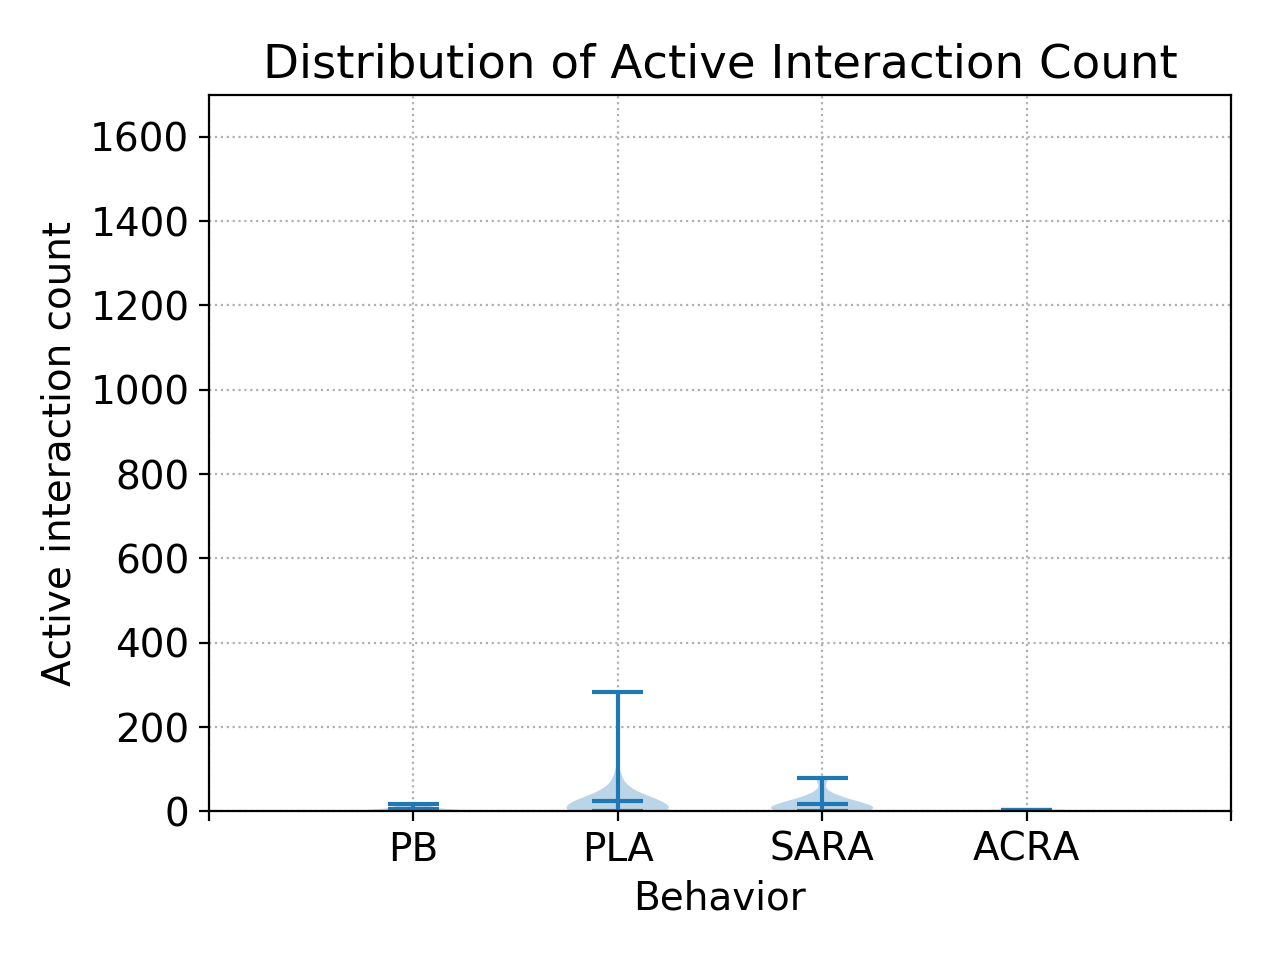

In [211]:
active_interaction = [active_interaction_PB, active_interaction_PLA, 
                       active_interaction_SARA, active_interaction_ACRA]

plt.figure()
plt.rcParams.update({'font.size': 14})
plt.violinplot(active_interaction, showmeans=True, showmedians=False)
plt.xticks(np.arange(0,6), ['','PB', 'PLA', 'SARA', 'ACRA'])
plt.ylim(0,1700)
plt.ylabel('Active interaction count')
plt.xlabel('Behavior')
plt.title('Distribution of Active Interaction Count')
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Distribution_of_active_interaction.png', dpi=300)



/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


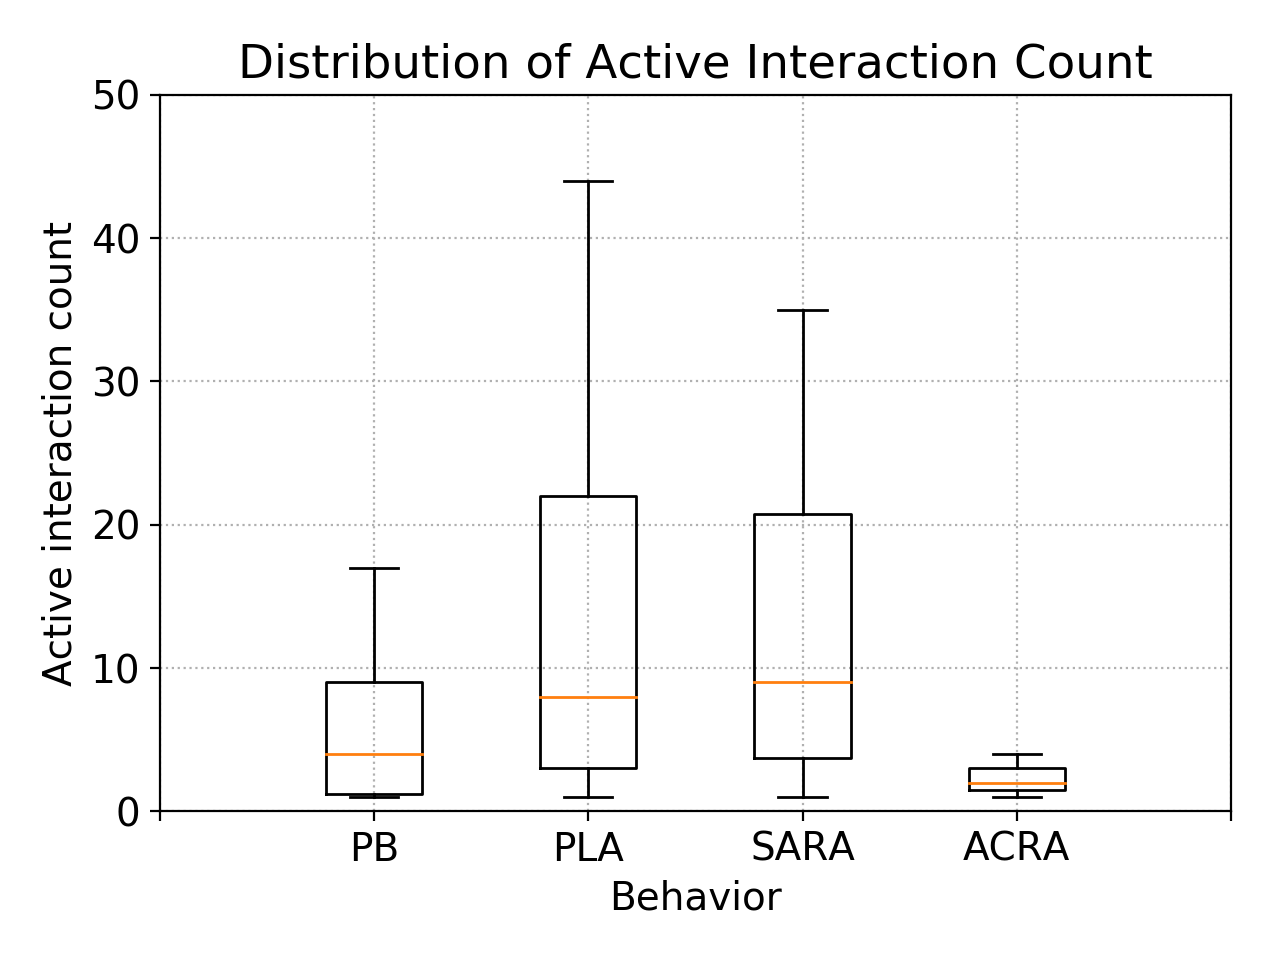

In [216]:
active_interaction = [active_interaction_PB, active_interaction_PLA, 
                       active_interaction_SARA, active_interaction_ACRA]

plt.figure()
plt.rcParams.update({'font.size': 14})
plt.boxplot(active_interaction, meanline=True)
plt.xticks(np.arange(0,6), ['','PB', 'PLA', 'SARA', 'ACRA'])
# plt.ylim(0,600)
plt.ylim(0,50)
plt.ylabel('Active interaction count')
plt.xlabel('Behavior')
plt.title('Distribution of Active Interaction Count')
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Distribution_of_active_interaction.png', dpi=300)



In [213]:
active_interaction = [active_interaction_PB, active_interaction_PLA, 
                       active_interaction_SARA, active_interaction_ACRA]
behavior_name = ['PB', 'PLA', 'SARA', 'ACRA']
for i in range(4):
    mean = active_interaction[i].mean()
    std = active_interaction[i].std()
    print('{0}: mean={1:.4f}, std={2:.4f}'.format(behavior_name[i], mean, std))

PB: mean=5.9474, std=5.2663
PLA: mean=24.2195, std=50.4195
SARA: mean=17.5833, std=21.5849
ACRA: mean=2.3333, std=1.2472


# ZeroInflatedPoisson Regression
from statsmodels.discrete.count_model import ZeroInflatedPoisson

# Occupancy

In [116]:
# occupancy_camera1_prescribed_behavior
# occupancy_camera1_para_learning_agent
# occupancy_camera1_single_agent_raw_act
# occupancy_camera1_agent_coummunity_raw_act

In [117]:
#pd.DataFrame(occupancy_camera1_prescribed_behavior['data'])
occupancy_camera1_prescribed_behavior.keys()

dict_keys(['data', 'separate_line', 'date'])

In [118]:

occupancy_camera1_prescribed_behavior['separate_line']
occupancy_camera1_prescribed_behavior['date']

['Sep_17_1500_1600',
 'Sep_18_1430_1600',
 'Sep_19_1430_1500',
 'Sep_19_1500_1600',
 'Sep_20_1300_1400',
 'Sep_21_1400_1500',
 'Sep_24_1400_1500',
 'Sep_25_1300_1400',
 'Sep_26_1400_1500',
 'Sep_27_1300_1400',
 'Sep_28_1300_1400',
 'Oct_02_1300_1400',
 'Oct_03_1500_1600',
 'Oct_05_1300_1400']

In [119]:
def combine_occupancy_of_comparable_behavior(occupancy_camera1_prescribed_behavior,
                                             occupancy_camera1_para_learning_agent):
    PB_occupancy = pd.DataFrame(occupancy_camera1_prescribed_behavior['data'])
    PB_occupancy.reset_index(drop=True,inplace=True)
    PB_occupancy['behavior_code'] = 0

    PLA_occupancy = pd.DataFrame(occupancy_camera1_para_learning_agent['data'])
    PLA_occupancy.reset_index(drop=True,inplace=True)
    PLA_occupancy['behavior_code'] = 1

    PB_PLA_occupancy_separate_line = len(PB_occupancy)
    PB_PLA_occupancy = pd.concat([PB_occupancy, PLA_occupancy])
    PB_PLA_occupancy.reset_index(drop=True,inplace=True)
    
    return PB_occupancy, PLA_occupancy, PB_PLA_occupancy, PB_PLA_occupancy_separate_line

PB_occupancy,\
PLA_occupancy,\
PB_PLA_occupancy,\
PB_PLA_occupancy_separate_line = combine_occupancy_of_comparable_behavior(occupancy_camera1_prescribed_behavior,
                                                                          occupancy_camera1_para_learning_agent)

SARA_occupancy,\
ACRA_occupancy,\
SARA_ACRA_occupancy,\
SARA_ACRA_occupancy_separate_line = combine_occupancy_of_comparable_behavior(occupancy_camera1_single_agent_raw_act,
                                                               occupancy_camera1_agent_coummunity_raw_act)
    

SARA_ACRA_occupancy.columns


Index(['Time', 'Occupancy', 'behavior_code'], dtype='object')

In [130]:
PB_occupancy.to_csv('./cleaned_occupancy_data/PB_occupancy.csv', index=False)
PLA_occupancy.to_csv('./cleaned_occupancy_data/PLA_occupancy.csv', index=False)
SARA_occupancy.to_csv('./cleaned_occupancy_data/SARA_occupancy.csv', index=False)
ACRA_occupancy.to_csv('./cleaned_occupancy_data/ACRA_occupancy.csv', index=False)

In [120]:


print("PB_occupancy mean={},  PLA_occupancy mean = {}".format(PB_occupancy["Occupancy"].mean(),
                                                              PLA_occupancy["Occupancy"].mean()))



print("SARA_occupancy mean={},  ACRA_occupancy mean = {}".format(SARA_occupancy["Occupancy"].mean(),
                                                              ACRA_occupancy["Occupancy"].mean()))




PB_occupancy mean=2.958948012442249,  PLA_occupancy mean = 3.070376497618577
SARA_occupancy mean=4.7958805091793,  ACRA_occupancy mean = 2.271592631819409


In [121]:
PB_PLA_occupancy_tmp = PB_PLA_occupancy.copy()
PB_PLA_occupancy_tmp['behavior_code']=0
SARA_ACRA_occupancy_tmp = SARA_ACRA_occupancy.copy()
SARA_ACRA_occupancy_tmp['behavior_code']=1
PBPLA_SARAACRA_occupancy_separate_line = len(PB_PLA_occupancy_tmp)
PBPLA_SARAACRA_occupancy = pd.concat([PB_PLA_occupancy_tmp, SARA_ACRA_occupancy_tmp])
PBPLA_SARAACRA_occupancy.reset_index(drop=True,inplace=True)
# PBPLA_SARAACRA_occupancy

In [122]:
def Poisson_Regression_on_occupancy_data(PB_PLA_occupancy, PB_occupancy):
    # generate X and Y
    X = PB_PLA_occupancy['behavior_code'].values
    X = sm.add_constant(X, prepend=False) # add constant

    Y = PB_PLA_occupancy['Occupancy'].values

    print('X.shape=({}, {})'.format(X.shape[0],X.shape[1]))
    print('Y.shape=({}, {})'.format(Y.shape[0], ''))

    zero_num = np.count_nonzero(Y==0)
    print('zeros: {}, total: {}'.format(zero_num, len(Y)))

    separate_line_PB_PLA = len(PB_occupancy) - len(np.where( np.where(Y == 0)[0]< len(PB_occupancy))[0])
    print('PB_occupancy={}'.format(len(PB_occupancy)))
    print('separate_line_PB_PLA={}'.format(separate_line_PB_PLA))

    X = np.delete(X, np.where(Y == 0), axis=0)
    Y = np.delete(Y, np.where(Y == 0))

    # fit Poisson Regression
    poisson_mod = sm.Poisson(Y, X)
    poisson_res = poisson_mod.fit(method="newton")
    print(poisson_res.summary2())

    # testing the model
    predVals = poisson_res.predict(X)
    print('Parameters: ', poisson_res.params)
    print('T-values: ', poisson_res.tvalues)
    print('poisson_res.scale={}'.format(poisson_res.scale))
    return X, Y, predVals, separate_line_PB_PLA

print('Occupancy Poisson Regression: PB and PLA')
PB_PLA_X_occupancy,\
PB_PLA_Y_occupancy,\
PB_PLA_predVals_occupancy,\
PB_PLA_occupancy_separate_line= Poisson_Regression_on_occupancy_data(PB_PLA_occupancy, PB_occupancy)

print('****************************************************************')

print('Occupancy Poisson Regression: SARA and ACRA')
SARA_ACRA_X_occupancy,\
SARA_ACRA_Y_occupancy,\
SARA_ACRA_predVals_occupancy,\
SARA_ACRA_occupancy_separate_line = Poisson_Regression_on_occupancy_data(SARA_ACRA_occupancy, SARA_occupancy)

print('****************************************************************')

print('Occupancy Poisson Regression: SARA and ACRA')
PBPLA_SARAACRA_X_occupancy,\
PBPLA_SARAACRA_Y_occupancy,\
PBPLA_SARAACRA_predVals_occupancy,\
PBPLA_SARAACRA_occupancy_separate_line = Poisson_Regression_on_occupancy_data(PBPLA_SARAACRA_occupancy, PB_PLA_occupancy)


Occupancy Poisson Regression: PB and PLA
X.shape=(749327, 2)
Y.shape=(749327, )
zeros: 111209, total: 749327
PB_occupancy=349776
separate_line_PB_PLA=298398
Optimization terminated successfully.
         Current function value: 2.299963
         Iterations 4
                         Results: Poisson
Model:              Poisson          Pseudo R-squared: 0.000       
Dependent Variable: y                AIC:              2935299.1317
Date:               2019-03-08 09:45 BIC:              2935321.8643
No. Observations:   638118           Log-Likelihood:   -1.4676e+06 
Df Model:           1                LL-Null:          -1.4681e+06 
Df Residuals:       638116           LLR p-value:      1.0549e-200 
Converged:          1.0000           Scale:            1.0000      
No. Iterations:     4.0000                                         
----------------------------------------------------------------------
         Coef.     Std.Err.        z        P>|z|     [0.025    0.975]
-------------

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


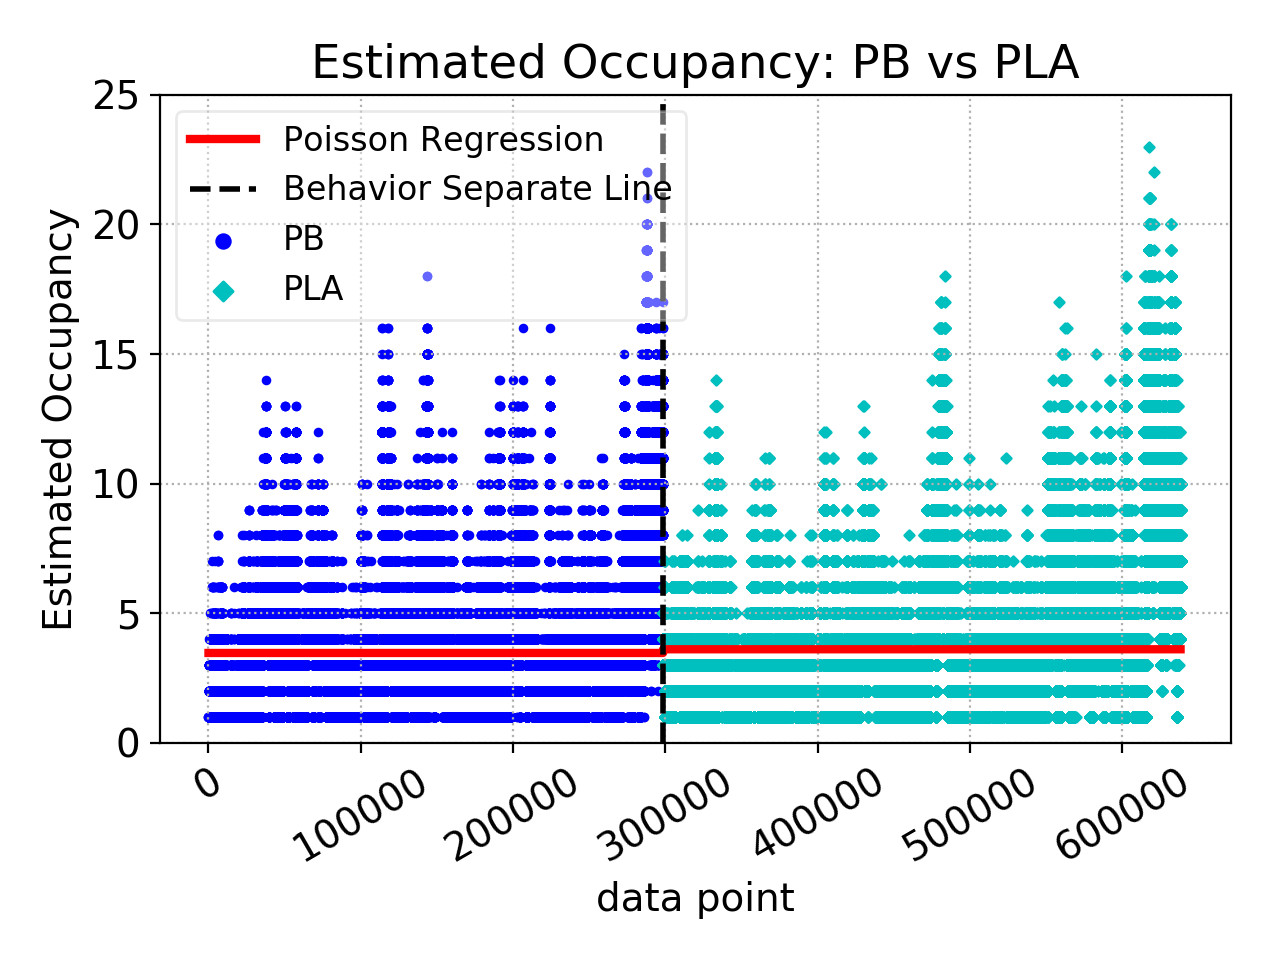

<IPython.core.display.Javascript object>


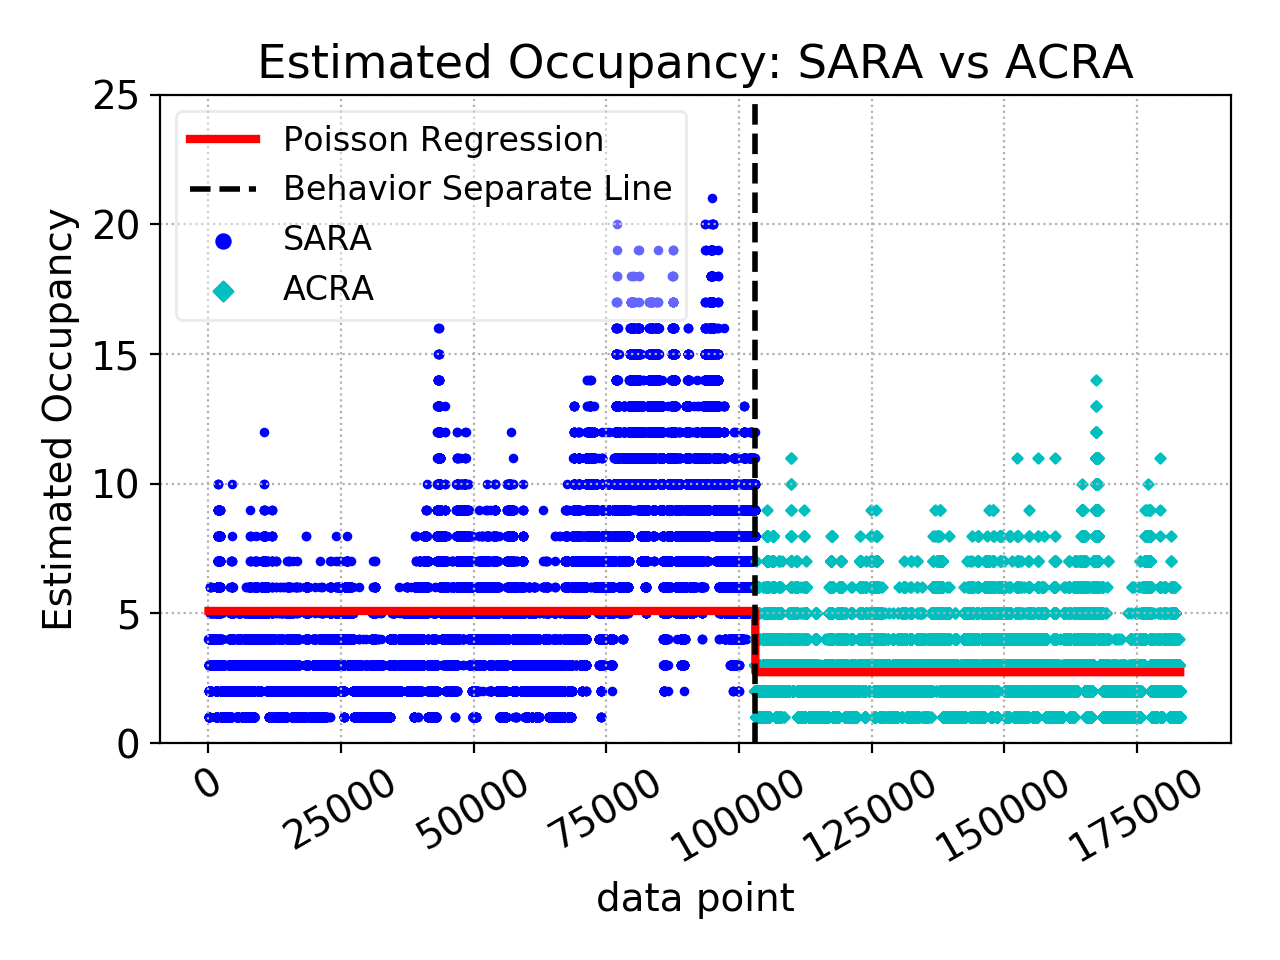

<IPython.core.display.Javascript object>


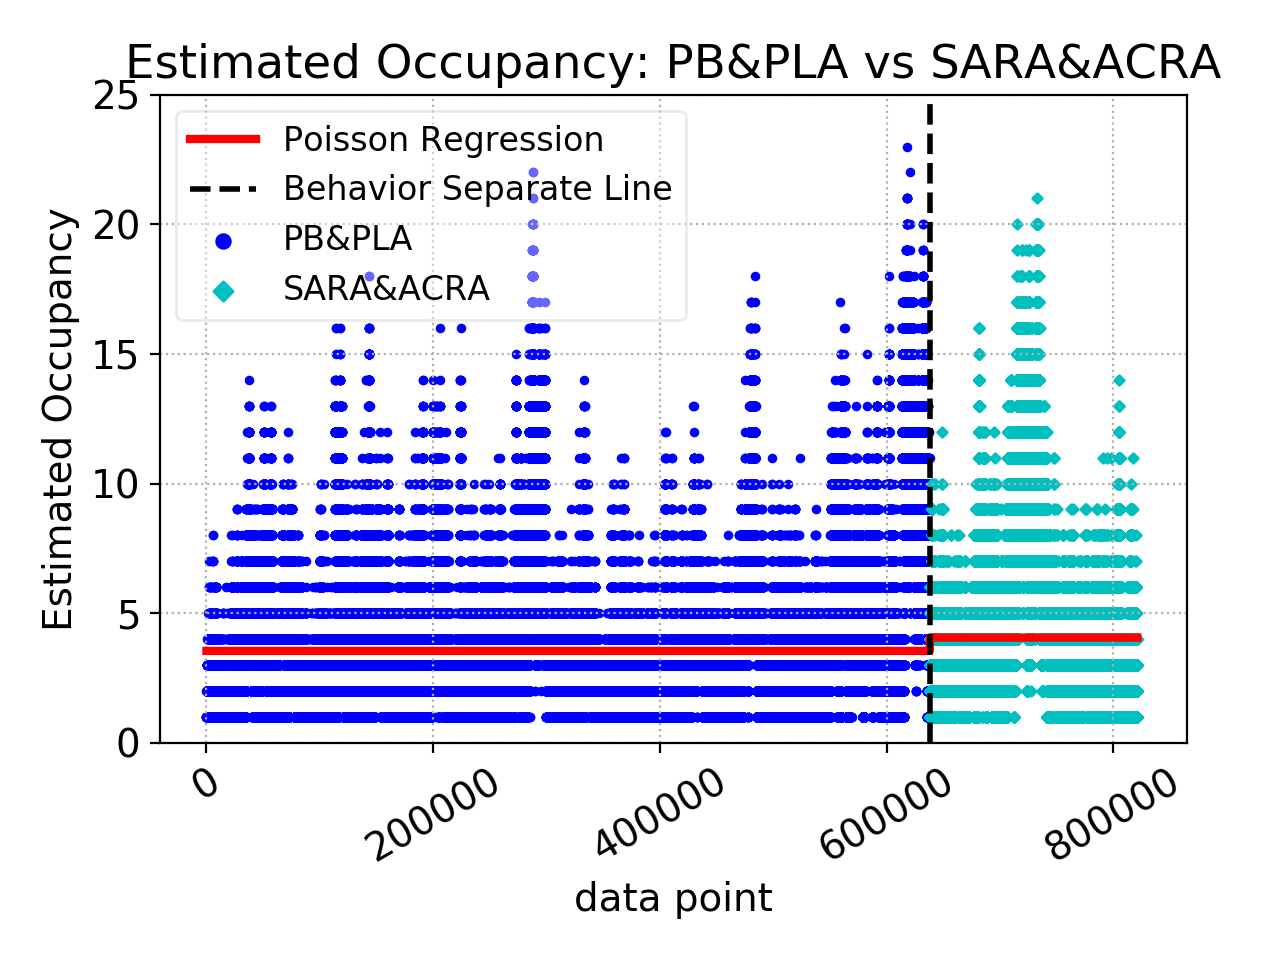

In [123]:

def plot_Poisson_Regression_On_Occupancy(Y, predVals, separate_line_PB_PLA, behavior1='PB', behavior2='PLA'):
    plt.figure()

    plt.scatter(range(separate_line_PB_PLA), Y[:separate_line_PB_PLA], c='b', marker='o', s = 6)
    plt.scatter(range(separate_line_PB_PLA,len(Y)), Y[separate_line_PB_PLA:], c='c', marker='D', s = 6)

    plt.plot(range(len(Y)), predVals, 'r-', linewidth=3)

    plt.axvline(x=separate_line_PB_PLA, linestyle='--', color='black',linewidth=2)

    plt.ylabel('Estimated Occupancy')
    plt.xlabel('data point')
    plt.xticks(rotation=30)
#     if behavior1=='PB':
#         plt.xlim(-20,300)
#     else:
#         plt.xlim(-5,70)
    plt.ylim(0,25)
    plt.title('Estimated Occupancy: {} vs {}'.format(behavior1, behavior2))
    plt.legend(['Poisson Regression', 'Behavior Separate Line', behavior1, behavior2],fontsize=12, markerscale=2, framealpha=0.4)
    plt.tight_layout()
    plt.grid(True, linestyle=':')
    plt.show()
    plt.savefig('./figures/Poisson_Regression_estimated_occupancy_{}_{}.png'.format(behavior1, behavior2), dpi=300)

plot_Poisson_Regression_On_Occupancy(PB_PLA_Y_occupancy, 
                                     PB_PLA_predVals_occupancy, 
                                     PB_PLA_occupancy_separate_line, 
                                     behavior1='PB', behavior2='PLA')

plot_Poisson_Regression_On_Occupancy(SARA_ACRA_Y_occupancy, 
                                     SARA_ACRA_predVals_occupancy, 
                                     SARA_ACRA_occupancy_separate_line, 
                                     behavior1='SARA', behavior2='ACRA')

plot_Poisson_Regression_On_Occupancy(PBPLA_SARAACRA_Y_occupancy, 
                                     PBPLA_SARAACRA_predVals_occupancy, 
                                     PBPLA_SARAACRA_occupancy_separate_line, 
                                     behavior1='PB&PLA', behavior2='SARA&ACRA')
    

# Estimated Occupancy: avg and standard deviation

In [115]:
print("PB_occupancy mean={},  PLA_occupancy mean = {}".format(PB_occupancy["Occupancy"].mean(),
                                                              PLA_occupancy["Occupancy"].mean()))
print("PB_occupancy std={},  PLA_occupancy std = {}".format(PB_occupancy["Occupancy"].std(),
                                                              PLA_occupancy["Occupancy"].std()))


print("SARA_occupancy mean={},  ACRA_occupancy mean = {}".format(SARA_occupancy["Occupancy"].mean(),
                                                              ACRA_occupancy["Occupancy"].mean()))
print("SARA_occupancy std={},  ACRA_occupancy std = {}".format(SARA_occupancy["Occupancy"].std(),
                                                              ACRA_occupancy["Occupancy"].std()))



PB_occupancy mean=2.958948012442249,  PLA_occupancy mean = 3.070376497618577
PB_occupancy std=2.5828647175974586,  PLA_occupancy std = 2.8432375398191563
SARA_occupancy mean=4.7958805091793,  ACRA_occupancy mean = 2.271592631819409
SARA_occupancy std=3.5584614810818884,  ACRA_occupancy std = 1.6870713318813384


In [97]:
def sparse_estimated_occupancy(PB_occupancy, avg_point=600):
    point_num = int(np.ceil(len(PB_occupancy["Occupancy"])/avg_point))
    point_avg = []
    for i in range(point_num):
        if i == point_num:
            point_avg.append(PB_occupancy["Occupancy"][i*avg_point:].mean())
        else:
            point_avg.append(PB_occupancy["Occupancy"][i*avg_point: (i+1)*avg_point].mean())
    return np.array(point_avg)

avg_point=600

point_avg_PB = sparse_estimated_occupancy(PB_occupancy, avg_point)
point_avg_PLA = sparse_estimated_occupancy(PLA_occupancy, avg_point)
point_avg_SARA = sparse_estimated_occupancy(SARA_occupancy, avg_point)
point_avg_ACRA = sparse_estimated_occupancy(ACRA_occupancy, avg_point)


In [98]:
print("point_avg_PB  : mean={},   std = {}".format(point_avg_PB.mean(),point_avg_PB.std()))
print("point_avg_PLA : mean={},   std = {}".format(point_avg_PLA.mean(),point_avg_PLA.std()))
print("point_avg_SARA: mean={},   std = {}".format(point_avg_SARA.mean(),point_avg_SARA.std()))
print("point_avg_ACRA: mean={},   std = {}".format(point_avg_ACRA.mean(),point_avg_ACRA.std()))

point_avg_PB  : mean=2.959477796836287,   std = 2.3112296786744273
point_avg_PLA : mean=3.070869485638088,   std = 2.6037004284674334
point_avg_SARA: mean=4.809092564994205,   std = 3.284168143885707
point_avg_ACRA: mean=2.2677126212803964,   std = 1.3520883052342922


In [99]:
from scipy import stats
t_PB_PLA, p_PB_PLA = stats.ttest_ind(point_avg_PB, point_avg_PLA)
t_PB_SARA, p_PB_SARA = stats.ttest_ind(point_avg_PB, point_avg_SARA)
t_PB_ACRA, p_PB_ACRA =stats.ttest_ind(point_avg_PB, point_avg_ACRA)
t_PLA_SARA, p_PLA_SARA =stats.ttest_ind(point_avg_PLA, point_avg_SARA)
t_PLA_ACRA, p_PLA_ACRA = stats.ttest_ind(point_avg_PLA, point_avg_ACRA)
t_SARA_ACRA, t_SARA_ACRA =stats.ttest_ind(point_avg_SARA, point_avg_ACRA)
print('t_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(t_PB_PLA, p_PB_PLA))
print('t_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(t_PB_SARA, p_PB_SARA))
print('t_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(t_PB_ACRA, p_PB_ACRA))
print('t_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(t_PLA_SARA, p_PLA_SARA))
print('t_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(t_PLA_ACRA, p_PLA_ACRA))
print('t_SARA_ACRA={0:.4f}, t_SARA_ACRA={1:.4f}'.format(t_SARA_ACRA, t_SARA_ACRA))


t_PB_PLA=-0.7940, p_PB_PLA=0.4273
t_PB_SARA=-8.4586, p_PB_SARA=0.0000
t_PB_ACRA=3.6252, p_PB_ACRA=0.0003
t_PLA_SARA=-7.5244, p_PLA_SARA=0.0000
t_PLA_ACRA=3.7878, p_PLA_ACRA=0.0002
t_SARA_ACRA=0.0000, t_SARA_ACRA=0.0000


In [113]:
from scipy import stats
t_PB_PLA, p_PB_PLA = stats.ttest_ind(point_avg_PB, point_avg_PLA, equal_var=False)
t_PB_SARA, p_PB_SARA = stats.ttest_ind(point_avg_PB, point_avg_SARA, equal_var=False)
t_PB_ACRA, p_PB_ACRA =stats.ttest_ind(point_avg_PB, point_avg_ACRA, equal_var=False)
t_PLA_SARA, p_PLA_SARA =stats.ttest_ind(point_avg_PLA, point_avg_SARA, equal_var=False)
t_PLA_ACRA, p_PLA_ACRA = stats.ttest_ind(point_avg_PLA, point_avg_ACRA, equal_var=False)
t_SARA_ACRA, t_SARA_ACRA =stats.ttest_ind(point_avg_SARA, point_avg_ACRA, equal_var=False)
print('t_PB_PLA={0:.4f}, p_PB_PLA={1:.4f}'.format(t_PB_PLA, p_PB_PLA))
print('t_PB_SARA={0:.4f}, p_PB_SARA={1:.4f}'.format(t_PB_SARA, p_PB_SARA))
print('t_PB_ACRA={0:.4f}, p_PB_ACRA={1:.4f}'.format(t_PB_ACRA, p_PB_ACRA))
print('t_PLA_SARA={0:.4f}, p_PLA_SARA={1:.4f}'.format(t_PLA_SARA, p_PLA_SARA))
print('t_PLA_ACRA={0:.4f}, p_PLA_ACRA={1:.4f}'.format(t_PLA_ACRA, p_PLA_ACRA))
print('t_SARA_ACRA={0:.4f}, t_SARA_ACRA={1:.4f}'.format(t_SARA_ACRA, t_SARA_ACRA))





t_PB_PLA=-0.8003, p_PB_PLA=0.4237
t_PB_SARA=-7.0701, p_PB_SARA=0.0000
t_PB_ACRA=4.8193, p_PB_ACRA=0.0000
t_PLA_SARA=-6.5955, p_PLA_SARA=0.0000
t_PLA_ACRA=5.4622, p_PLA_ACRA=0.0000
t_SARA_ACRA=0.0000, t_SARA_ACRA=0.0000


In [100]:
occupancy = [point_avg_PB, point_avg_PLA, point_avg_SARA, point_avg_ACRA]
behavior_name = ['PB', 'PLA', 'SARA', 'ACRA']
for i in range(4):
    mean = occupancy[i].mean()
    std = occupancy[i].std()
    print('{0}: mean={1:.4f}, std={2:.4f}'.format(behavior_name[i], mean, std))

PB: mean=2.9595, std=2.3112
PLA: mean=3.0709, std=2.6037
SARA: mean=4.8091, std=3.2842
ACRA: mean=2.2677, std=1.3521


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


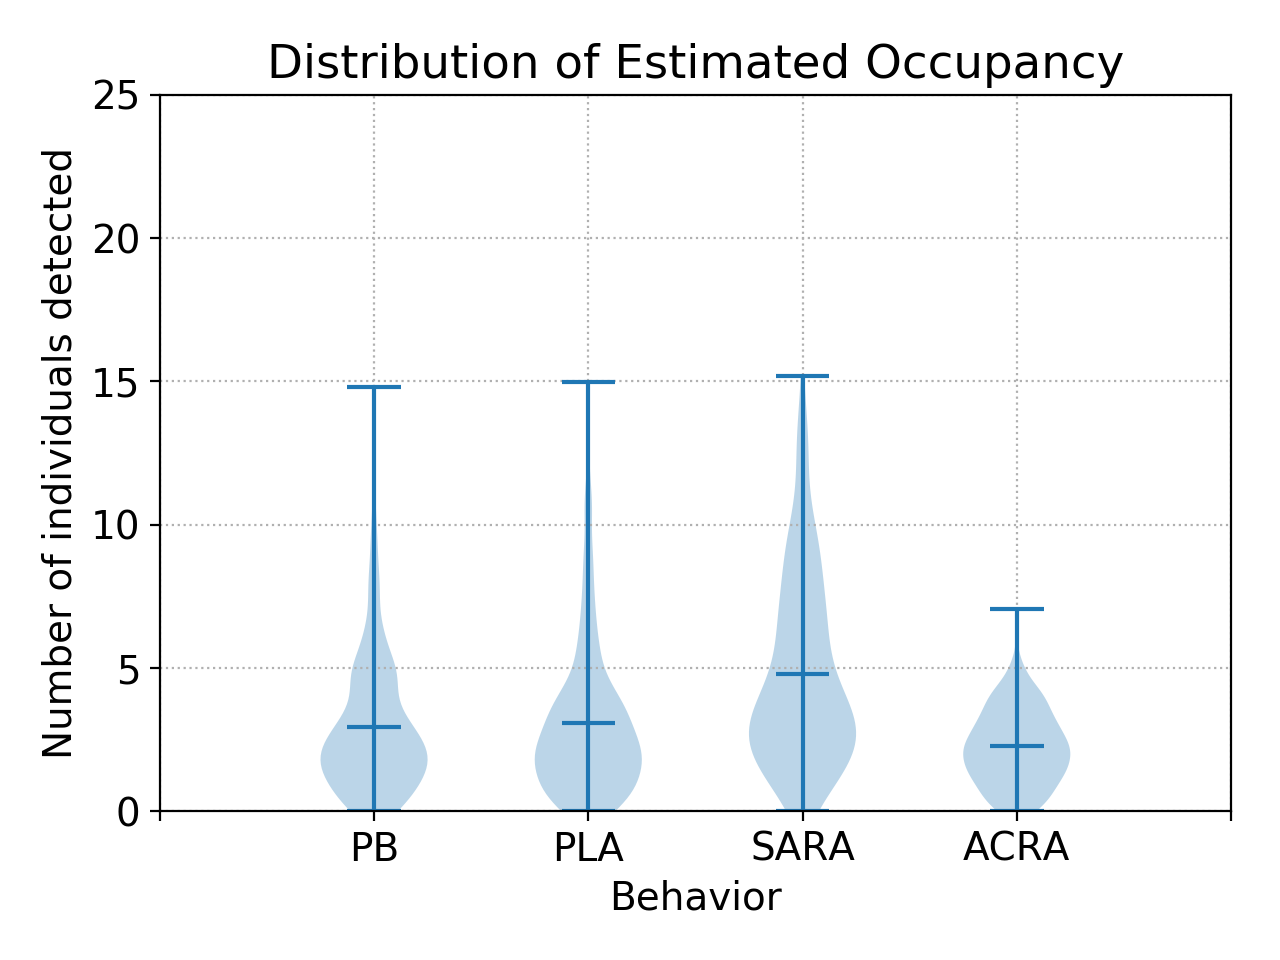

In [101]:
estimated_occupancy = [point_avg_PB, point_avg_PLA, 
                       point_avg_SARA, point_avg_ACRA]

plt.figure()
plt.rcParams.update({'font.size': 14})
plt.violinplot(estimated_occupancy, showmeans=True, showmedians=False)
plt.xticks(np.arange(0,6), ['','PB', 'PLA', 'SARA', 'ACRA'])
plt.ylim(0,25)
plt.ylabel('Number of individuals detected')
plt.xlabel('Behavior')
plt.title('Distribution of Estimated Occupancy')
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Distribution_of_Estimated_Occupancy_sparsed_data_point.png', dpi=300)


len_PB=583, len_PLA=666, len_SARA=183, len_ACRA=161


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


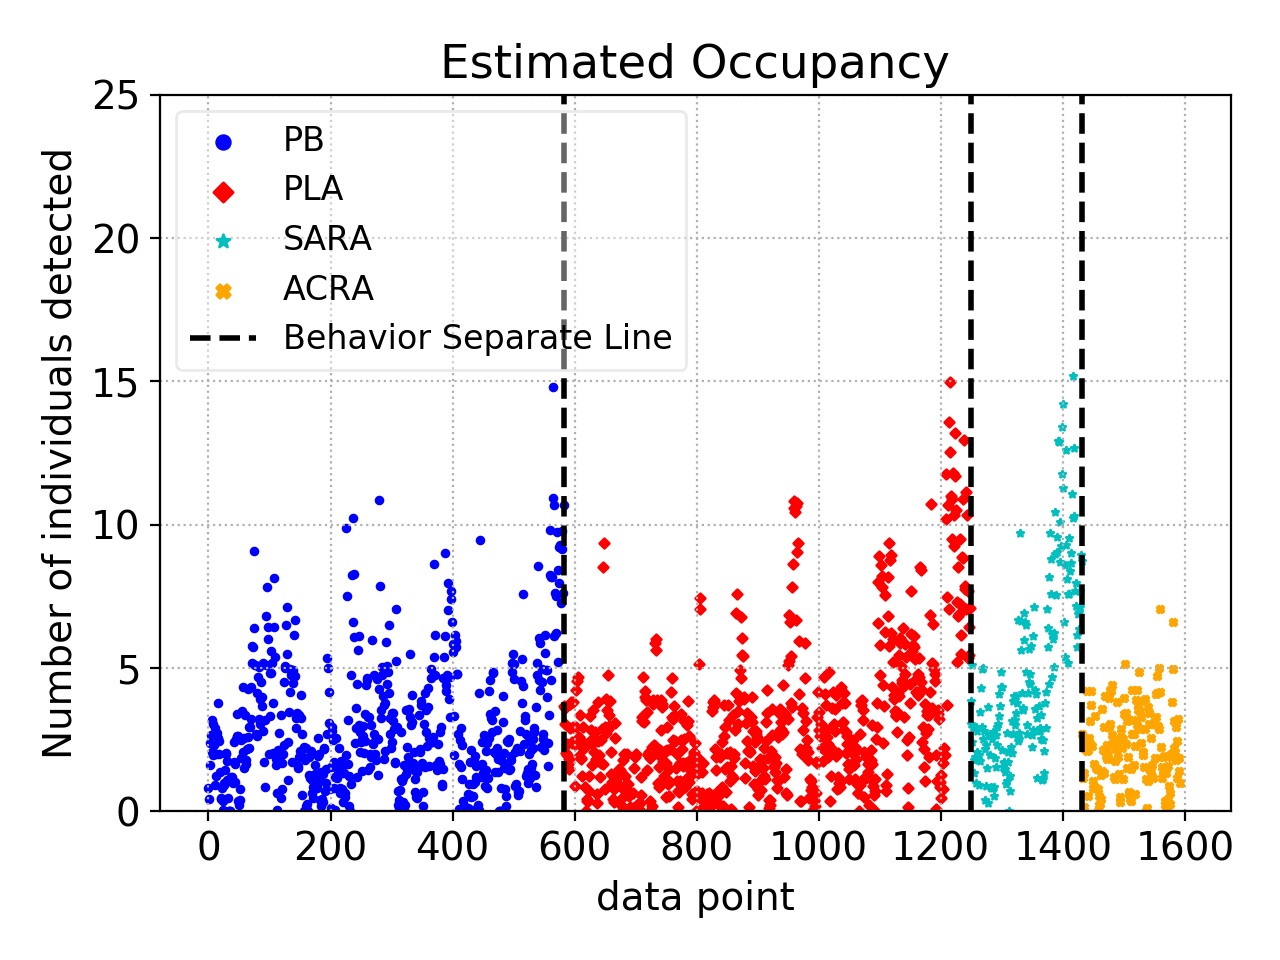

In [102]:
len_PB = len(point_avg_PB)
len_PLA = len(point_avg_PLA)
len_SARA = len(point_avg_SARA)
len_ACRA = len(point_avg_ACRA)
print('len_PB={}, len_PLA={}, len_SARA={}, len_ACRA={}'.format(len_PB, len_PLA, len_SARA, len_ACRA))

plt.figure()

handle_PB = plt.scatter(range(len_PB), point_avg_PB, c='b', marker='o', s = 6)
handle_PLA = plt.scatter(range(len_PB,len_PB+len_PLA), point_avg_PLA, c='r', marker='D', s = 6)
handle_SARA = plt.scatter(range(len_PB+len_PLA,len_PB+len_PLA+len_SARA), point_avg_SARA, c='c', marker='*', s = 6)
handle_ACRA = plt.scatter(range(len_PB+len_PLA+len_SARA,len_PB+len_PLA+len_SARA+len_ACRA), point_avg_ACRA, c='orange', marker='X', s = 6)

# plt.plot(range(len(Y)), predVals, 'r-', linewidth=3)

handle_separate_line = plt.axvline(x=len_PB, linestyle='--', color='black',linewidth=2)
plt.axvline(x=len_PB+len_PLA, linestyle='--', color='black',linewidth=2)
plt.axvline(x=len_PB+len_PLA+len_SARA, linestyle='--', color='black',linewidth=2)

plt.ylabel('Number of individuals detected')
plt.xlabel('data point')

plt.ylim(0,25)
plt.title('Estimated Occupancy')
plt.legend(handles=[handle_PB, handle_PLA, handle_SARA, handle_ACRA, handle_separate_line], 
           labels=['PB', 'PLA', 'SARA', 'ACRA', 'Behavior Separate Line'],fontsize=12, markerscale=2, framealpha=0.4)
plt.tight_layout()
plt.grid(True, linestyle=':')
plt.show()
plt.savefig('./figures/Estimated_occupancy_comparison_sparsed_data_point.png', dpi=300)

# Plot normalized active interaction

In [103]:
active_interaction_estimate_PB = predVals_PB_PLA[0]
active_interaction_estimate_PLA = predVals_PB_PLA[-1]
active_interaction_estimate_SARA = predVals_PB_PLA_SARA_ACRA[0]
active_interaction_estimate_ACRA = predVals_PB_PLA_SARA_ACRA[-1]
print('Active interaction estimation fitted number:')
print('PB={}'.format(active_interaction_estimate_PB))
print('PLA={}'.format(active_interaction_estimate_PLA))
print('SARA={}'.format(active_interaction_estimate_SARA))
print('ACRA={}'.format(active_interaction_estimate_ACRA))
active_interaction_estimate = [active_interaction_estimate_PB,
                               active_interaction_estimate_PLA,
                               active_interaction_estimate_SARA,
                               active_interaction_estimate_ACRA]


Active interaction estimation fitted number:
PB=61.529850746268686
PLA=134.4822695035461
SARA=98.93454545454546
ACRA=49.476923076923065


In [104]:
occupancy_estimate_PB = PB_PLA_predVals_occupancy[0]
occupancy_estimate_PLA = PB_PLA_predVals_occupancy[-1]
occupancy_estimate_SARA = SARA_ACRA_predVals_occupancy[0]
occupancy_estimate_ACRA = SARA_ACRA_predVals_occupancy[-1]
print('Occupancy estimation fitted number:')
print('PB={}'.format(occupancy_estimate_PB))
print('PLA={}'.format(occupancy_estimate_PLA))
print('SARA={}'.format(occupancy_estimate_SARA))
print('ACRA={}'.format(occupancy_estimate_ACRA))
occupancy_estimate = [occupancy_estimate_PB, 
                      occupancy_estimate_PLA,
                      occupancy_estimate_SARA, 
                      occupancy_estimate_ACRA]


Occupancy estimation fitted number:
PB=3.4684180188872373
PLA=3.611126810315073
SARA=5.091761099038366
ACRA=2.731083729697966


In [105]:
active_interaction_PB = Y_PB_PLA[:separate_line_PB_PLA]
active_interaction_PLA = Y_PB_PLA[separate_line_PB_PLA:]
active_interaction_SARA = Y_SARA_ACRA[:separate_line_SARA_ACRA]
active_interaction_ACRA= Y_SARA_ACRA[separate_line_SARA_ACRA:]
average_active_interaction = [active_interaction_PB.mean(),
                              active_interaction_PLA.mean(),
                              active_interaction_SARA.mean(),
                              active_interaction_ACRA.mean()]

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


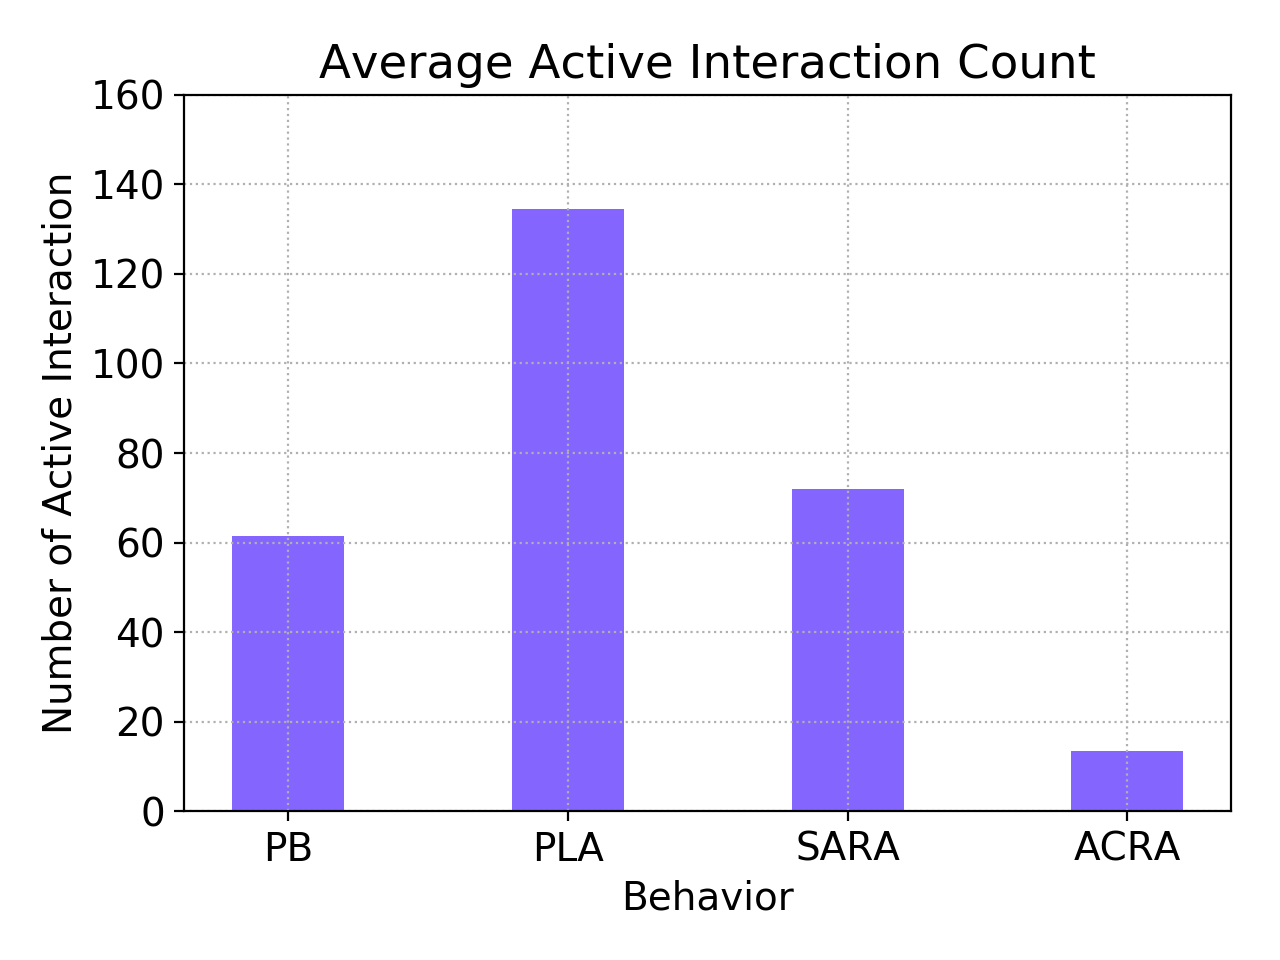

In [106]:
plt.figure()
plt.bar(np.arange(0,4), average_active_interaction, color=(0.2, 0, 1, 0.6), width=0.4)
plt.ylabel('Number of Active Interaction')
plt.ylim(0,160)
plt.xlabel('Behavior')
plt.xticks(np.arange(0,4),['PB', 'PLA', 'SARA', 'ACRA'])
plt.title('Average Active Interaction Count')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig('./figures/Average_of_Active_Interaction_Count', dpi=300)

point_avg_PB  : mean=2.959477796836287,   std = 2.3112296786744273
point_avg_PLA : mean=3.070869485638088,   std = 2.6037004284674334
point_avg_SARA: mean=4.809092564994205,   std = 3.284168143885707
point_avg_ACRA: mean=2.2677126212803964,   std = 1.3520883052342922


/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


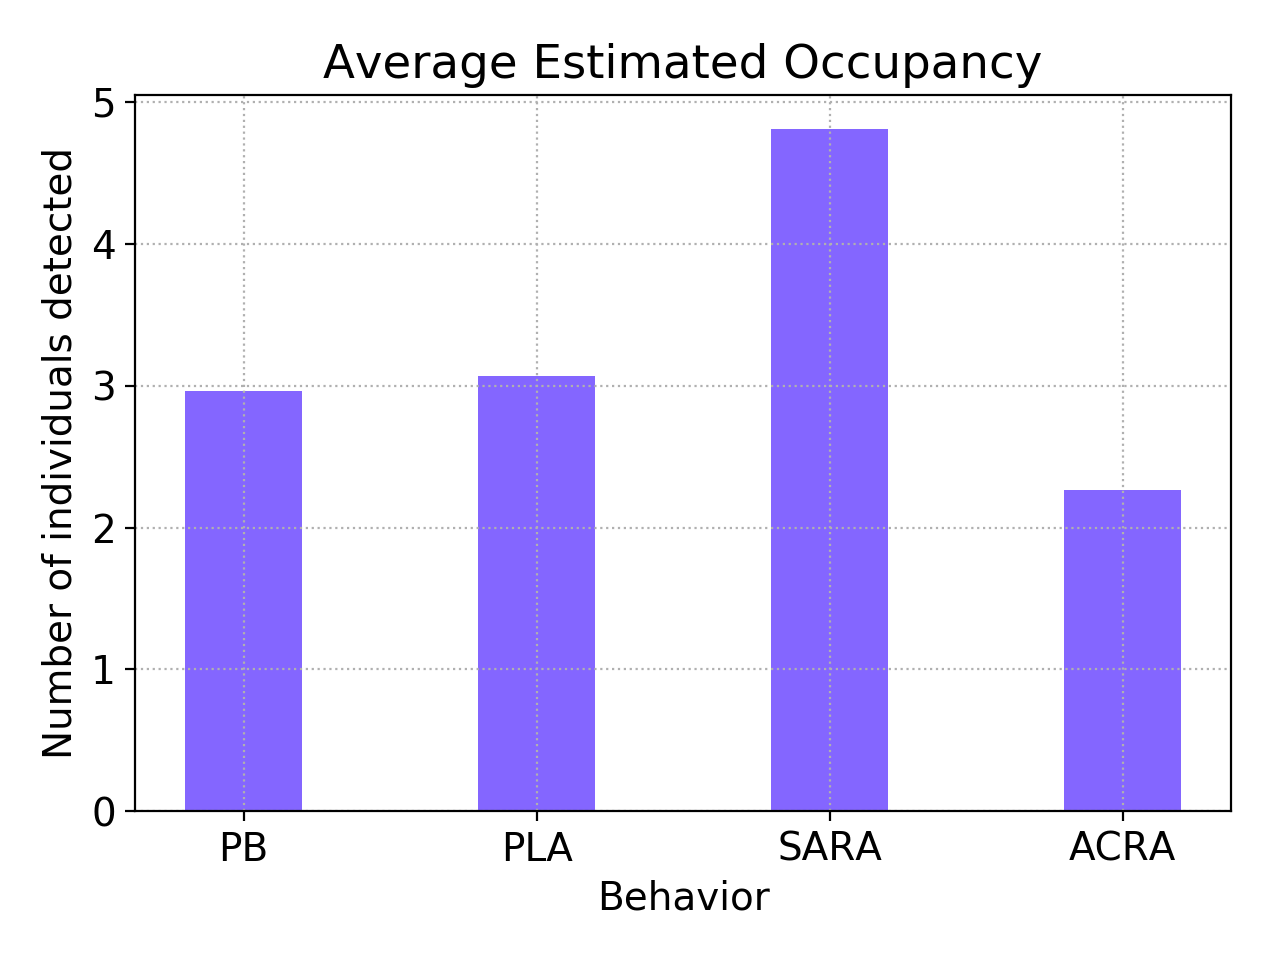

In [107]:
print("point_avg_PB  : mean={},   std = {}".format(point_avg_PB.mean(),point_avg_PB.std()))
print("point_avg_PLA : mean={},   std = {}".format(point_avg_PLA.mean(),point_avg_PLA.std()))
print("point_avg_SARA: mean={},   std = {}".format(point_avg_SARA.mean(),point_avg_SARA.std()))
print("point_avg_ACRA: mean={},   std = {}".format(point_avg_ACRA.mean(),point_avg_ACRA.std()))
average_occupancy_estimate = [point_avg_PB.mean(), point_avg_PLA.mean(), point_avg_SARA.mean(), point_avg_ACRA.mean()]
plt.figure()
plt.bar(np.arange(0,4), average_occupancy_estimate,color=(0.2, 0, 1, 0.6), width=0.4)
plt.ylabel('Number of individuals detected')
plt.xlabel('Behavior')
plt.xticks(np.arange(0,4),['PB', 'PLA', 'SARA', 'ACRA'])
plt.title('Average Estimated Occupancy')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig('./figures/Average_of_estimated_occupancy.png', dpi=300)

### normalized by estimated occupancy

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


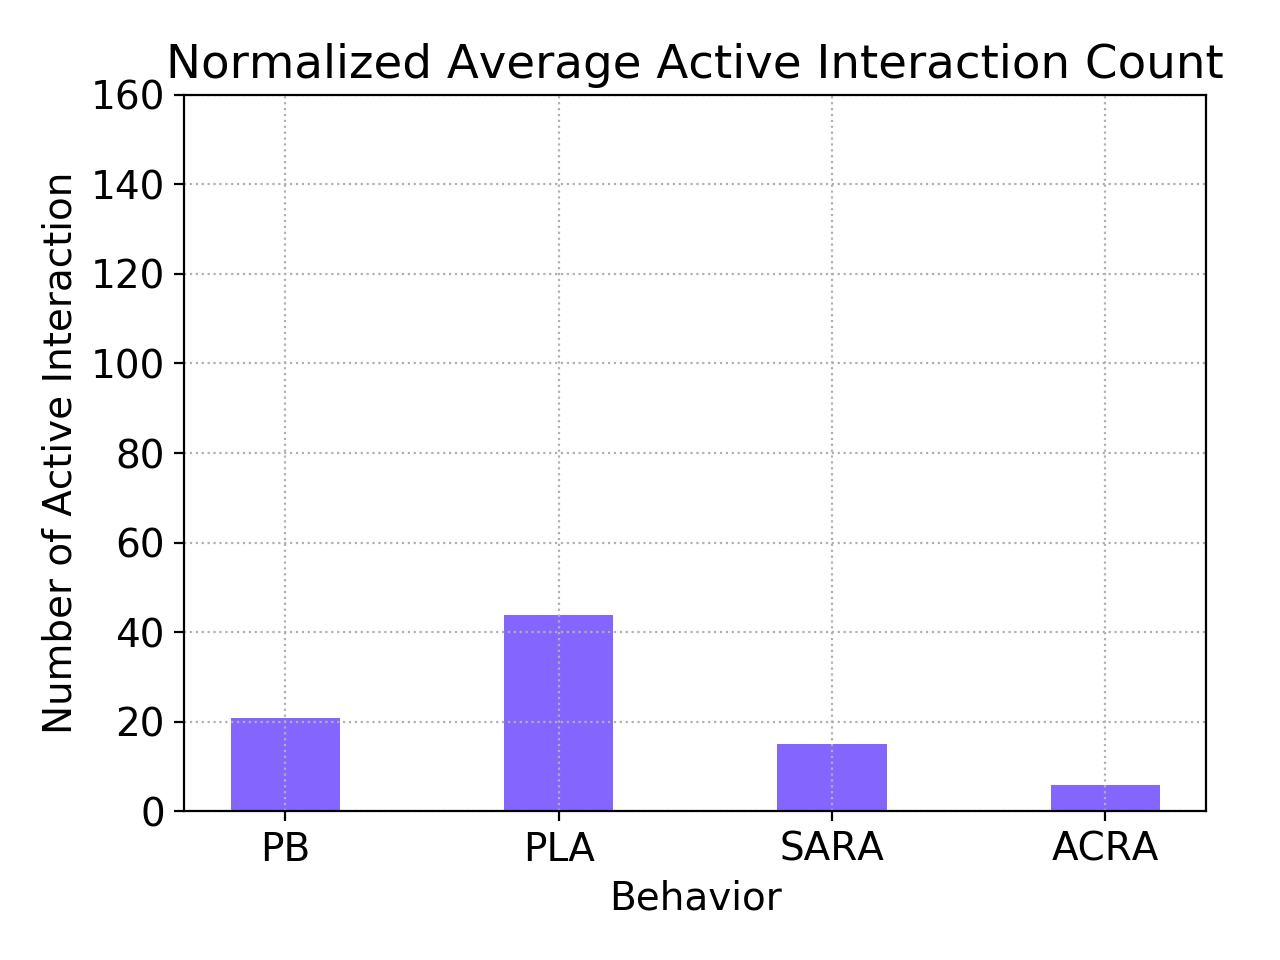

In [108]:
plt.figure()
plt.bar(np.arange(0,4), np.divide(average_active_interaction, average_occupancy_estimate),
        color=(0.2, 0, 1, 0.6), width=0.4)
plt.ylabel('Number of Active Interaction')
plt.ylim(0,160)
plt.xlabel('Behavior')
plt.xticks(np.arange(0,4),['PB', 'PLA', 'SARA', 'ACRA'])
plt.title('Normalized Average Active Interaction Count')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.savefig('./figures/Normalized_Average_of_Active_Interaction_Count.png', dpi=300)

# Plot Schedule

/Users/jack.lingheng.meng/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


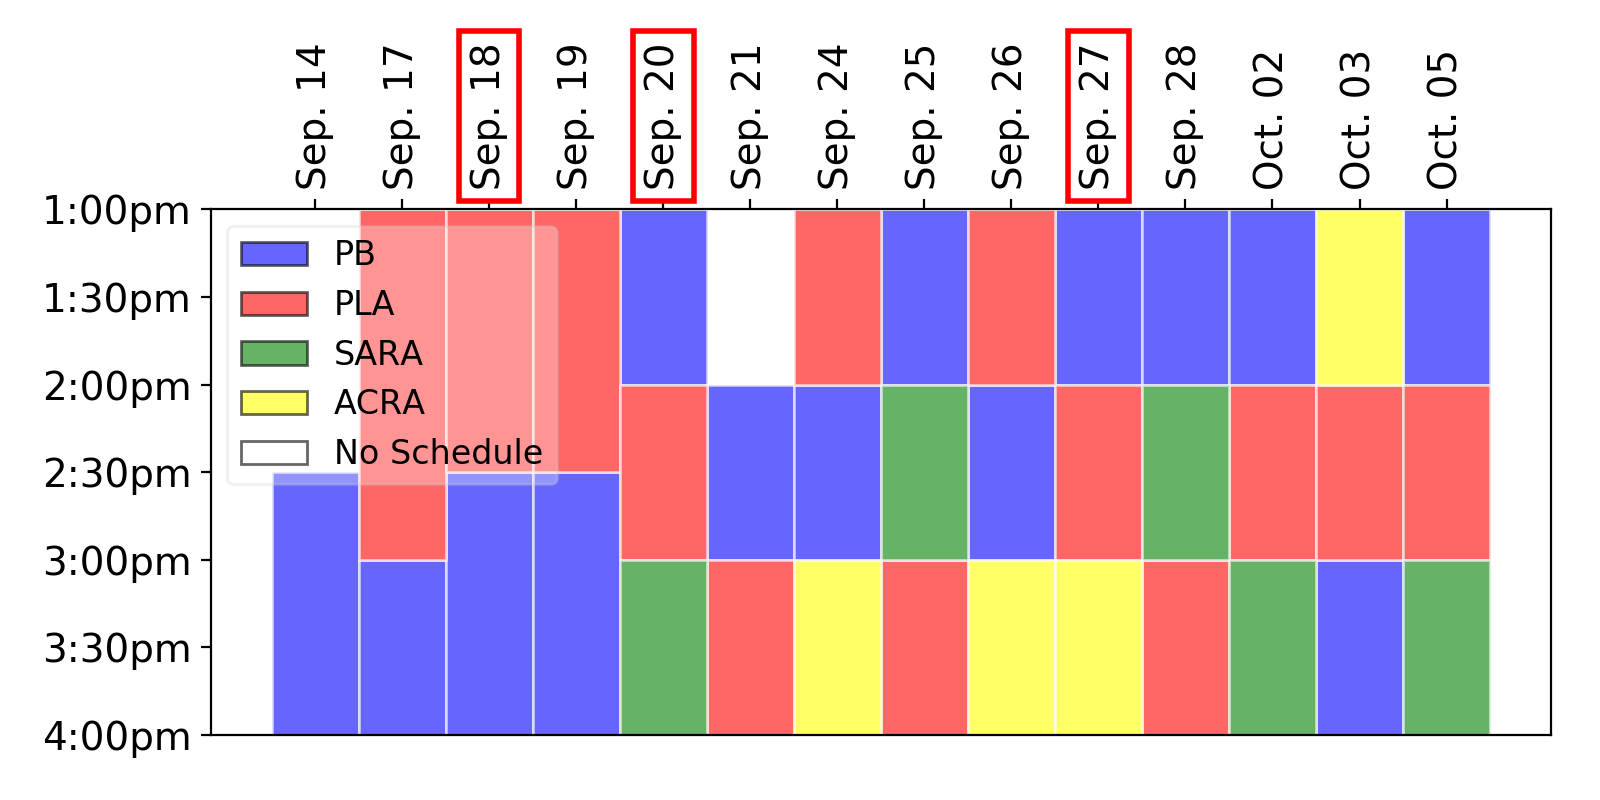

In [109]:
dates = ['Sep. 14', 
         'Sep. 17', 'Sep. 18', 'Sep. 19', 'Sep. 20', 'Sep. 21', 
         'Sep. 24', 'Sep. 25', 'Sep. 26', 'Sep. 27', 'Sep. 28', 
         'Oct. 02', 'Oct. 03','Oct. 05']
slots = ['1:00pm', '1:30pm', '2:00pm', '2:30pm', '3:00pm', '3:30pm', '4:00pm']

# Parameter in broken_barh: (ymin, ymax): The y-position and extend for all the rectangles.
PB_time = [(3,3),
           (4,2),(3,3),(3,3),(0,2),(2,2),
           (2,2),(0,2),(2,2),(0,2),(0,2),
           (0,2),(4,2),(0,2)]
PLA_time = [(0,0),
            (0,4),(0,3),(0,3),(2,2),(4,2),
            (0,2),(4,2),(0,2),(2,2),(4,2),
            (2,2),(2,2),(2,2)]
SARA_time = [(0,0),
             (0,0),(0,0),(0,0),(4,2),(0,0),
             (0,0),(2,2),(0,0),(0,0),(2,2),
             (4,2),(0,0),(4,2)]
ACRA_time = [(0,0),
             (0,0),(0,0),(0,0),(0,0),(0,0),
             (4,2),(0,0),(4,2),(4,2),(0,0),
             (0,0),(0,2),(0,0)]

from matplotlib.patches import Patch
plt.figure(figsize=[8,4])

bar_w=1
for x in range(len(dates)):
    plt.broken_barh([(x-bar_w/2,bar_w)], PB_time[x], facecolors='blue',edgecolor='w',alpha=0.6)
    
for x in range(len(dates)):
    plt.broken_barh([(x-bar_w/2,bar_w)], PLA_time[x], facecolors='red',edgecolor='w',alpha=0.6)
    
for x in range(len(dates)):
    plt.broken_barh([(x-bar_w/2,bar_w)], SARA_time[x], facecolors='green',edgecolor='w',alpha=0.6)

for x in range(len(dates)):
    plt.broken_barh([(x-bar_w/2,bar_w)], ACRA_time[x], facecolors='yellow',edgecolor='w',alpha=0.6)

plt.xticks(np.arange(len(dates)), dates, rotation=90)


plt.ylim(0,6)
plt.yticks(np.arange(0, 6.1, 1), slots)
# plt.xlabel('dates')
ax = plt.gca()
ax.xaxis.set_label_position('top') 
ax.xaxis.set_ticks_position('top')
# plt.ylabel('time')
plt.gca().invert_yaxis()
# plt.title('Experiment Schedule')
legend_elements = [Patch(facecolor='blue', edgecolor='k',alpha=0.6,label='PB'),
                   Patch(facecolor='red', edgecolor='k',alpha=0.6,label='PLA'),
                   Patch(facecolor='green', edgecolor='k',alpha=0.6,label='SARA'),
                   Patch(facecolor='yellow', edgecolor='k',alpha=0.6,label='ACRA'),
                   Patch(facecolor='white', edgecolor='k',alpha=0.6,label='No Schedule')]

plt.legend(handles=legend_elements, loc='upper left', framealpha=0.3, fontsize=12)

ax = plt.gca()
label = ax.xaxis.get_ticklabels()
label[2].set_bbox(dict(facecolor='none', edgecolor='red', linewidth=2))
label[4].set_bbox(dict(facecolor='none', edgecolor='red', linewidth=2))
label[9].set_bbox(dict(facecolor='none', edgecolor='red', linewidth=2))



plt.tight_layout()
plt.savefig('./figures/plot_experiment_schedule.png', dpi=300)
# plt.grid(True, linestyle=':')
